## Install Dependencies

In [1]:
%pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
import scipy
from statistics import mean, median, stdev


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
plt.rcParams["figure.dpi"] = 300

In [3]:
LINECHART_MARKER = "x"
LINECHART_MARKER_SIZE = 5

In [4]:
def printb(text: str) -> None:
    print("\033[1m" + text + "\033[0m")

## Load result data

In [5]:
import json 

with open("experiment_rcs_results.json", "r") as results_file:
    experiments = json.load(results_file)

In [6]:
available_tags = set([
    experiment["params"]["tag"] for experiment in experiments
])
print("available tags:", available_tags)

available tags: {'varying_redundancy', 'varying_gates', 'varying_qubits'}


In [7]:
seeds = [experiment["params"]["seed"] for experiment in experiments]
seeds = list(set(seeds))

print(seeds)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [8]:
target_dir = "results_rcs" # Used for storing plots

## RQ1: How does the degree of redundancy within a population influence the behavior of the proposed simulation approach?

In [9]:
# Filter out and format experiment results with the varying_redundancy tag

vr_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_redundancy"]
print(f"Total amount of varying_redundancy experiments: {len(vr_experiments)}")

Total amount of varying_redundancy experiments: 240


In [10]:
redundancies = [experiment["params"]["redundancy"] for experiment in vr_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


Total simulation time, averaged across seeds:


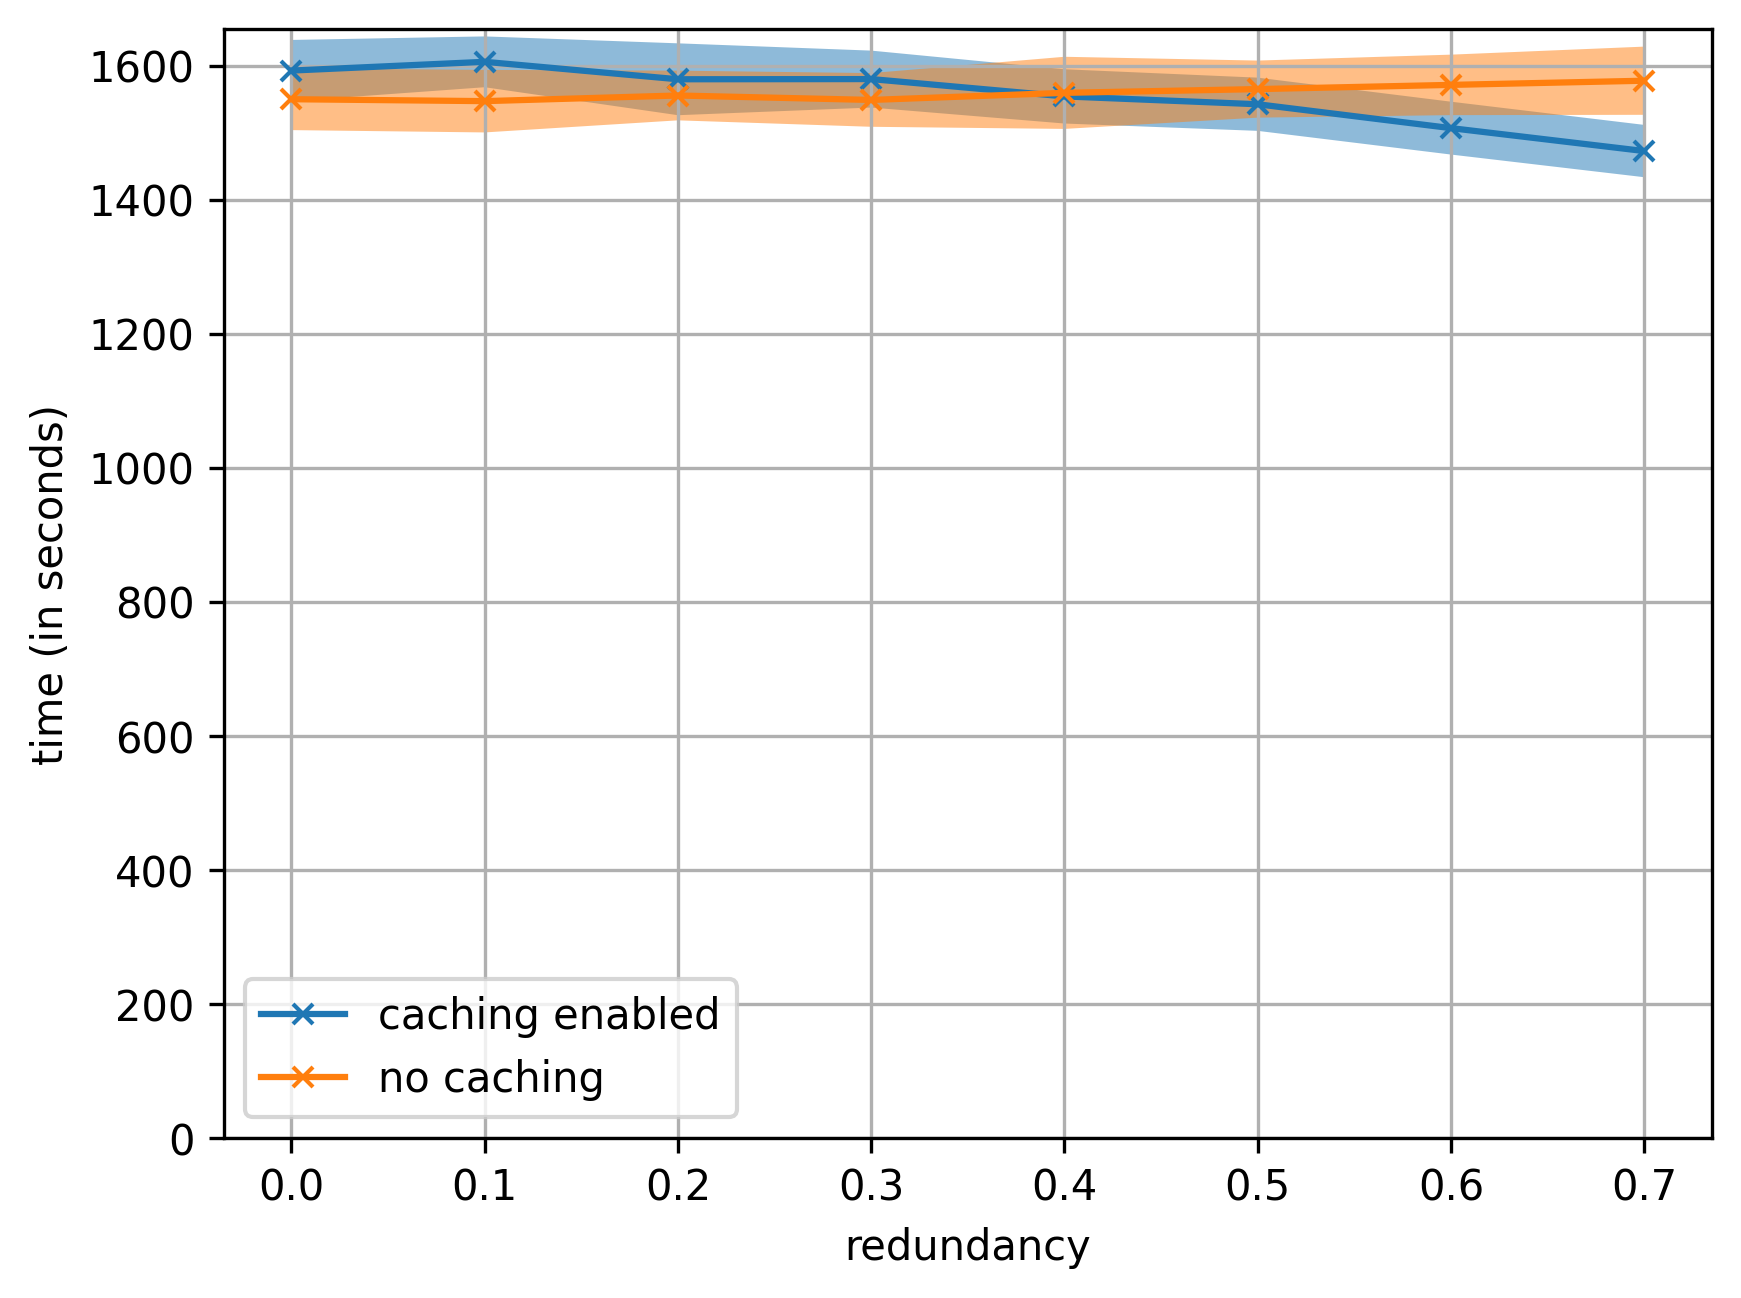

In [11]:
# Create a line chart with simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
stdevs_no_cache = []
durations_with_cache = []
stdevs_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))
    stdevs_no_cache.append(stdev(sel_durations_no_cache))
    
    sel_durations_with_cache = [
        experiment["total_duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))
    stdevs_with_cache.append(stdev(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache, label="caching enabled", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)

lower_bounds_with_cache = [
    duration - sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
]
upper_bounds_with_cache = [
    duration + sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
]
ax.fill_between(
    redundancies, lower_bounds_with_cache, upper_bounds_with_cache, alpha=0.5
)

ax.plot(redundancies, durations_no_cache, label="no caching", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)

lower_bounds_no_cache = [
    duration - sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
]
upper_bounds_no_cache = [
    duration + sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
]
ax.fill_between(
    redundancies, lower_bounds_no_cache, upper_bounds_no_cache, alpha=0.5
)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_over_redundancy.png")
plt.show()

In [12]:

printb("Pearson correlation coefficient time to redundancy caching:")


correlation = np.corrcoef(redundancies, durations_with_cache)[0, 1]

print(f"Pearson correlation coefficient: {correlation}")


printb("\nPearson correlation coefficient time to redundancy without caching:")

correlation = np.corrcoef(redundancies, durations_no_cache)[0, 1]

print(f"Pearson correlation coefficient: {correlation}")


Pearson correlation coefficient time to redundancy caching:
Pearson correlation coefficient: -0.9438293233588129

Pearson correlation coefficient time to redundancy without caching:
Pearson correlation coefficient: 0.9247809098062875


In [13]:
from scipy.stats import linregress

printb("Linear regression time to redundancy with caching:")
slope, intercept, r, p, se = linregress(redundancies, durations_with_cache)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R^2: {r**2}")
print(f"P value: {p}")
print(f"Std error: {se}")

printb("\nLinear regression time to redundancy without caching:")
slope, intercept, r, p, se = linregress(redundancies, durations_no_cache)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R^2: {r**2}")
print(f"P value: {p}")
print(f"Std error: {se}")

Linear regression time to redundancy with caching:
Slope: -175.29135131746023
Intercept: 1615.4505840944444
R^2: 0.8908137916319545
P value: 0.0004246107412964936
Std error: 25.053897143418855

Linear regression time to redundancy without caching:
Slope: 42.085182182539604
Intercept: 1544.4417720111112
R^2: 0.8552197311421446
P value: 0.0010048379302546645
Std error: 7.069186178725221


Net simulation time, averaged across seeds:


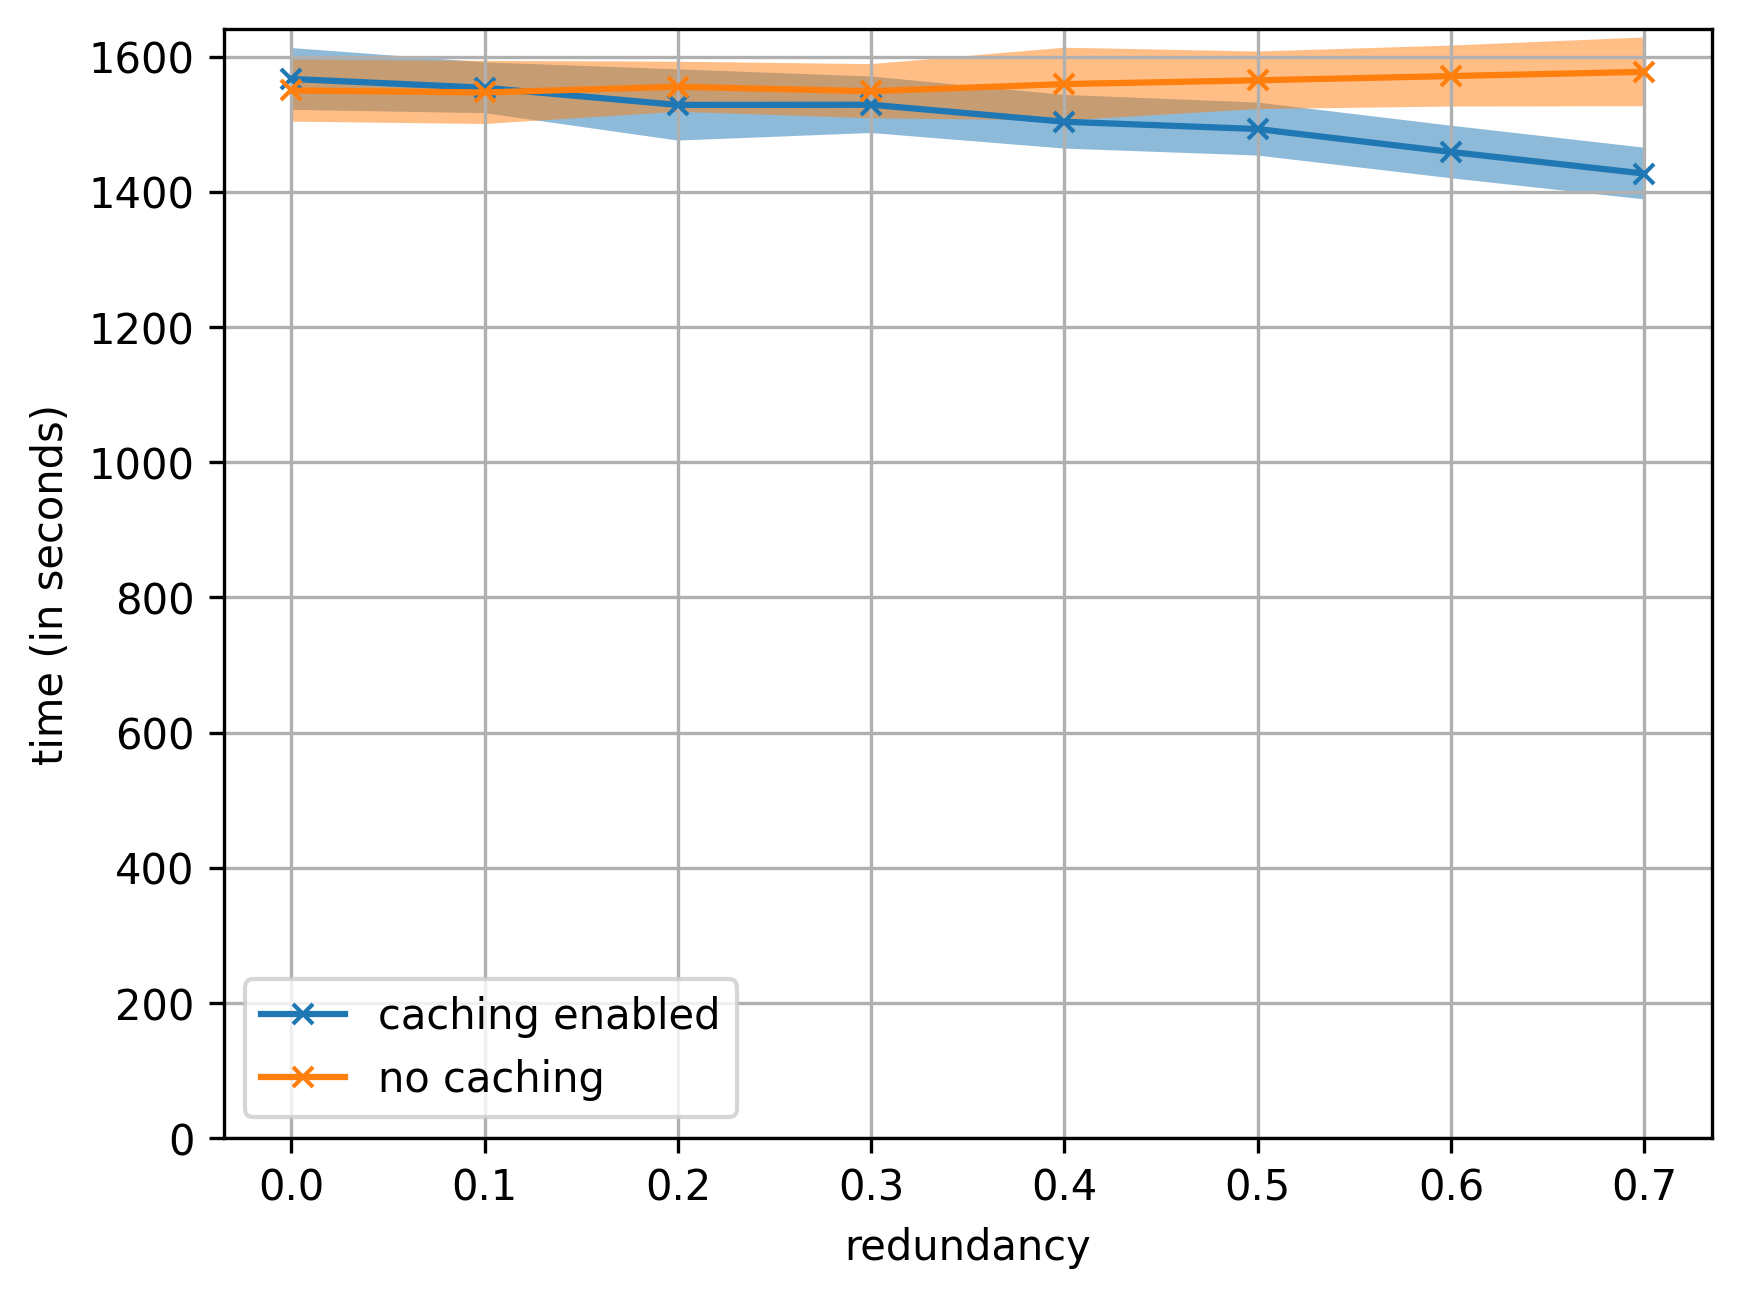

In [14]:
# Create a line chart with net simulation time on y and redundancy level
# on x. One line for the runs with caching enabled, one line for the
# runs with cache size 0.

durations_no_cache = []
stdevs_no_cache = []
durations_with_cache = []
stdevs_with_cache = []

for redundancy in redundancies:

    sel_durations_no_cache = [
        experiment["simulate_without_cache"]["duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] == 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_no_cache.append(mean(sel_durations_no_cache))
    stdevs_no_cache.append(stdev(sel_durations_no_cache))

    sel_durations_with_cache = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]
    durations_with_cache.append(mean(sel_durations_with_cache))
    stdevs_with_cache.append(stdev(sel_durations_with_cache))


ax = plt.subplot()
ax.plot(redundancies, durations_with_cache, label="caching enabled", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
lower_bounds_with_cache = [
    duration - sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
]
upper_bounds_with_cache = [
    duration + sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
]
ax.fill_between(
    redundancies, lower_bounds_with_cache, upper_bounds_with_cache, alpha=0.5
)

ax.plot(redundancies, durations_no_cache, label="no caching", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
lower_bounds_no_cache = [
    duration - sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
]
upper_bounds_no_cache = [
    duration + sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
]
ax.fill_between(
    redundancies, lower_bounds_no_cache, upper_bounds_no_cache, alpha=0.5
)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation time, averaged across seeds:")

plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/net_time_over_redundancy.png")
plt.show()

Total simulation time with caching disabled:


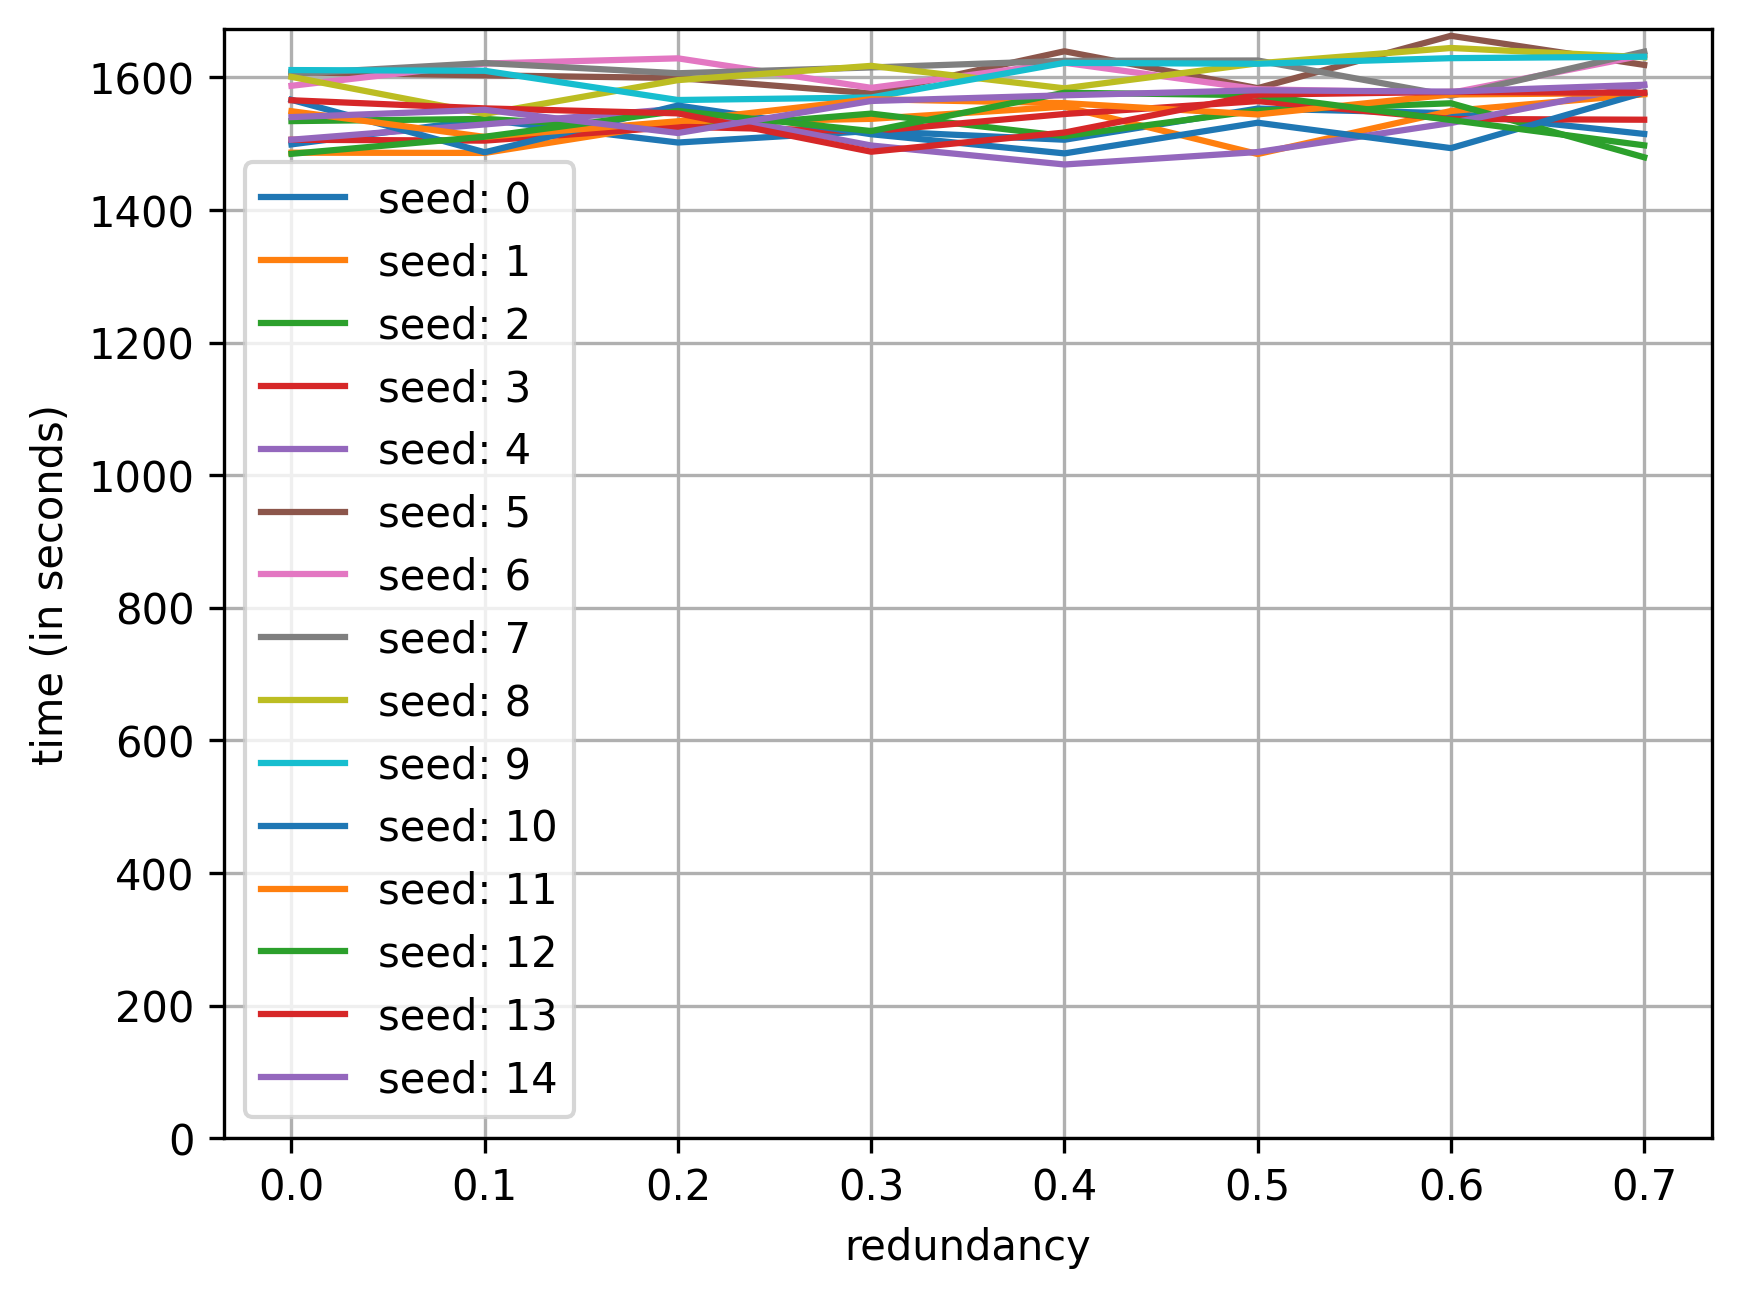

In [15]:
# plot simulation time of each seed without cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_no_cache = []

    for redundancy in redundancies:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_no_cache.append(sel_durations_no_cache[0])

    ax.plot(redundancies, seed_durations_no_cache, label=f"seed: {seed}")

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)


printb("Total simulation time with caching disabled:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_over_redundancy_disabled_by_seed.png")
plt.show()

Total simulation time with caching enabled:


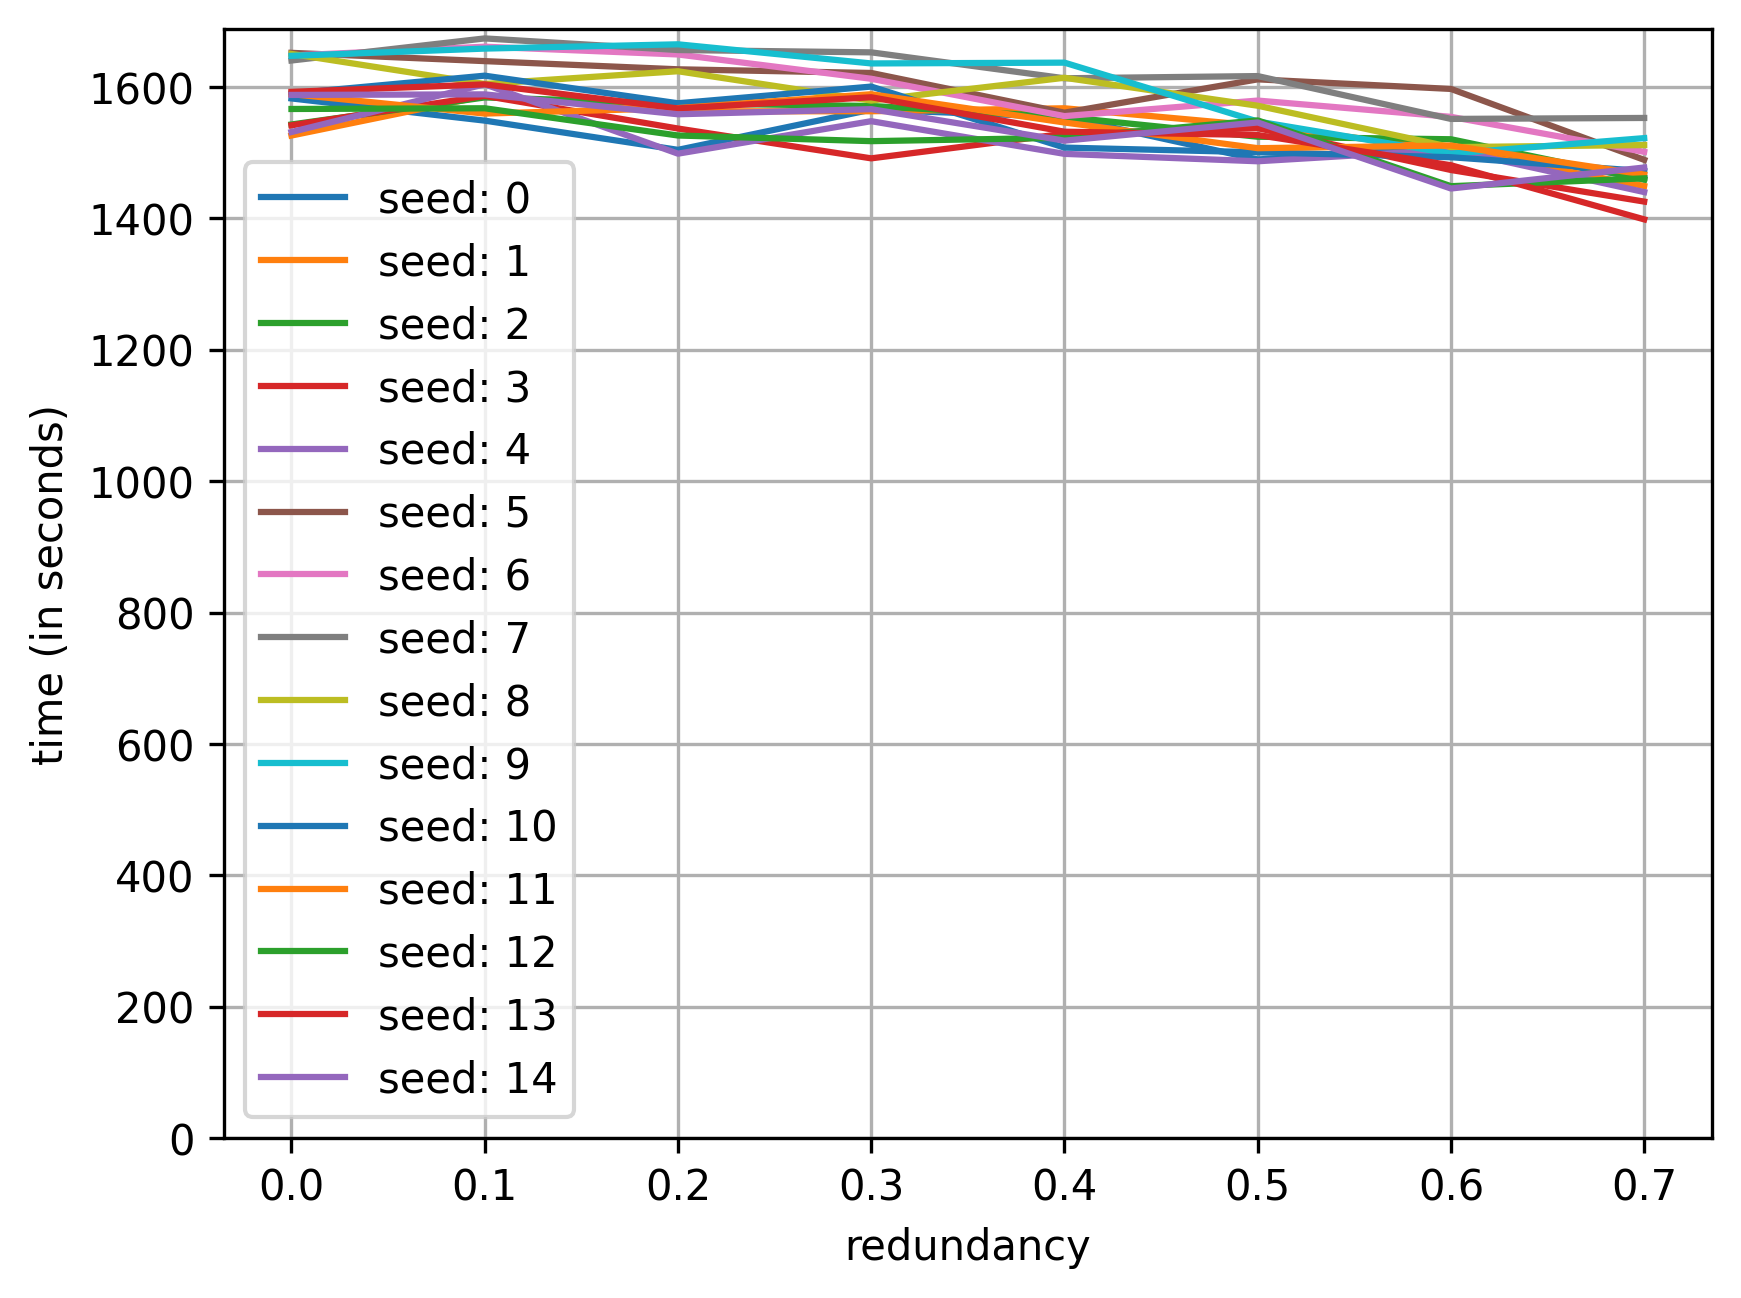

In [16]:
# plot simulation time of each seed with cache

ax = plt.subplot()

for seed in seeds:
    seed_durations_with_cache = []

    for redundancy in redundancies:

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vr_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["seed"] == seed
            and experiment["params"]["redundancy"] == redundancy
        ]

        assert len(sel_durations_no_cache) == 1, "Too many results for one seed value!"

        seed_durations_with_cache.append(sel_durations_with_cache[0])

    ax.plot(redundancies, seed_durations_with_cache, label=f"seed: {seed}")

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Total simulation time with caching enabled:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/total_time_over_redundancy_enabled_by_seed.png")
plt.show()

Cache buildup and net simulation time, averaged across seeds:


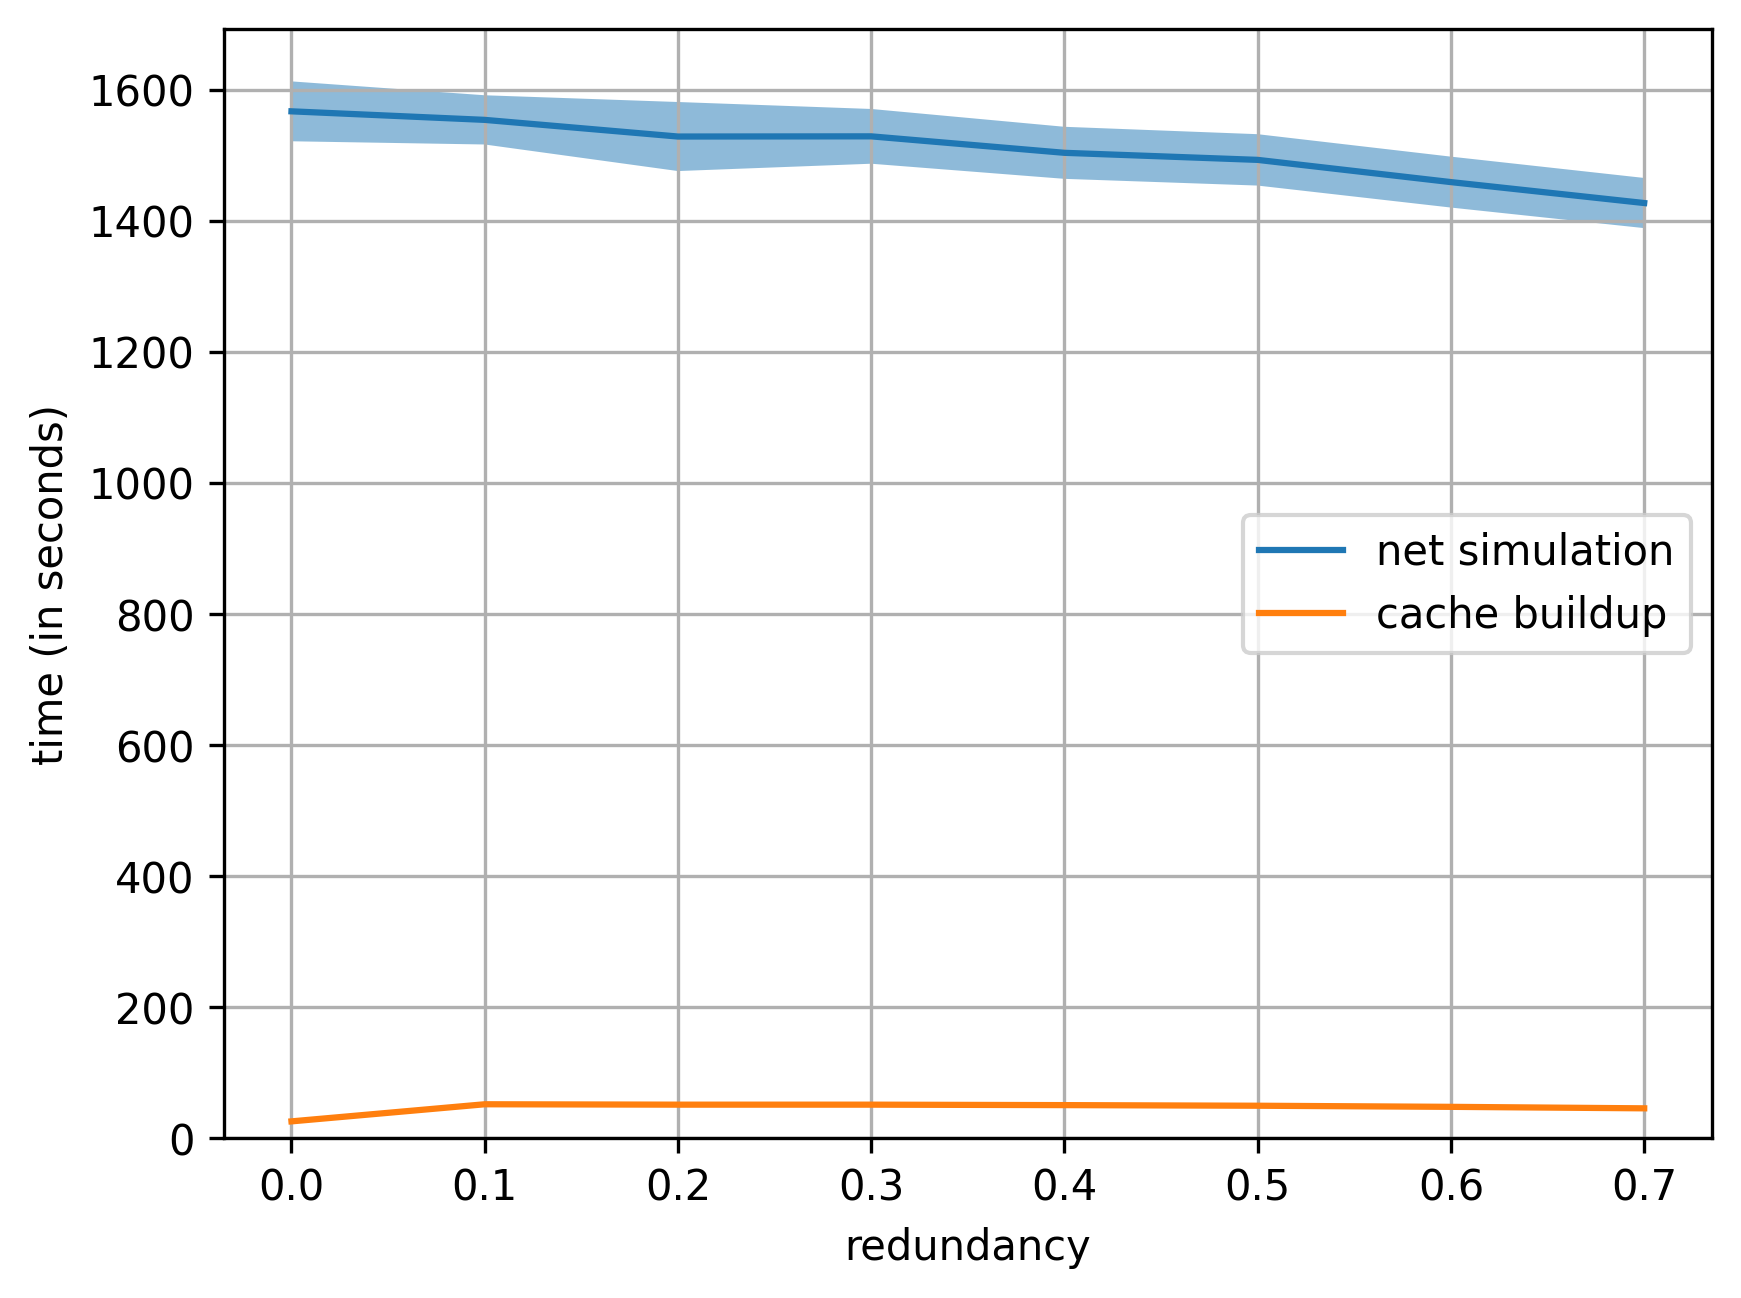

In [17]:
# Create a line chart with simulation vs. preparation time of 
# caching enabled.
simulation_durations = []
simulation_duration_stdevs = []
overhead_durations = []
overhead_durations_stdevs = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_simulation_durations = [
        experiment["simulate_using_cache"]["duration"]
        for experiment in relevant_experiments
    ]
    sel_overhead_durations = [
        experiment["total_duration"] - experiment["simulate_using_cache"]["duration"]
        for experiment in relevant_experiments
    ]

    simulation_durations.append(mean(sel_simulation_durations))
    simulation_duration_stdevs.append(stdev(sel_simulation_durations))

    overhead_durations.append(mean(sel_overhead_durations))
    overhead_durations_stdevs.append(stdev(sel_overhead_durations))


ax = plt.subplot()

ax.plot(redundancies, simulation_durations, label="net simulation")

lower_bounds_simulation = [
    duration - sigma for (duration, sigma) in zip(simulation_durations, simulation_duration_stdevs)
]
upper_bounds_simulation = [
    duration + sigma for (duration, sigma) in zip(simulation_durations, simulation_duration_stdevs)
]
ax.fill_between(
    redundancies, lower_bounds_simulation, upper_bounds_simulation, alpha=0.5
)

ax.plot(redundancies, overhead_durations, label="cache buildup")

lower_bounds_overhead = [
    duration - sigma for (duration, sigma) in zip(overhead_durations, overhead_durations_stdevs)
]
upper_bounds_overhead = [
    duration + sigma for (duration, sigma) in zip(overhead_durations, overhead_durations_stdevs)
]
ax.fill_between(
    redundancies, lower_bounds_overhead, upper_bounds_overhead, alpha=0.5
)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Cache buildup and net simulation time, averaged across seeds:")
plt.legend()
plt.grid()

plt.savefig(f"{target_dir}/net_time_vs_cache_buildup.png")
plt.show()

Trie lookup duration, averaged across seeds:


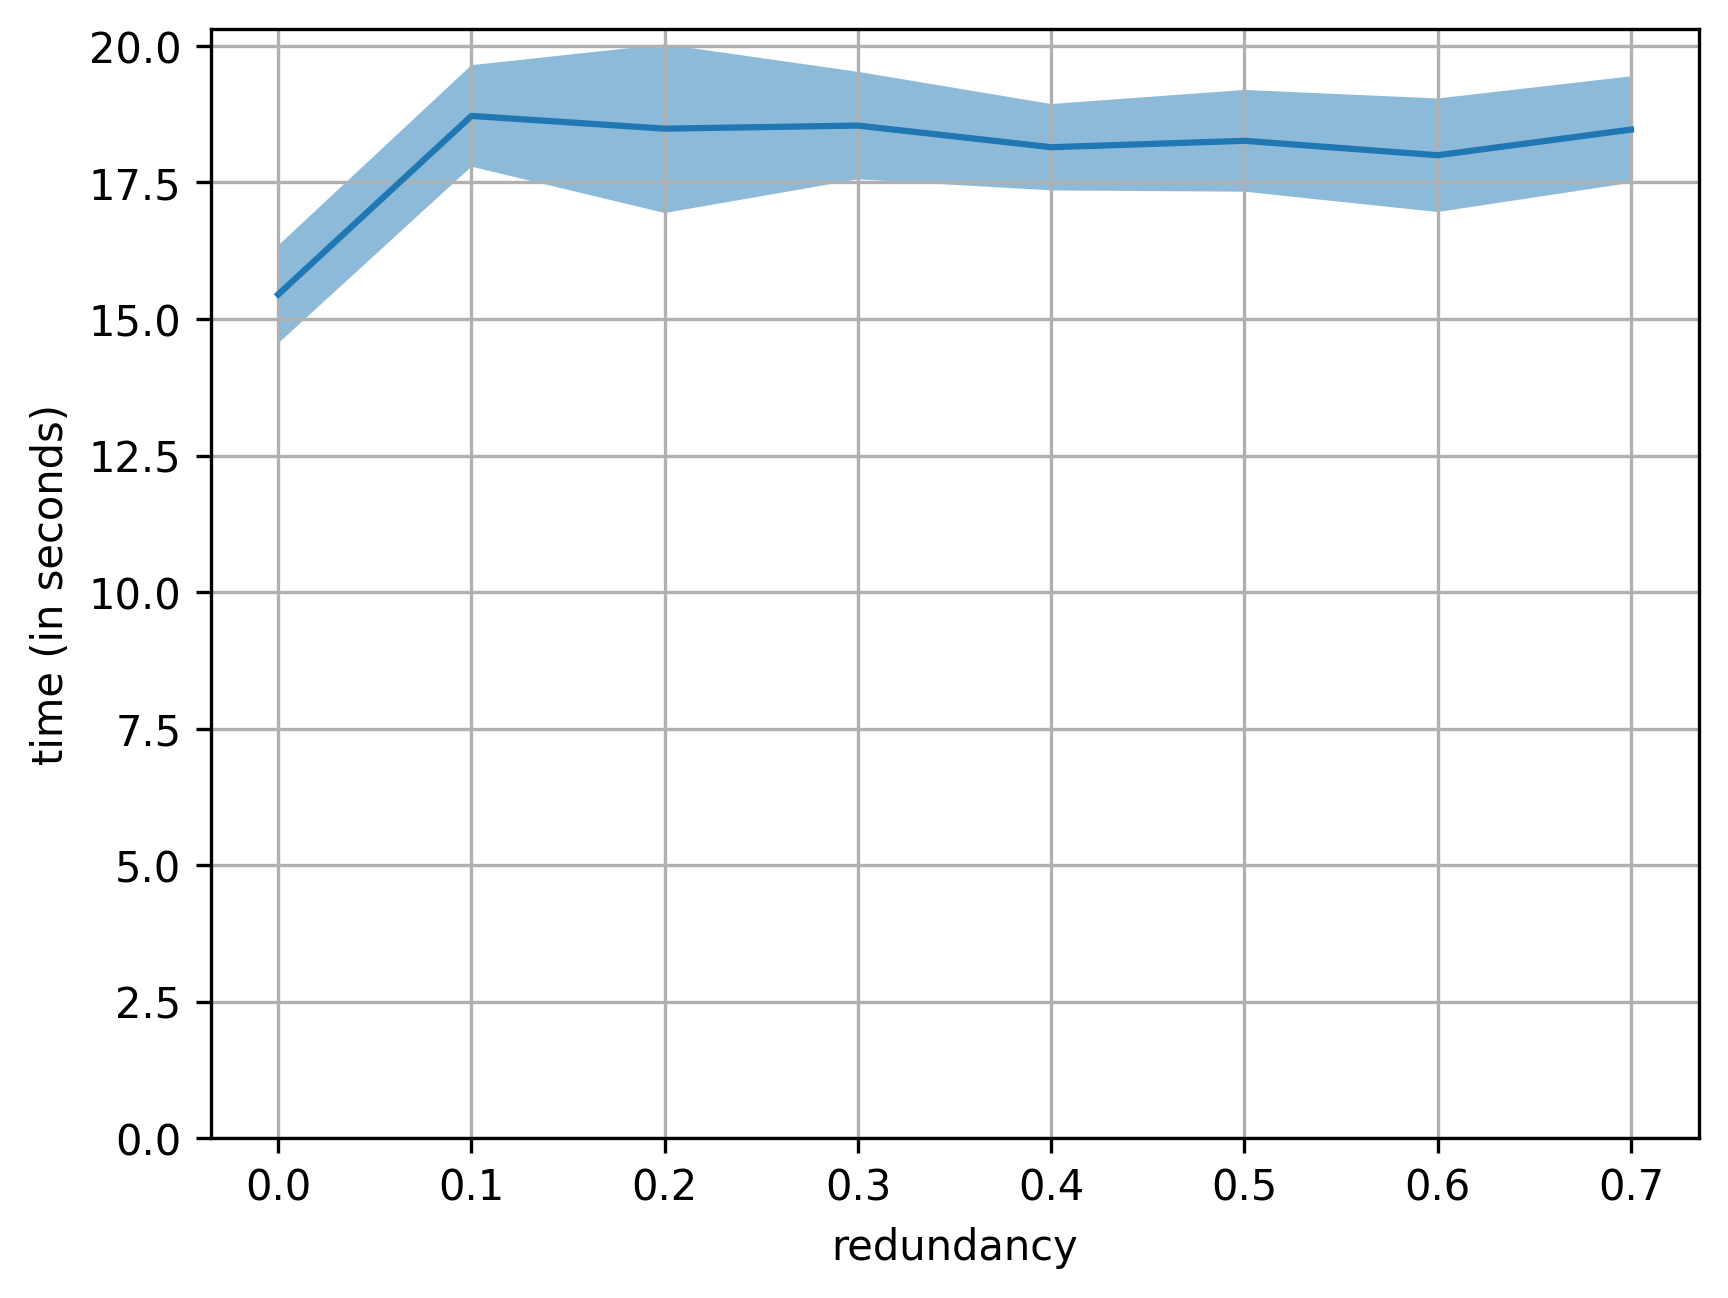

In [18]:
# Plot trie lookup durations averaged across seeds

trie_lookup_durations = []
trie_lookup_stdevs = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_trie_lookup_durations = [
        experiment["simulate_using_cache"]["trie_lookup_duration"]
        for experiment in relevant_experiments
    ]

    trie_lookup_durations.append(mean(sel_trie_lookup_durations))
    trie_lookup_stdevs.append(stdev(sel_trie_lookup_durations))


ax = plt.subplot()
ax.plot(redundancies, trie_lookup_durations)

lower_bounds_trie_lookup = [
    duration - sigma for (duration, sigma) in zip(trie_lookup_durations, trie_lookup_stdevs)
]
upper_bounds_trie_lookup = [
    duration + sigma for (duration, sigma) in zip(trie_lookup_durations, trie_lookup_stdevs)
]
ax.fill_between(
    redundancies, lower_bounds_trie_lookup, upper_bounds_trie_lookup, alpha=0.5
)

ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Trie lookup duration, averaged across seeds:")
plt.grid()
plt.show()

Net simulation duration without trie lookup, averaged across seeds:


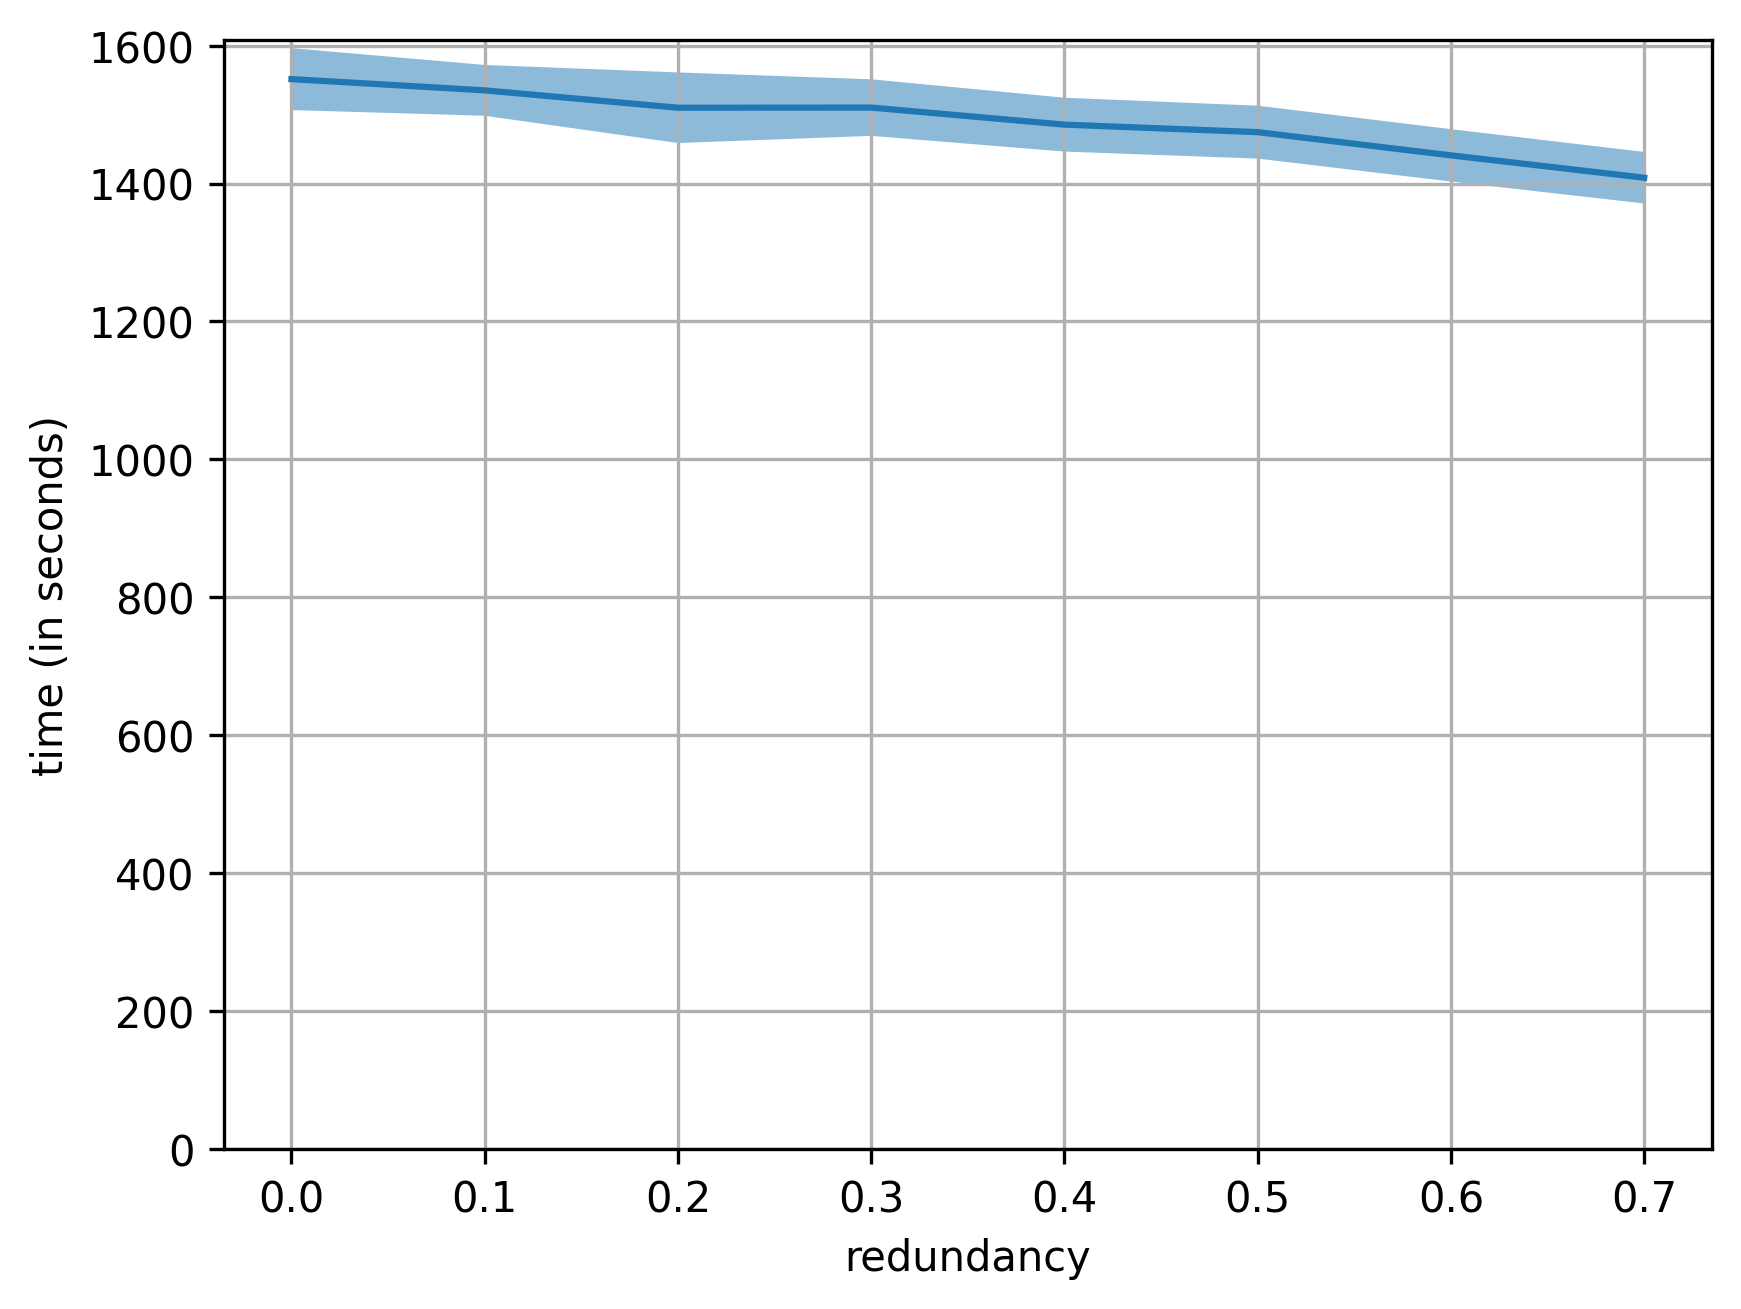

In [19]:
# Create a line chart with simulation vs. preparation time of 
# caching enabled.

simulation_durations = []
simulation_stdevs = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    sel_simulation_durations = [
        experiment["simulate_using_cache"]["duration"] - experiment["simulate_using_cache"]["trie_lookup_duration"]
        for experiment in relevant_experiments
    ]

    simulation_durations.append(mean(sel_simulation_durations))
    simulation_stdevs.append(stdev(sel_simulation_durations))


ax = plt.subplot()
ax.plot(redundancies, simulation_durations)

lower_bounds_simulation_duration = [
    duration - sigma for (duration, sigma) in zip(simulation_durations, simulation_stdevs)
]
upper_bounds_simulation_duration = [
    duration + sigma for (duration, sigma) in zip(simulation_durations, simulation_stdevs)
]
ax.fill_between(
    redundancies, lower_bounds_simulation_duration, upper_bounds_simulation_duration, alpha=0.5
)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")
ax.set_ylim(0)

printb("Net simulation duration without trie lookup, averaged across seeds:")
plt.grid()
plt.show()

Time distribution when caching is enabled:


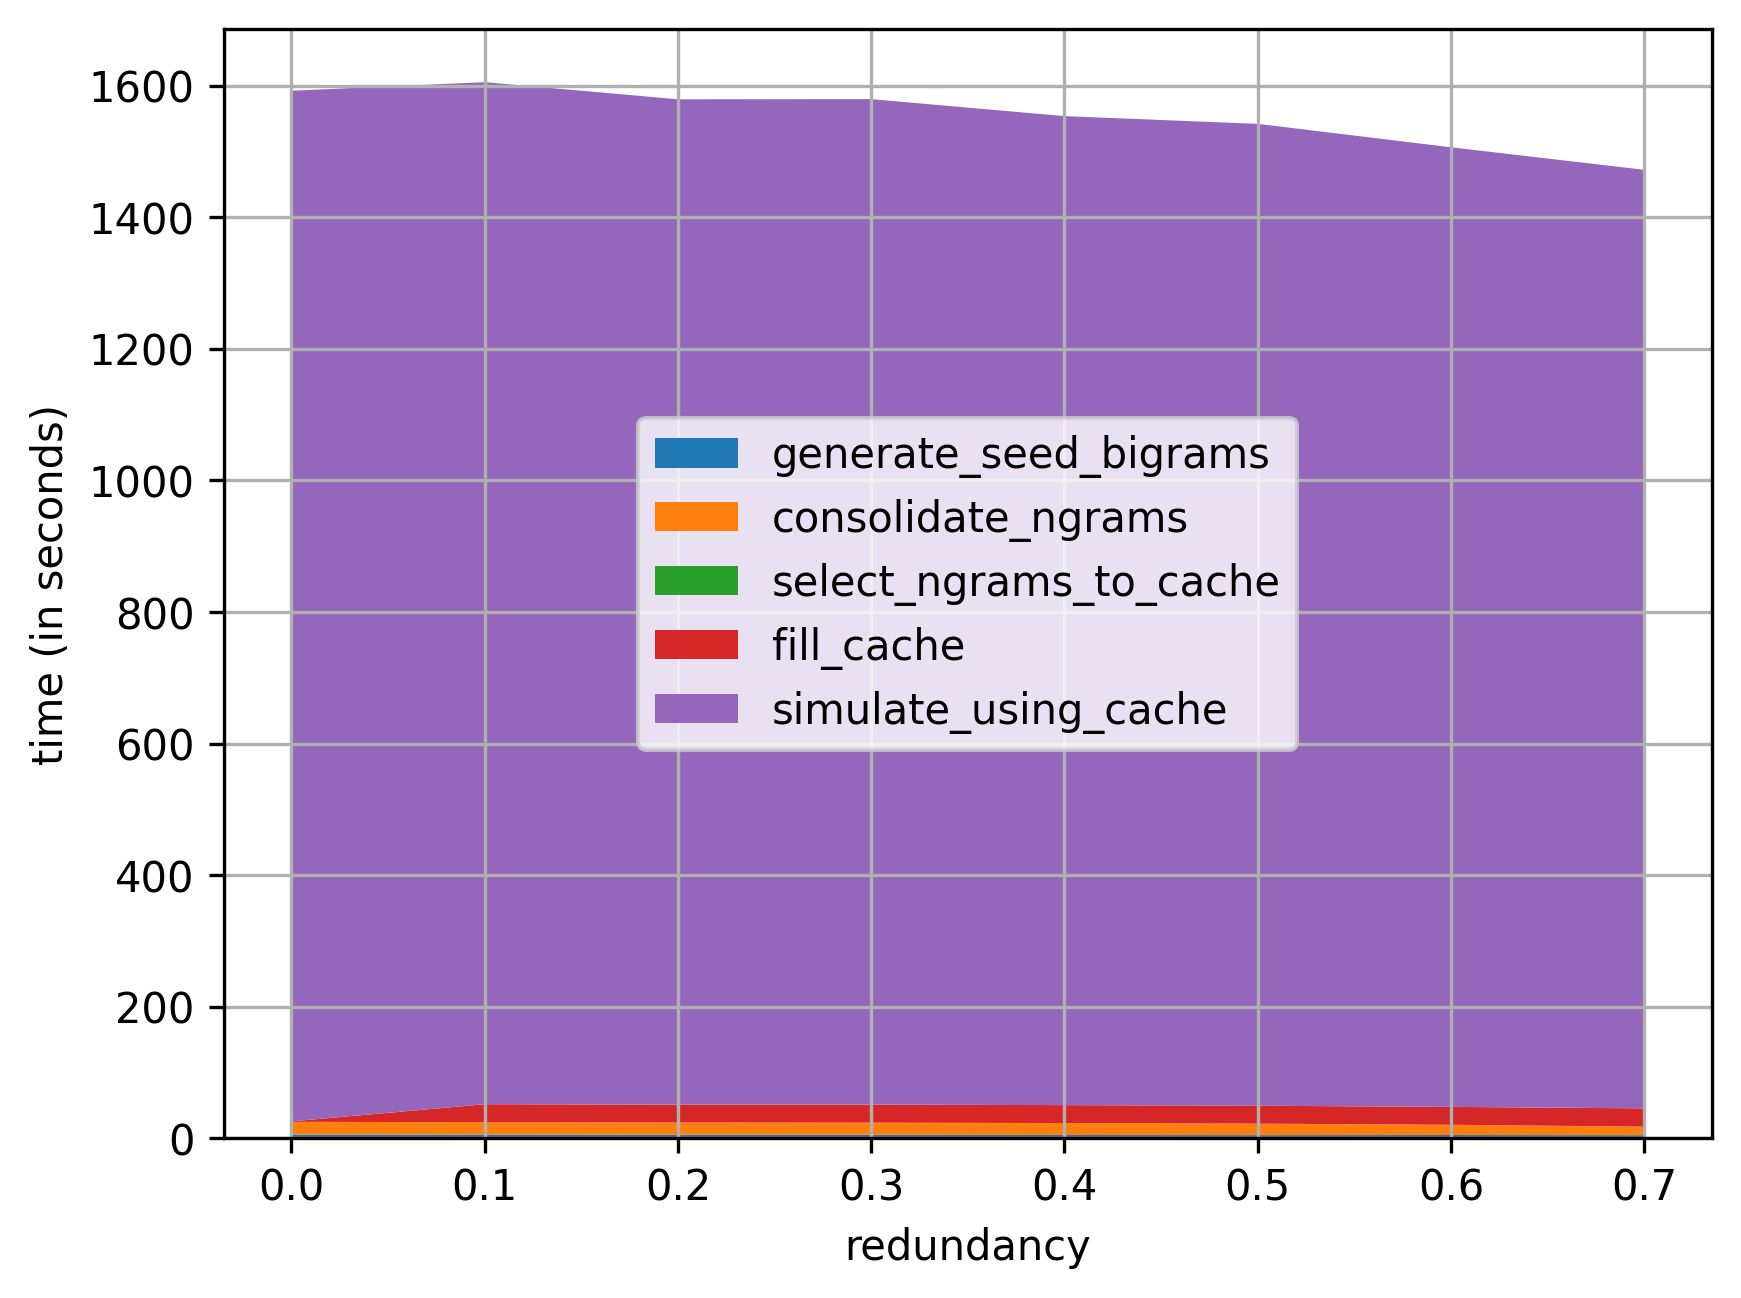

In [20]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

generate_seed_bigrams_durations = []
consolidate_ngrams_durations = []
select_ngrams_to_cache_durations = []
fill_cache_durations = []
simulate_using_cache_durations = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    generate_seed_bigrams_durations.append(
        mean(
            [
                experiment["generate_seed_bigrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    consolidate_ngrams_durations.append(
        mean(
            [
                experiment["consolidate_ngrams"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    select_ngrams_to_cache_durations.append(
        mean(
            [
                experiment["select_ngrams_to_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    fill_cache_durations.append(
        mean(
            [
                experiment["fill_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )
    simulate_using_cache_durations.append(
        mean(
            [
                experiment["simulate_using_cache"]["duration"]
                for experiment in relevant_experiments
            ]
        )
    )

x = redundancies
y = np.vstack(
    [
        generate_seed_bigrams_durations,
        consolidate_ngrams_durations,
        select_ngrams_to_cache_durations,
        fill_cache_durations,
        simulate_using_cache_durations,
    ],
)

fig, ax = plt.subplots()

ax.stackplot(x, y)
ax.set_xlabel("redundancy")
ax.set_ylabel("time (in seconds)")

plt.legend(
    [
        "generate_seed_bigrams",
        "consolidate_ngrams",
        "select_ngrams_to_cache",
        "fill_cache",
        "simulate_using_cache",
    ]
)
plt.grid()

printb("Time distribution when caching is enabled:")
plt.savefig(f"{target_dir}/time_over_redundancy_stacked.png")
plt.show()

Distribution of the length of ngrams added to the cache:


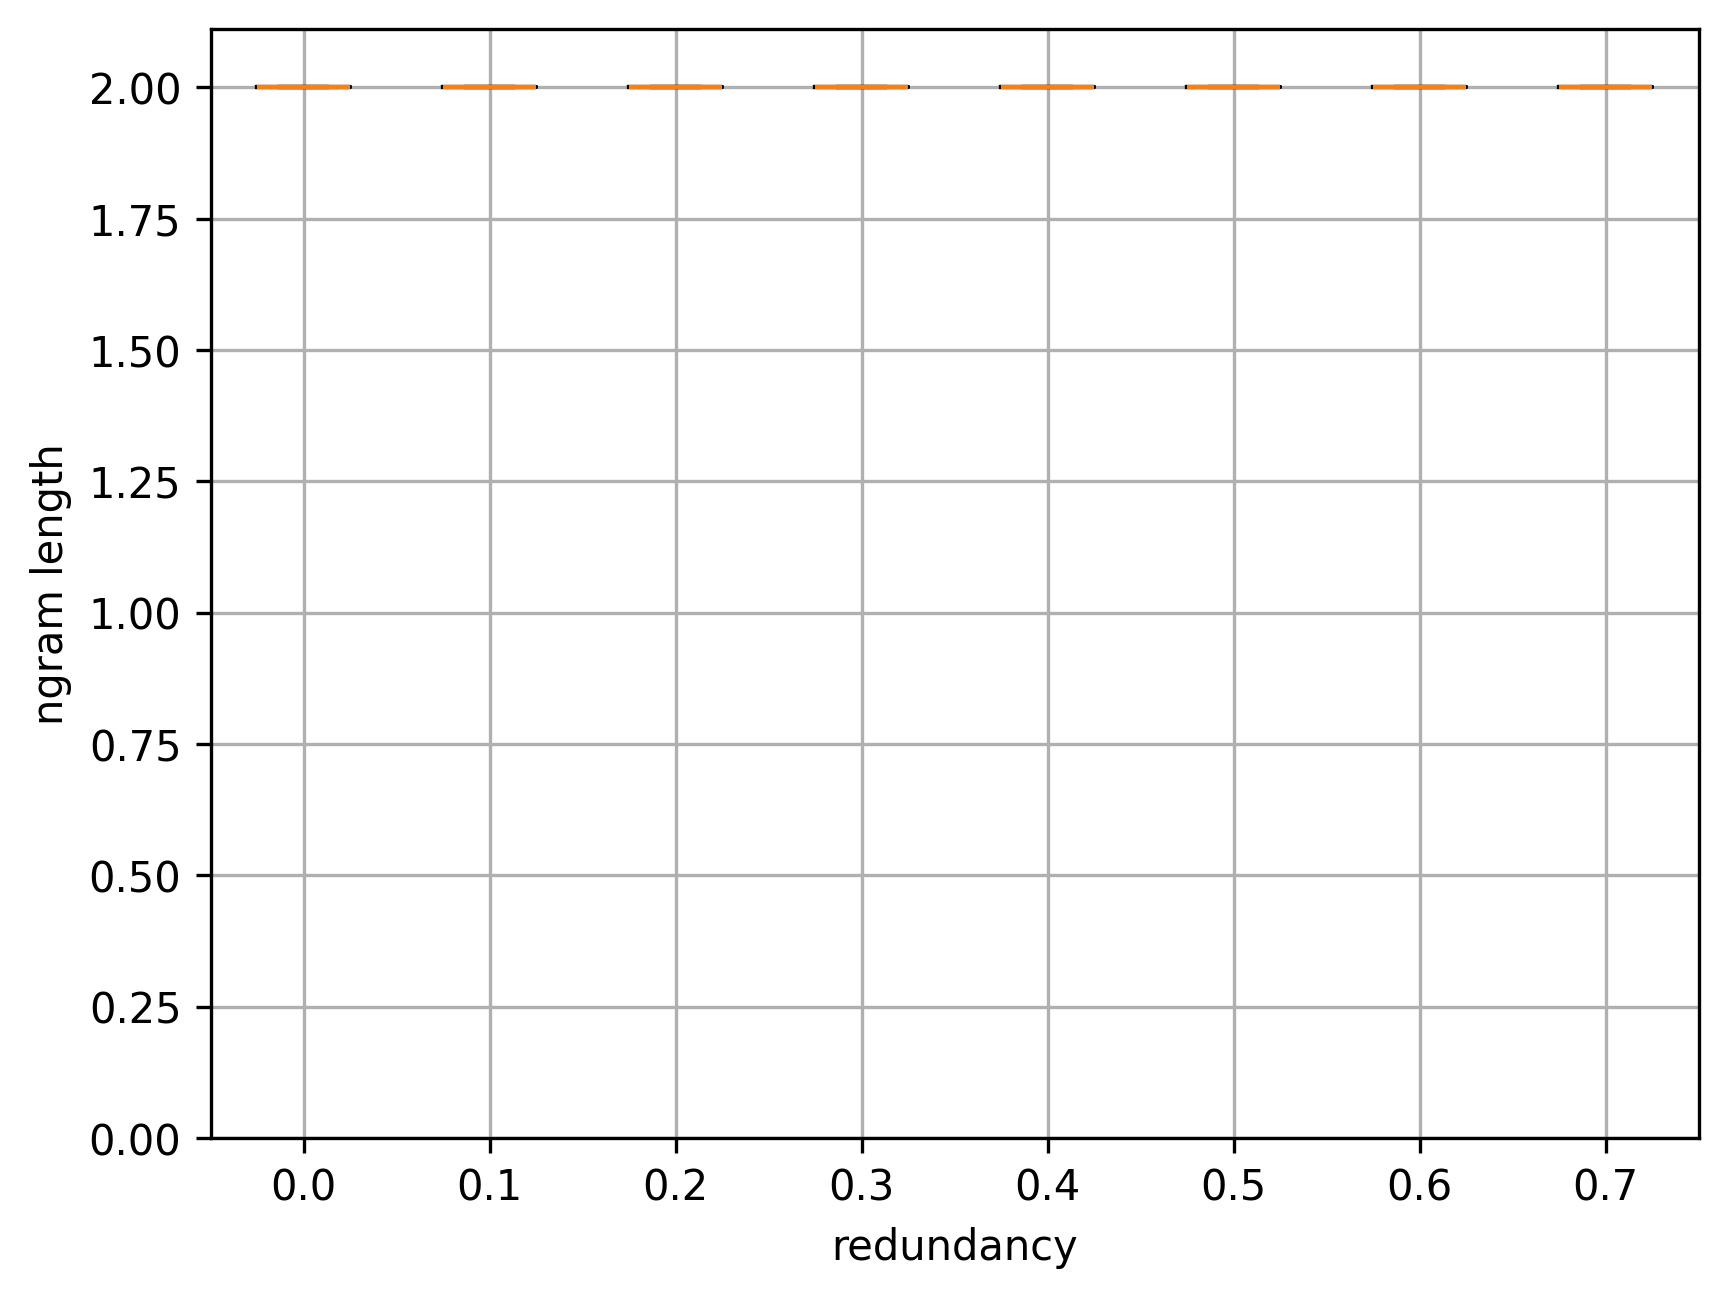

In [21]:
# Create box plots for sequence lengths of cached ngrams
# at different redundancy levels.

sequence_lengths = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] > 0 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_sequence_lengths = []
    for experiment in relevant_experiments:
        relevant_sequence_lengths.extend(experiment["fill_cache"]["ngram_lengths"])


    sequence_lengths.append(relevant_sequence_lengths)

fig, ax = plt.subplots()

ax.boxplot(sequence_lengths, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("ngram length")
ax.set_ylim(0)

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

printb("Distribution of the length of ngrams added to the cache:")

plt.grid()

plt.savefig(f"{target_dir}/ngram_length_over_redundancy.png")
plt.show()



Distribution of the frequency of each cached ngram in the population:


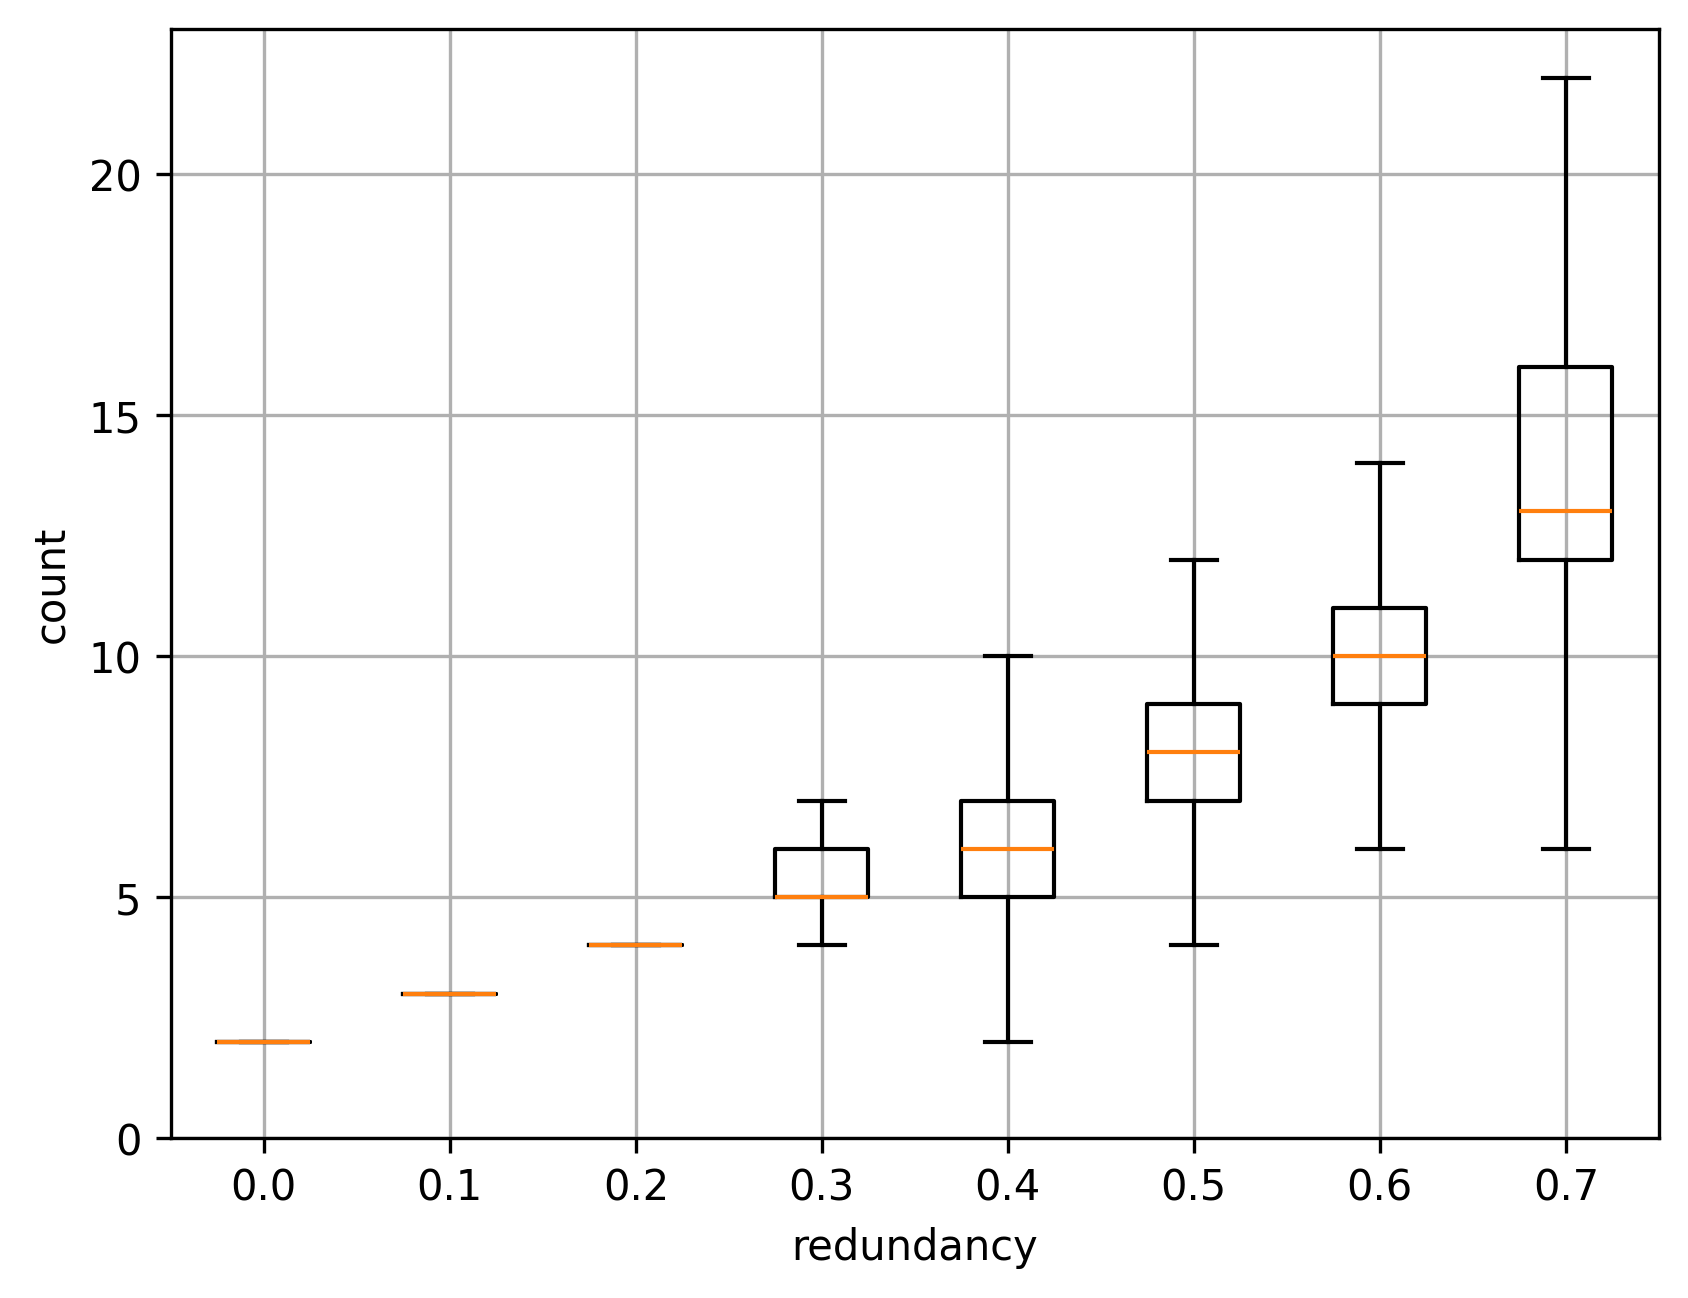

In [22]:
# Create box plots for frequency of cached ngrams at different redundancy levels.

frequencies = []

for redundancy in redundancies:

    relevant_experiments = [
        experiment for experiment in vr_experiments if 
        experiment["params"]["cache_size"] > 0 and experiment["params"]["redundancy"] == redundancy
    ]

    relevant_frequencies = []
    for experiment in relevant_experiments:
        relevant_frequencies.extend(experiment["fill_cache"]["ngram_frequencies"])


    frequencies.append(relevant_frequencies)

fig, ax = plt.subplots()

ax.boxplot(frequencies, showfliers=False)
ax.set_xlabel("redundancy")
ax.set_ylabel("count")
ax.set_ylim(0)

plt.xticks([i + 1 for i in range(len(redundancies))], redundancies)

printb("Distribution of the frequency of each cached ngram in the population:")

plt.grid()

plt.savefig(f"{target_dir}/frequency_over_redundancy.png")
plt.show()

Distribution of retrieved ngram lengths for redundancy 0.0:
	Total hit count: 5417
	Total computations saved: 6679 of 14985000 (0.04 %)
	Average cache slots used: 265 of 10000 (2.65 %)
	Share of len=2 hits: 99.45 %
	Mean hit sequence length: 2.232970278752077
	Median hit sequence length: 2


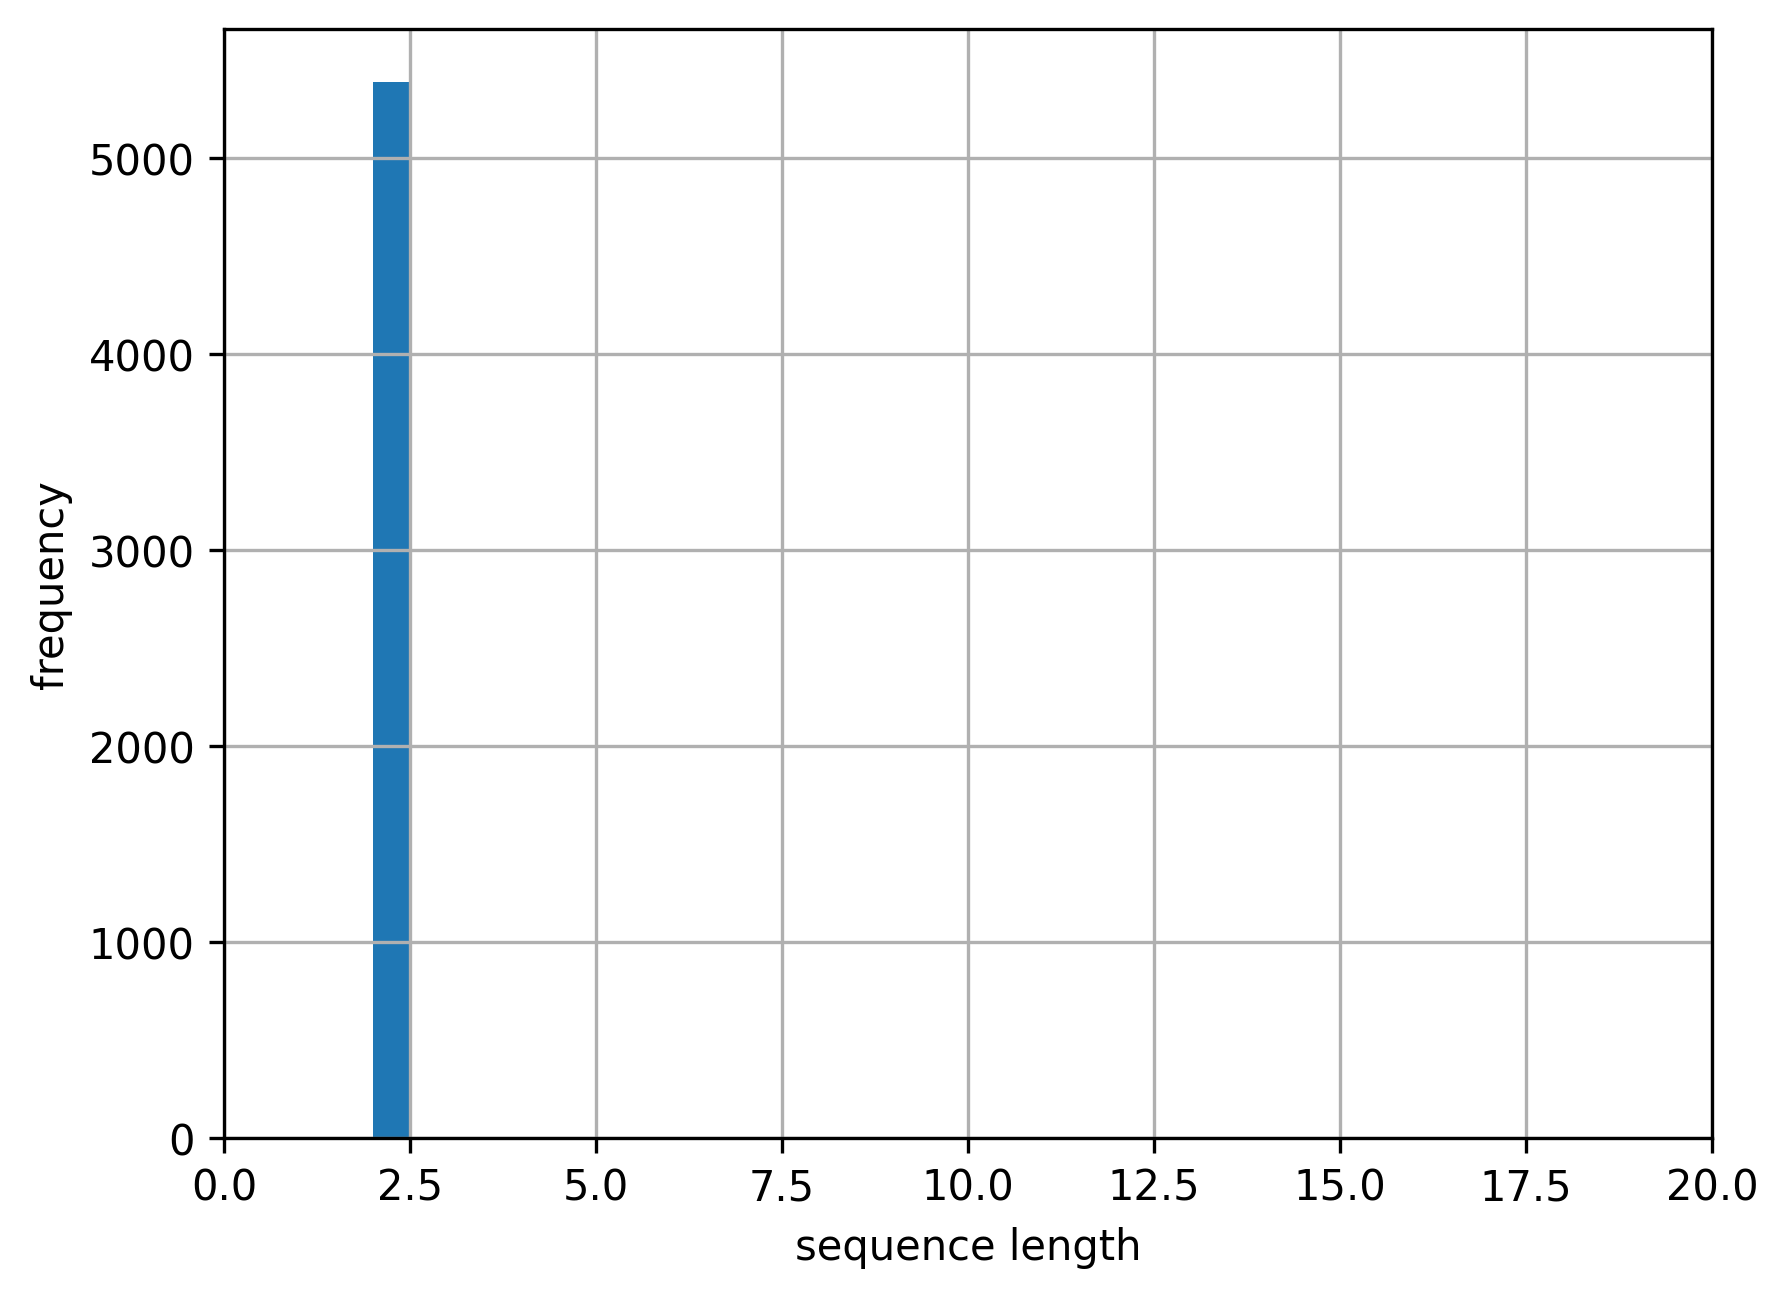

Distribution of retrieved ngram lengths for redundancy 0.1:
	Total hit count: 240810
	Total computations saved: 246149 of 14985000 (1.64 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.92 %
	Mean hit sequence length: 2.0221710061874507
	Median hit sequence length: 2.0


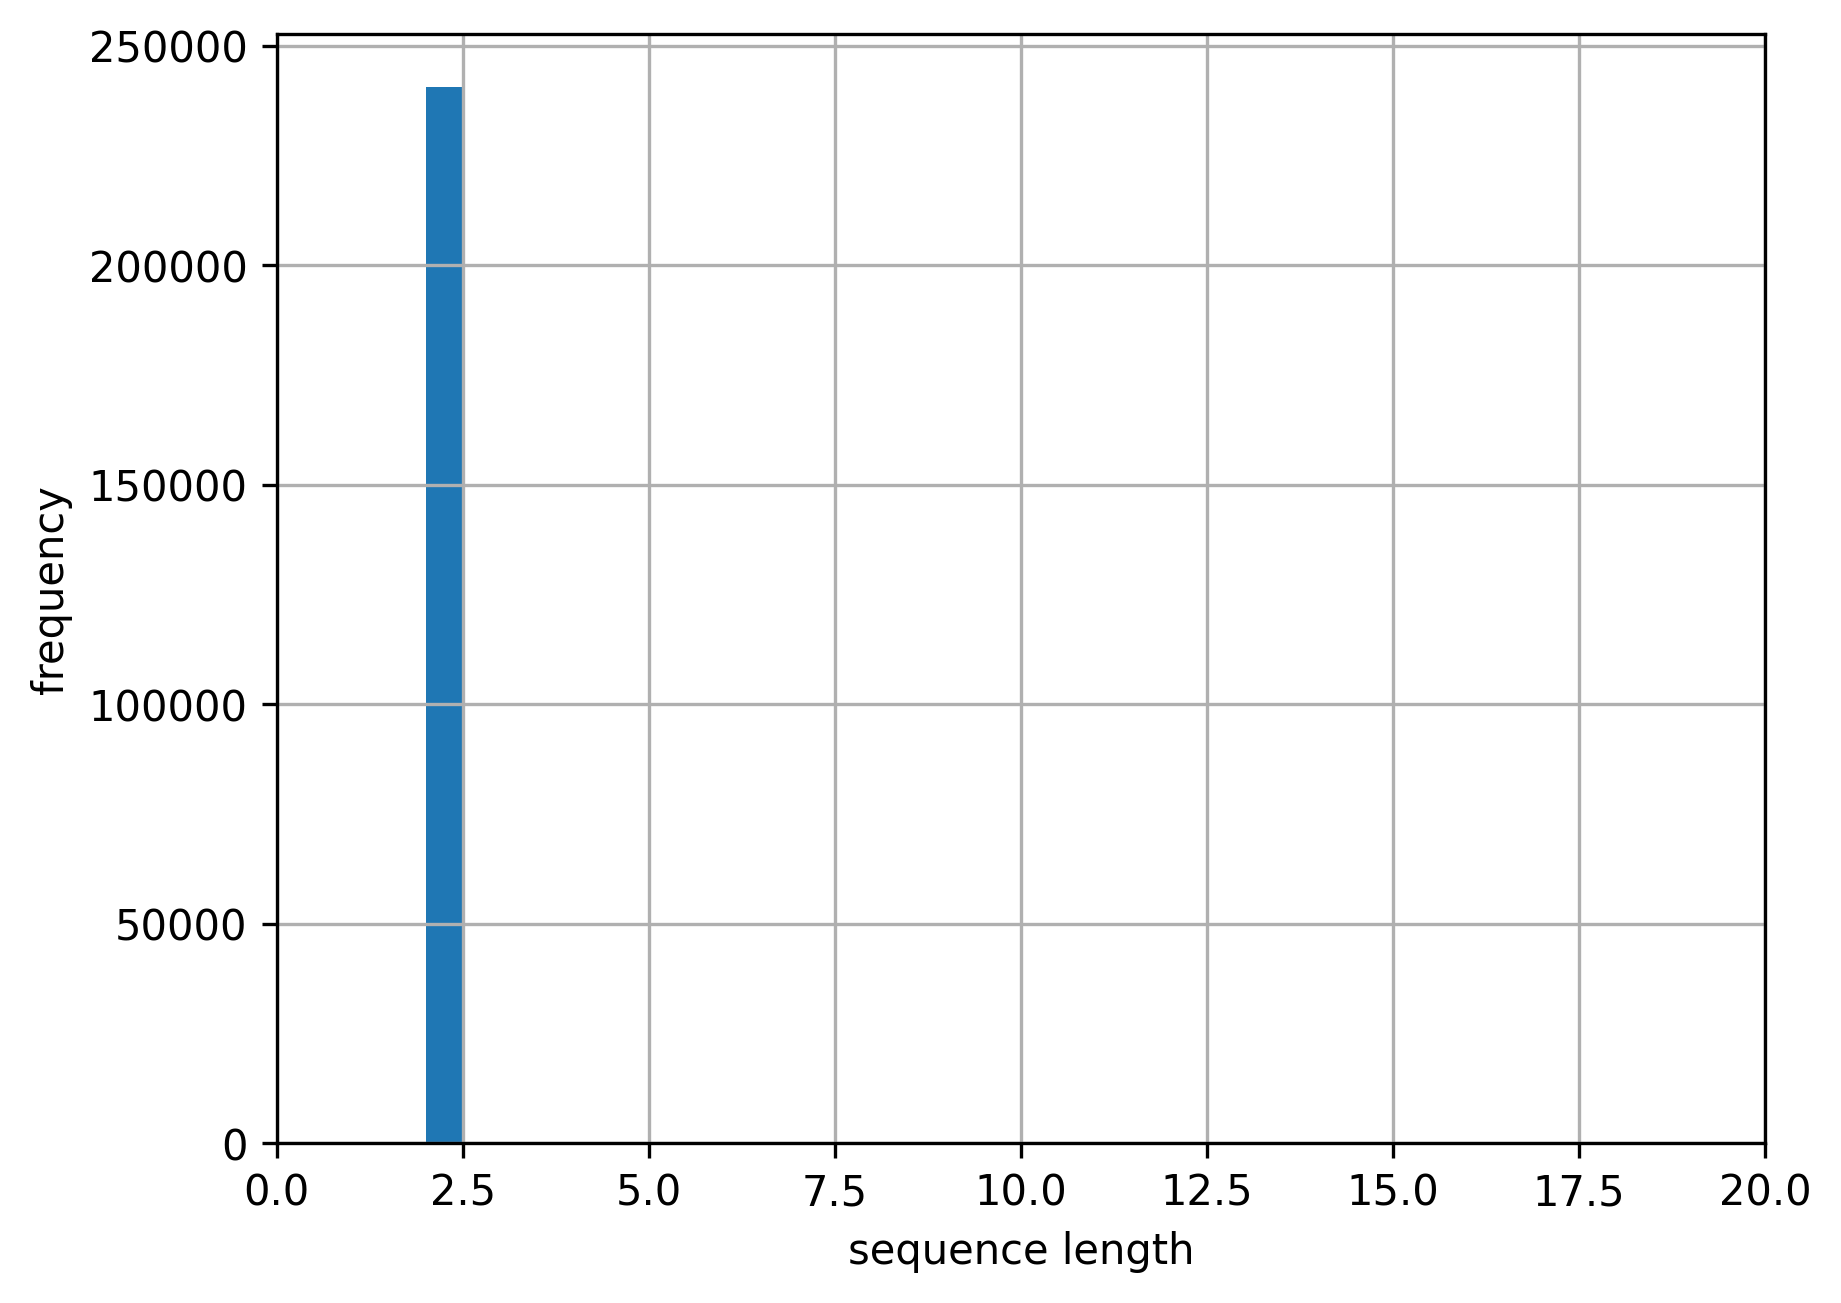

Distribution of retrieved ngram lengths for redundancy 0.2:
	Total hit count: 314118
	Total computations saved: 320962 of 14985000 (2.14 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.92 %
	Mean hit sequence length: 2.021787990500385
	Median hit sequence length: 2.0


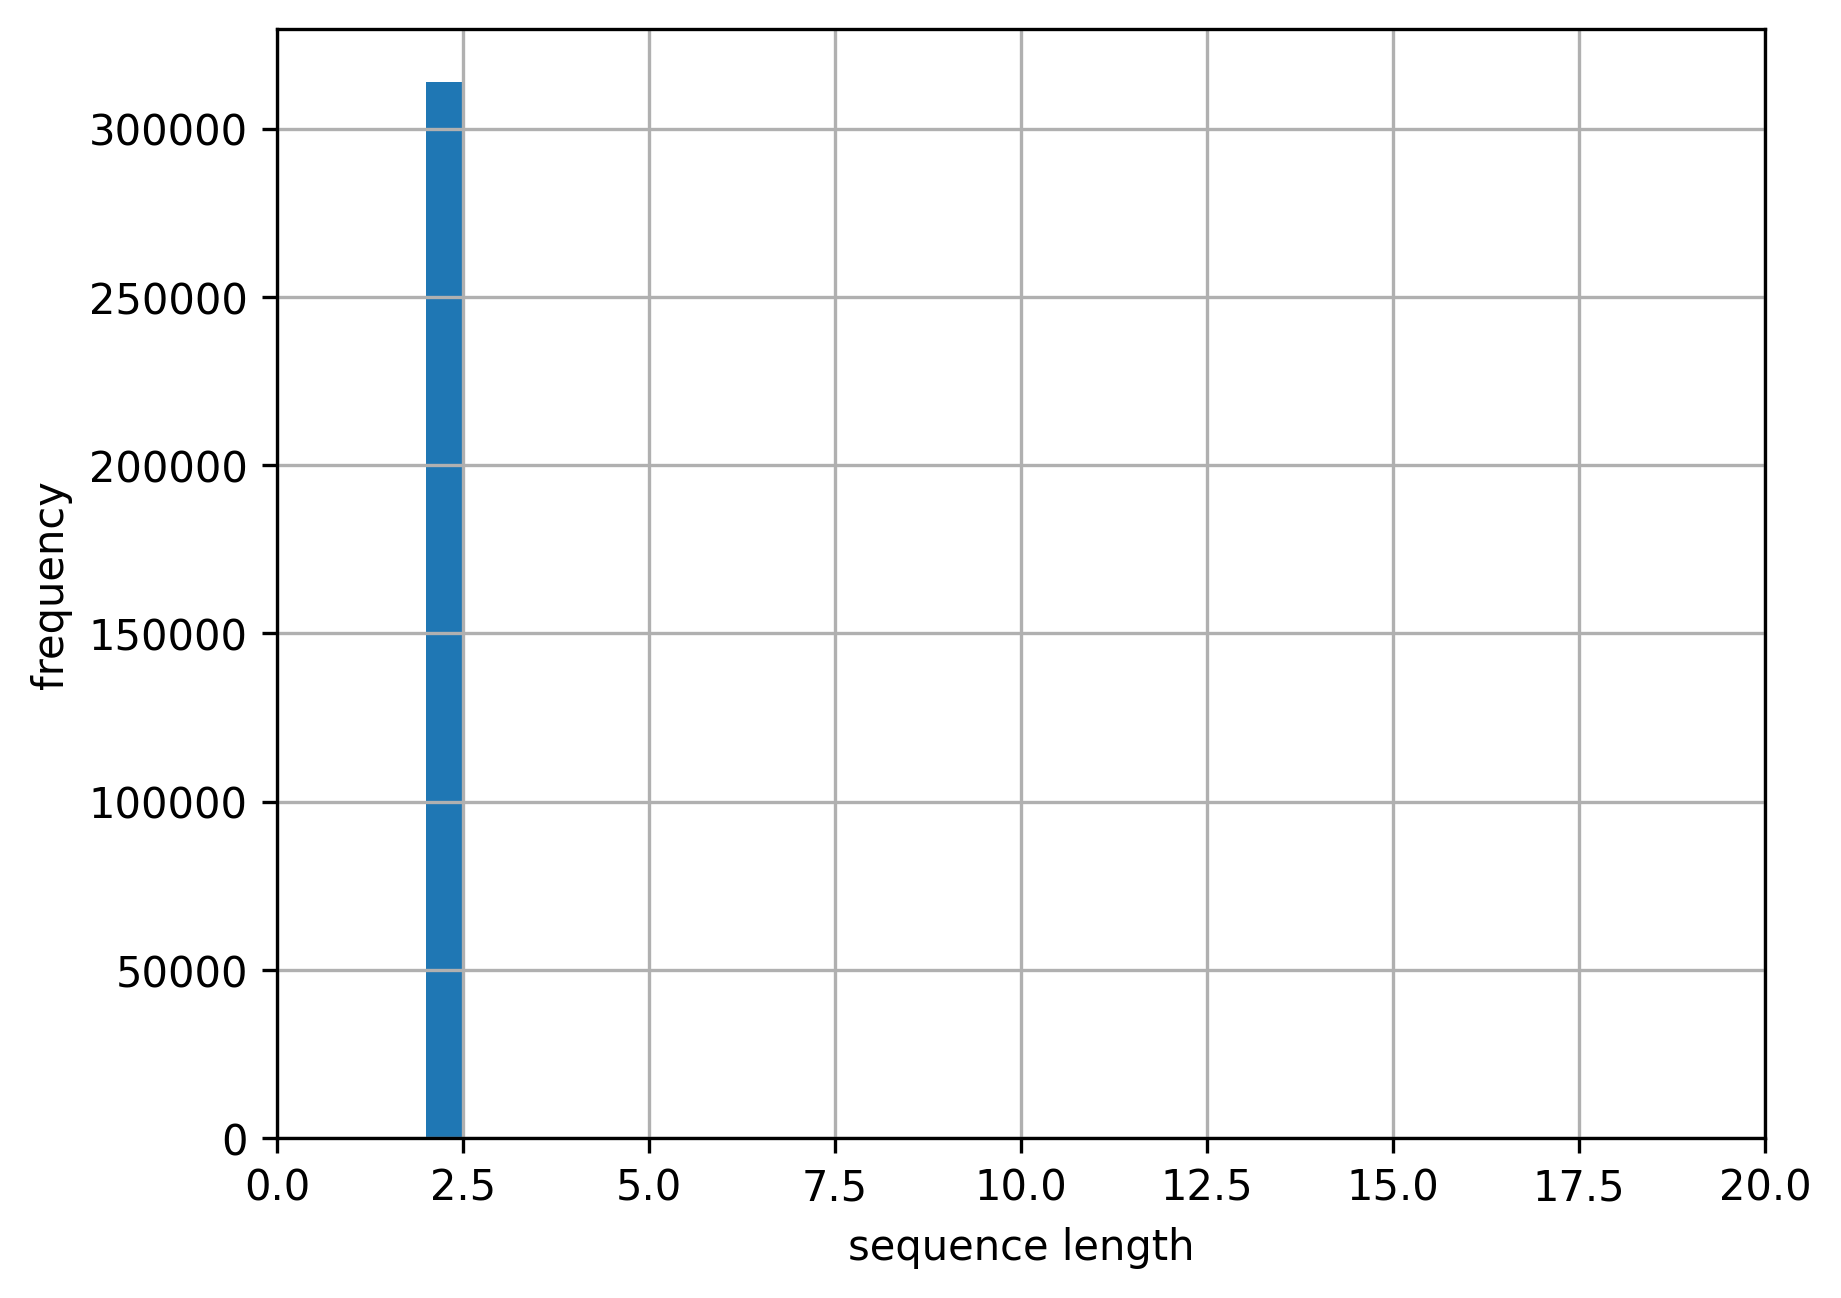

Distribution of retrieved ngram lengths for redundancy 0.3:
	Total hit count: 391364
	Total computations saved: 399290 of 14985000 (2.66 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.92 %
	Mean hit sequence length: 2.0202522459909447
	Median hit sequence length: 2.0


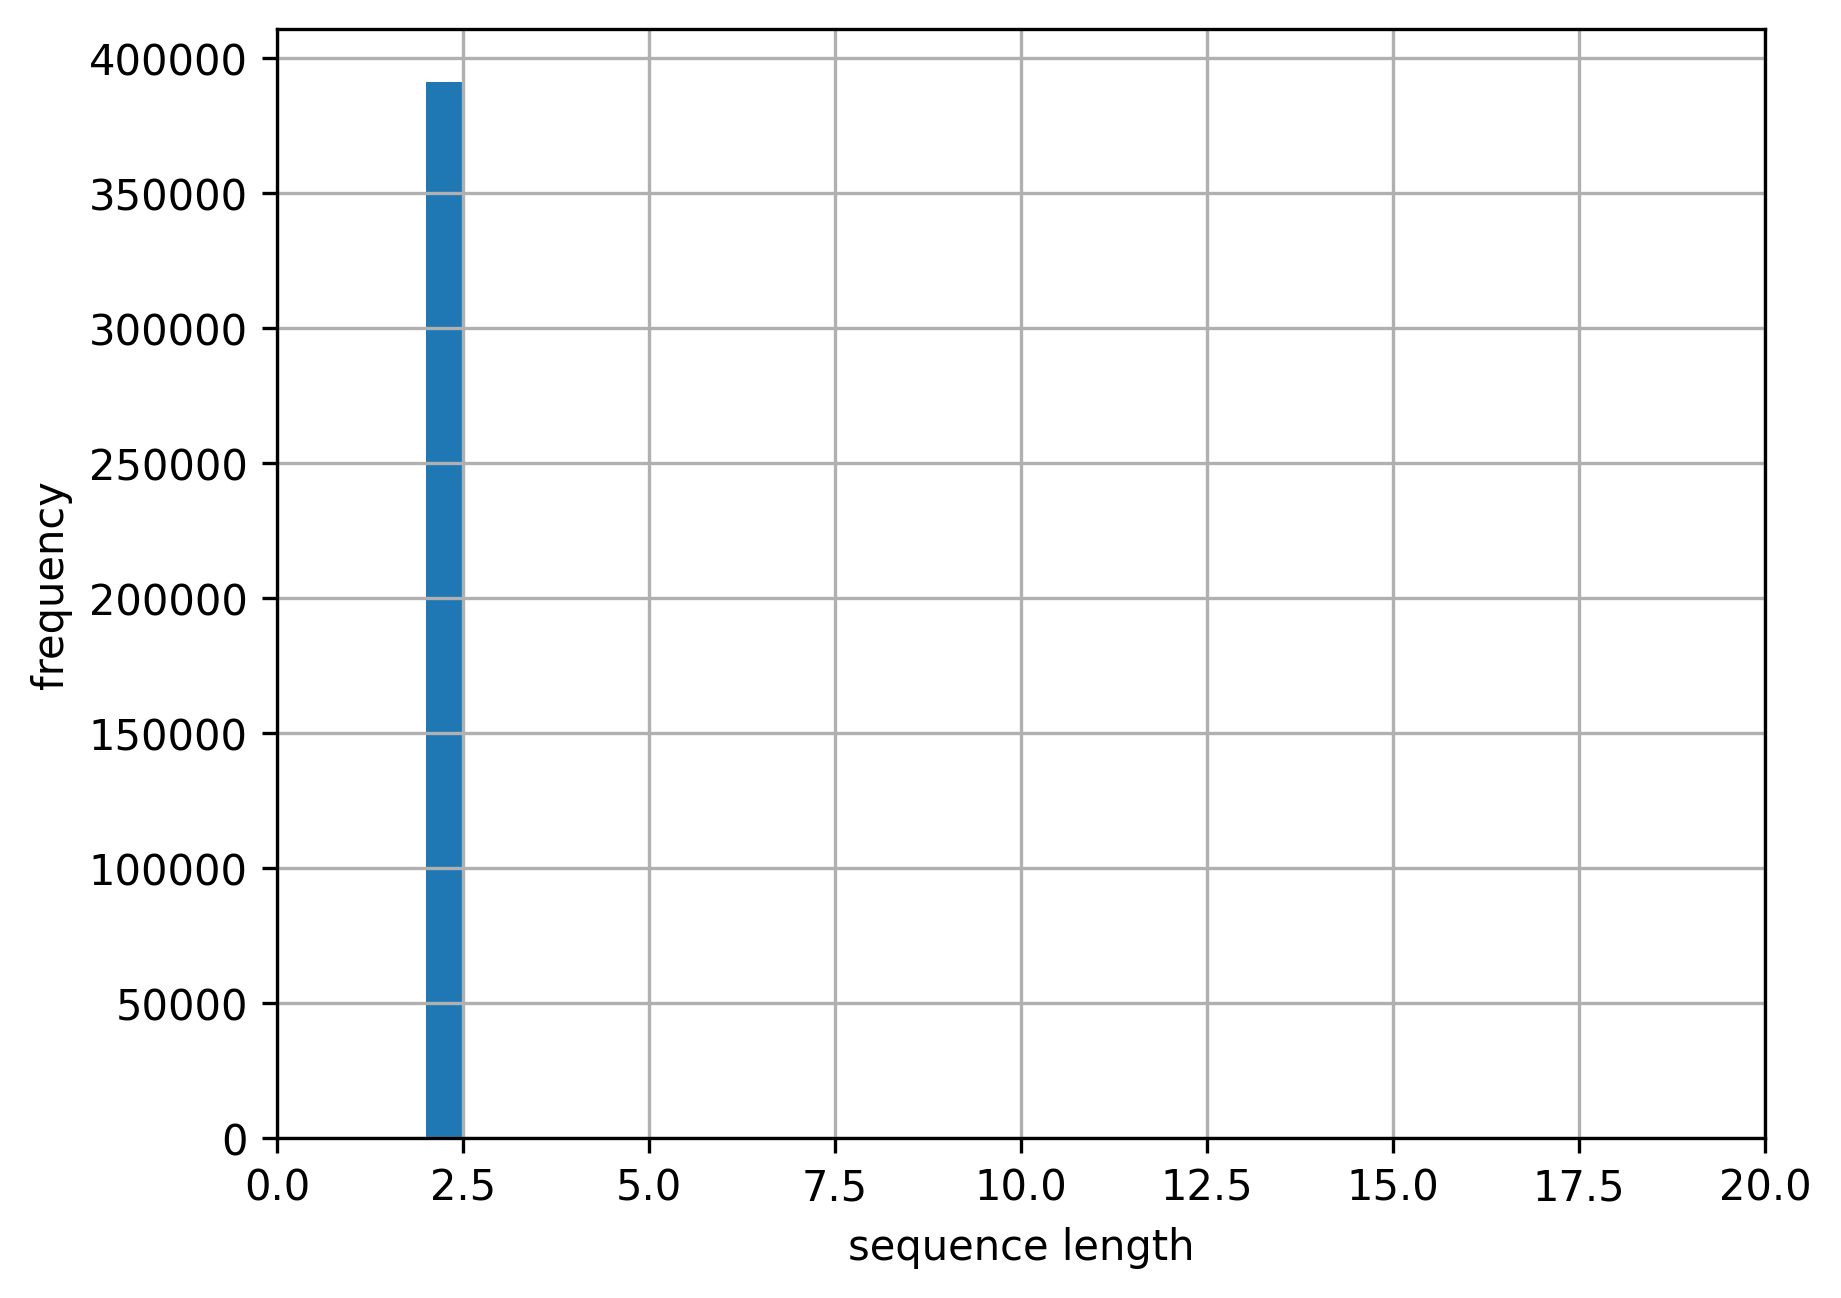

Distribution of retrieved ngram lengths for redundancy 0.4:
	Total hit count: 484869
	Total computations saved: 494653 of 14985000 (3.3 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.9 %
	Mean hit sequence length: 2.020178646191033
	Median hit sequence length: 2


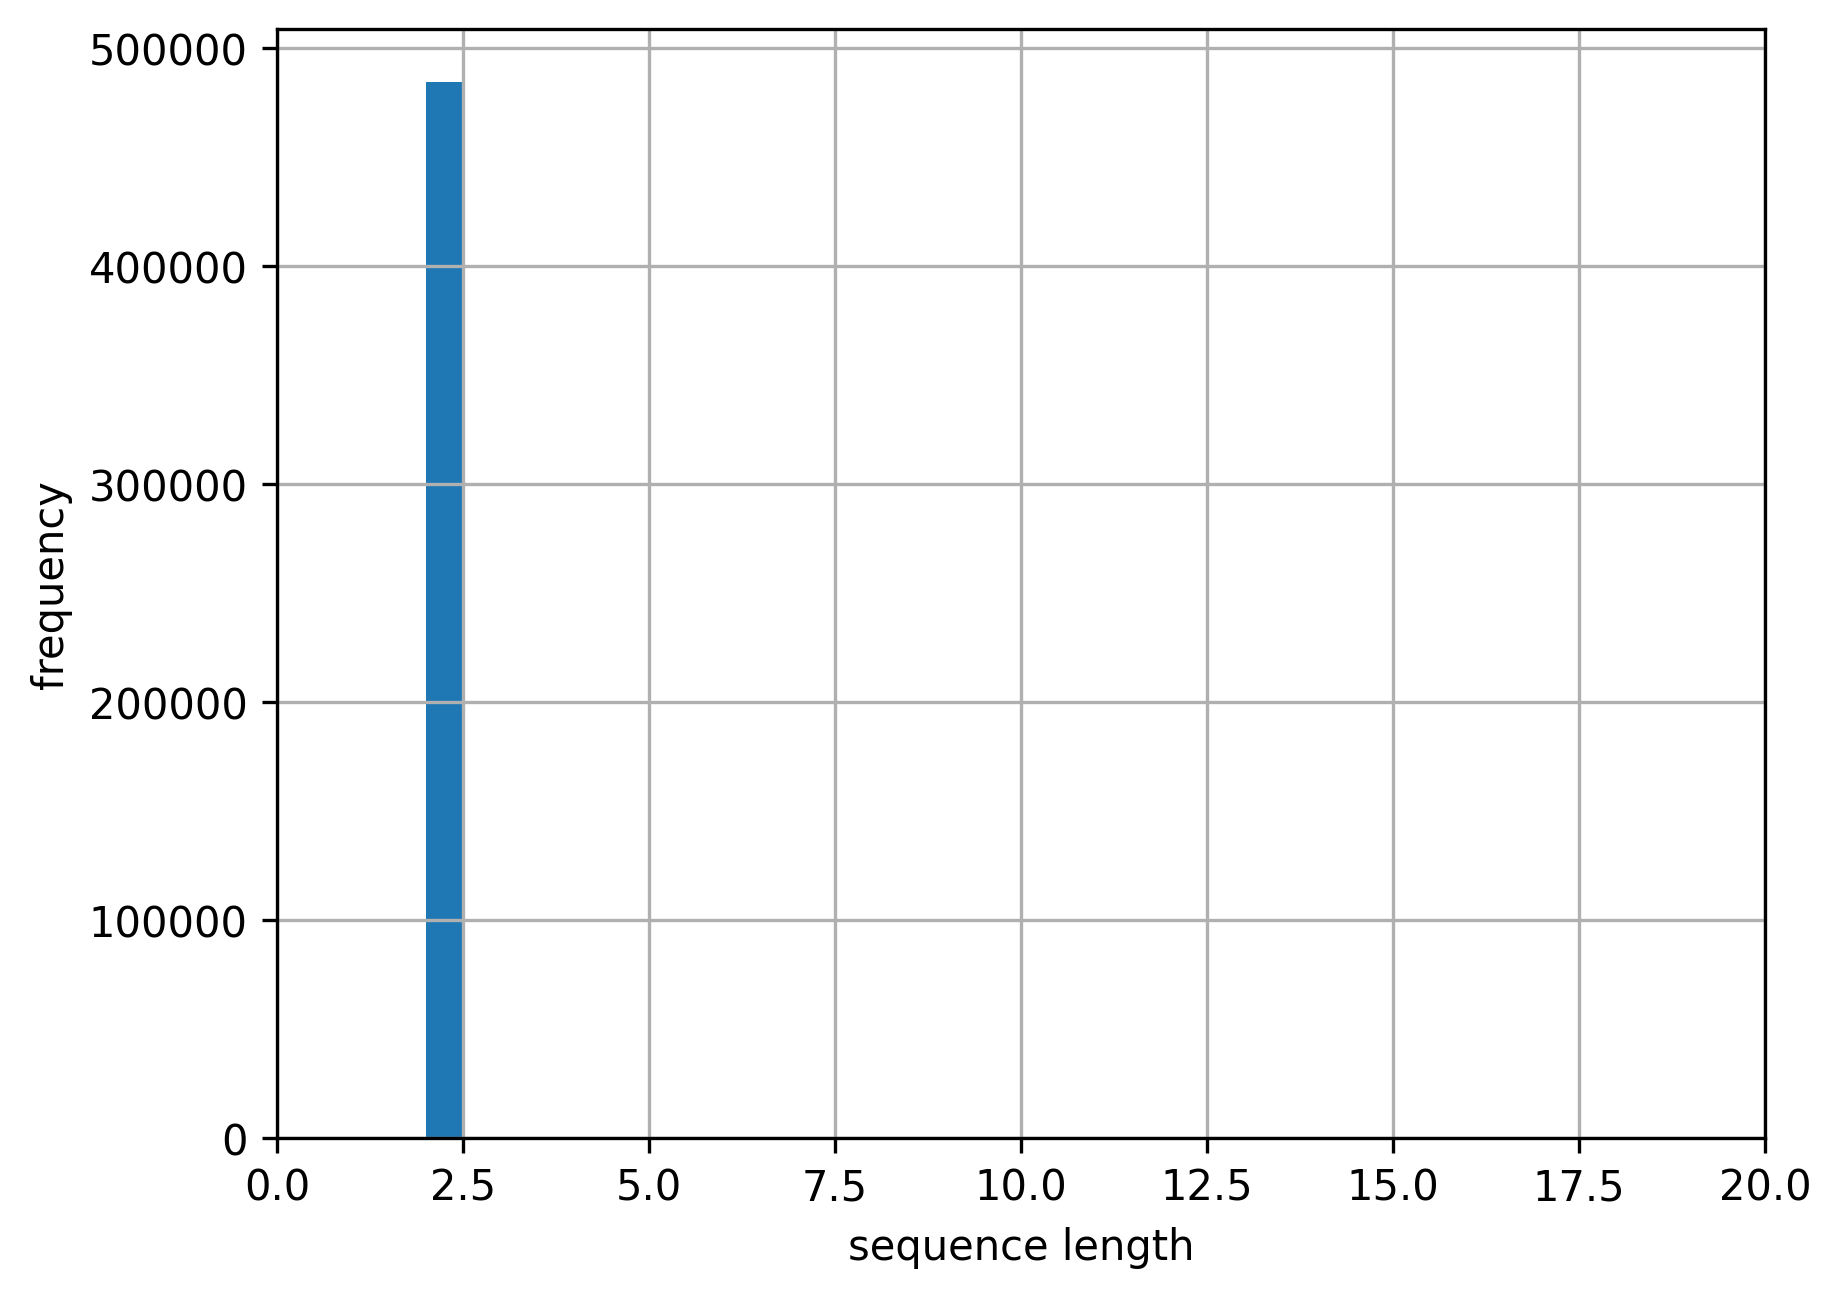

Distribution of retrieved ngram lengths for redundancy 0.5:
	Total hit count: 627050
	Total computations saved: 637070 of 14985000 (4.25 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.88 %
	Mean hit sequence length: 2.0159795869547885
	Median hit sequence length: 2.0


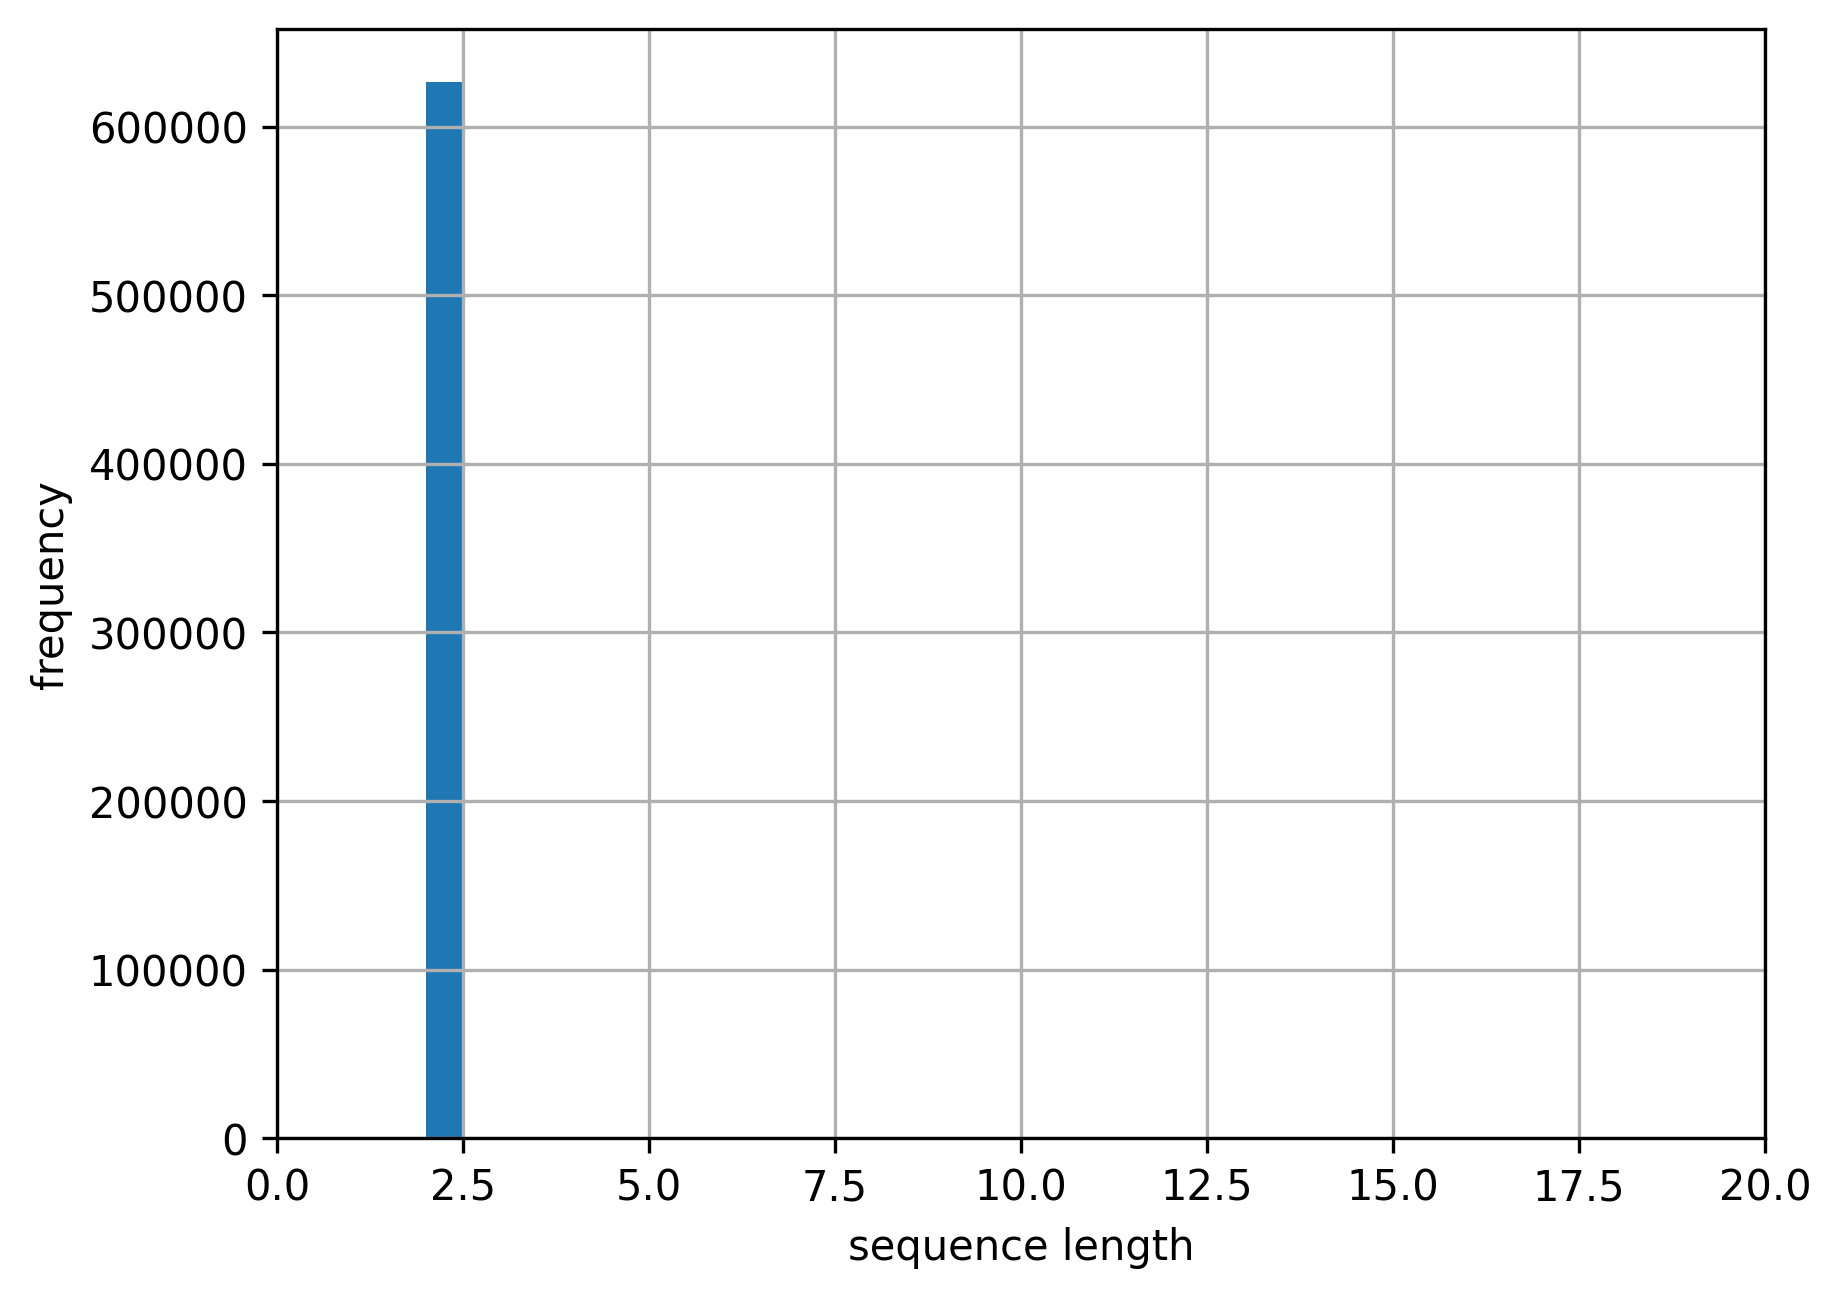

Distribution of retrieved ngram lengths for redundancy 0.6:
	Total hit count: 827084
	Total computations saved: 840545 of 14985000 (5.61 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.86 %
	Mean hit sequence length: 2.0162752513650366
	Median hit sequence length: 2.0


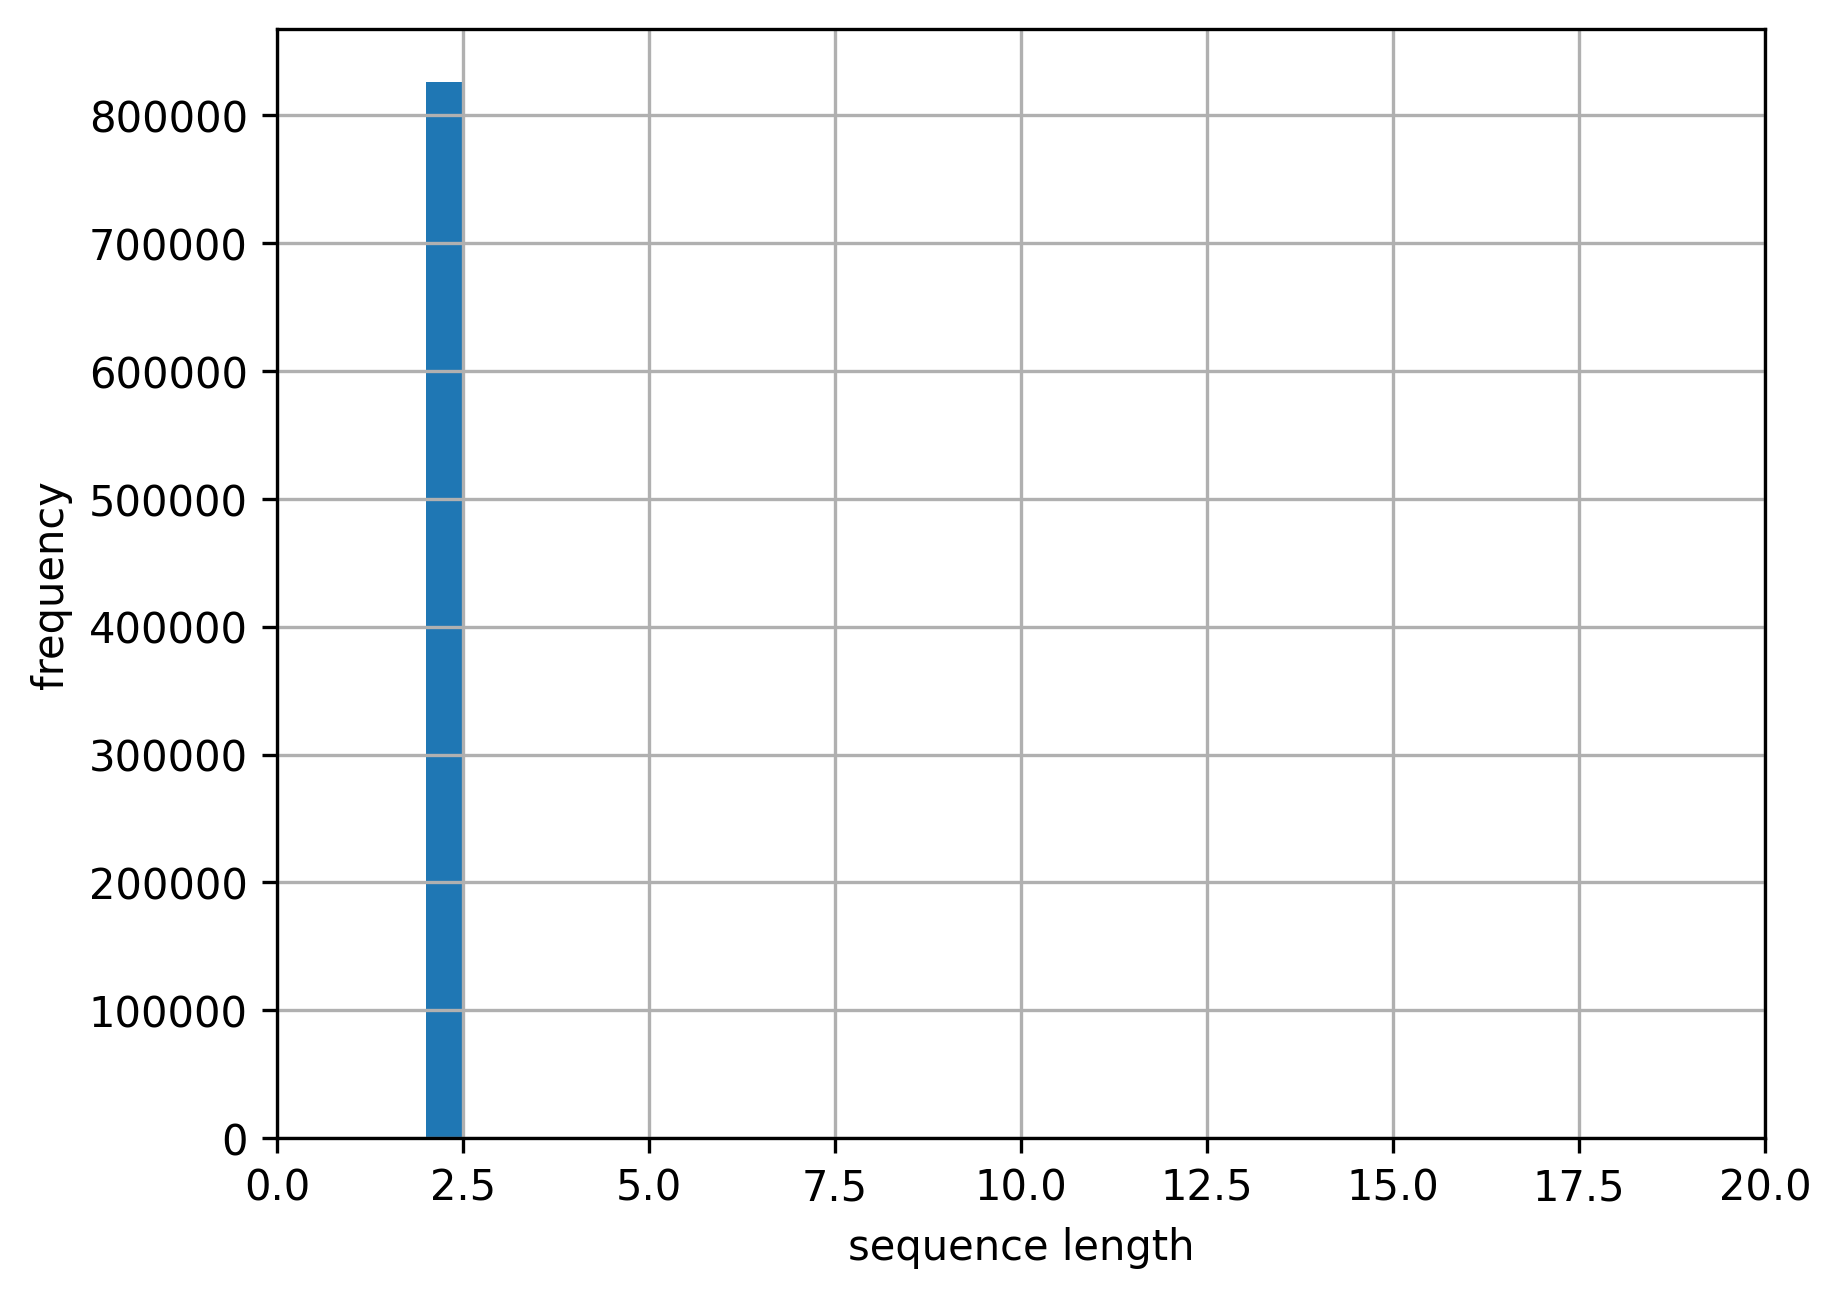

Distribution of retrieved ngram lengths for redundancy 0.7:
	Total hit count: 1169254
	Total computations saved: 1190236 of 14985000 (7.94 %)
	Average cache slots used: 10000 of 10000 (100.0 %)
	Share of len=2 hits: 99.76 %
	Mean hit sequence length: 2.017944775044601
	Median hit sequence length: 2.0


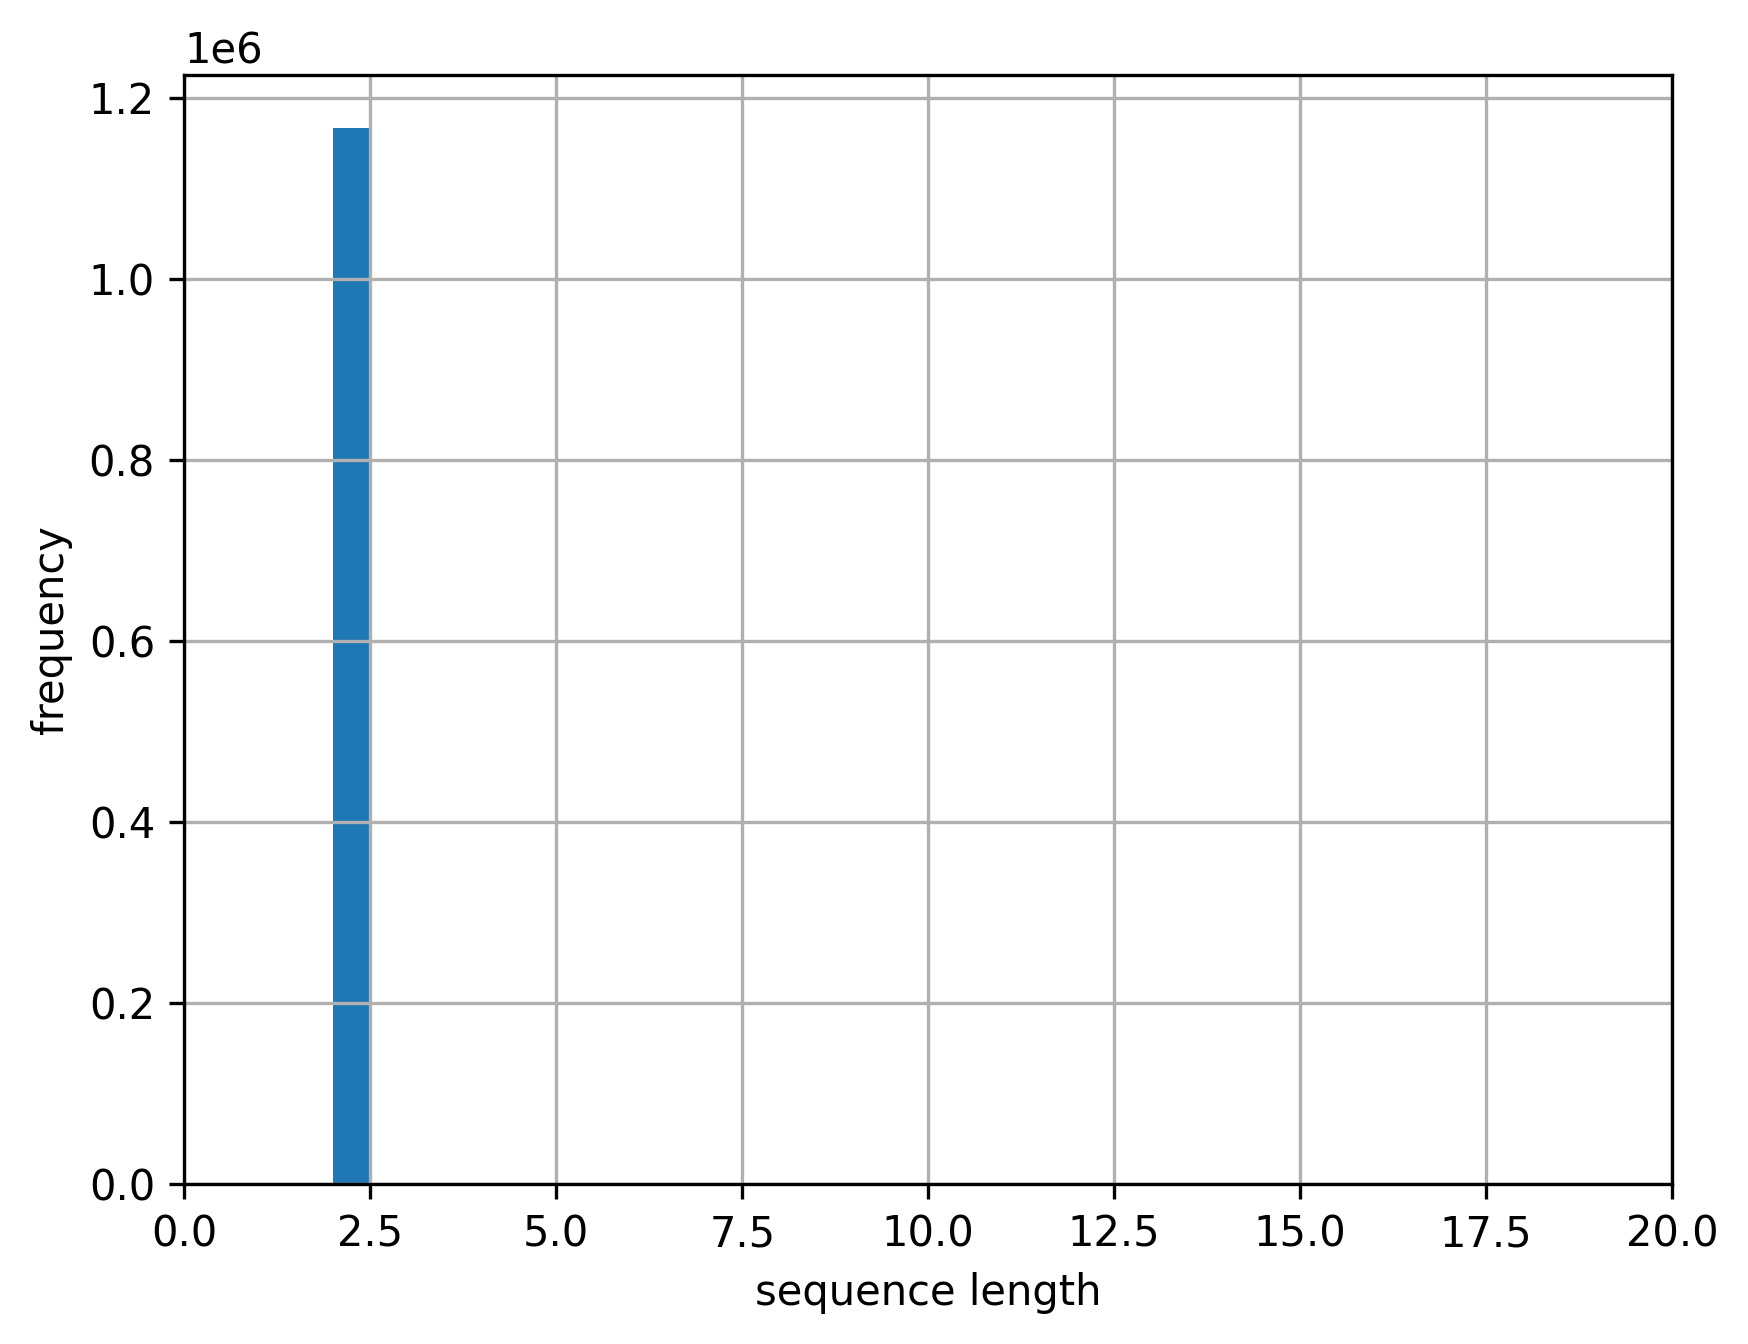

In [23]:
for redundancy in redundancies:
    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    hit_lengths = []
    for experiment in relevant_experiments:
        hit_lengths.extend(
            experiment["simulate_using_cache"]["hit_ngram_lenghts"])

    fig, ax = plt.subplots()

    upper_limit = 20
    bin_count = 40

    ax.hist(hit_lengths, bins=[upper_limit /
            bin_count * i for i in range(bin_count)])
    ax.set_xlabel("sequence length")
    ax.set_ylabel("frequency")
    ax.set_xlim([0, upper_limit])

    printb(
        f"Distribution of retrieved ngram lengths for redundancy {redundancy}:")
    print(f"\tTotal hit count: {len(hit_lengths)}")

    total_computations = len(relevant_experiments) * relevant_experiments[0]["params"]["circuit_count"] * (
        relevant_experiments[0]["params"]["gate_count"] - 1)
    total_gain = sum([
        (hit_length - 1) for hit_length in hit_lengths
    ])
    print(
        f"\tTotal computations saved: {total_gain} of {total_computations} ({round(100 * total_gain / total_computations, 2)} %)")

    cache_slots_used = int(sum([
        len(experiment["fill_cache"]["ngram_lengths"]) for experiment in relevant_experiments
    ]) / len(relevant_experiments))
    cache_size = relevant_experiments[0]["params"]["cache_size"]

    print(
        f"\tAverage cache slots used: {cache_slots_used} of {cache_size} ({round(100 * cache_slots_used / cache_size, 2)} %)")

    len2_hits_count = len(
        [hit_length for hit_length in hit_lengths if hit_length == 2])
    print(
        f"\tShare of len=2 hits: {round(100 * len2_hits_count / len(hit_lengths), 2)} %")
    print(f"\tMean hit sequence length: {mean(hit_lengths)}")
    print(f"\tMedian hit sequence length: {median(hit_lengths)}")

    plt.grid()
    plt.show()

In [24]:
relative_gains = []
hits = []
len2_shares = []

for redundancy in redundancies:
    relevant_experiments = [
        experiment
        for experiment in vr_experiments
        if experiment["params"]["cache_size"] > 0
        and experiment["params"]["redundancy"] == redundancy
    ]

    hit_lengths = []
    for experiment in relevant_experiments:
        hit_lengths.extend(
            experiment["simulate_using_cache"]["hit_ngram_lenghts"])

    total_hits = len(hit_lengths)
    hits.append(total_hits)

    total_computations = len(relevant_experiments) * relevant_experiments[0]["params"]["circuit_count"] * (
        relevant_experiments[0]["params"]["gate_count"] - 1)
    total_gain = sum([
        (hit_length - 1) for hit_length in hit_lengths
    ])
    relative_gains.append(total_gain / total_computations * 100)

    len2_hits_count = len(
        [hit_length for hit_length in hit_lengths if hit_length == 2])
    len2_share = round(100 * len2_hits_count / len(hit_lengths), 2)
    len2_shares.append(len2_share)


Total matrix multiplications saved:


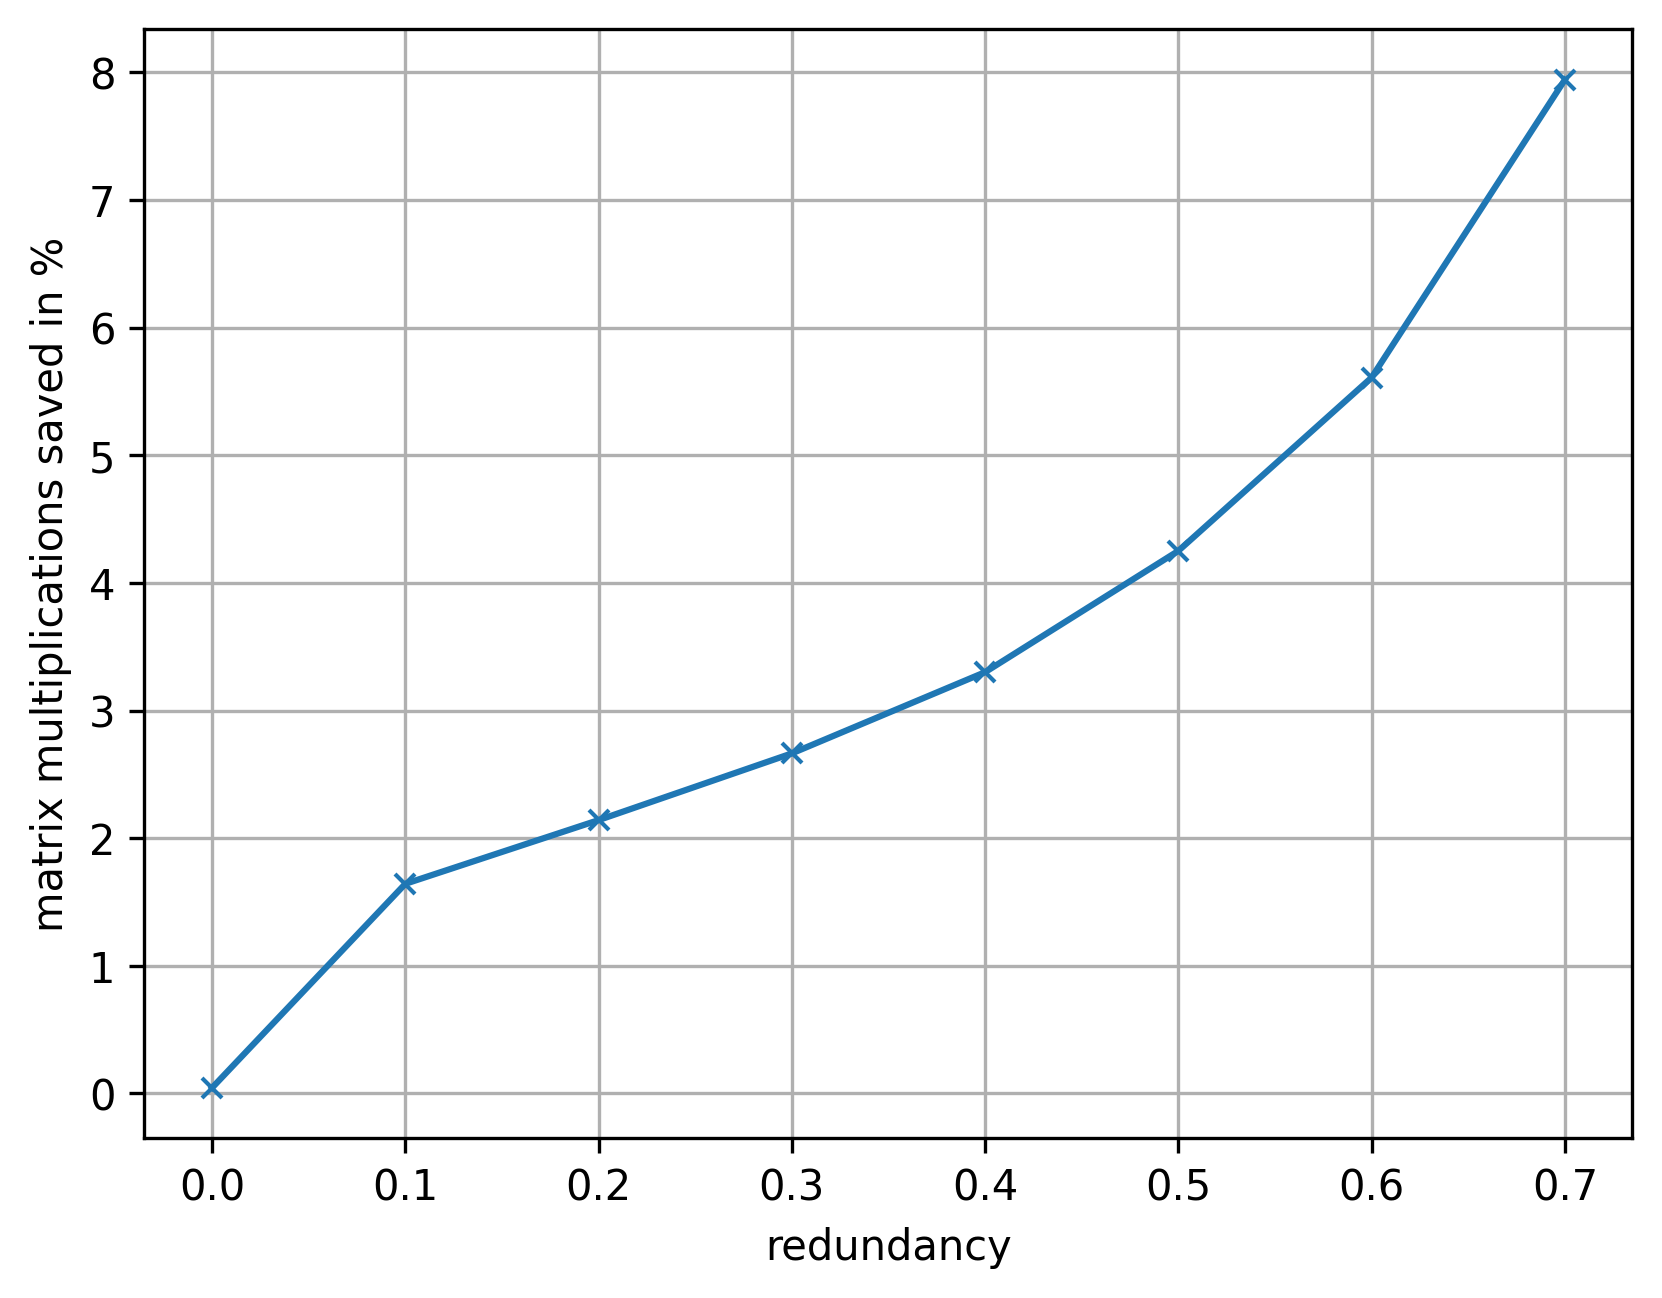

In [25]:
printb("Total matrix multiplications saved:")
ax = plt.subplot()
ax.plot(redundancies, relative_gains, marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
ax.set_xlabel("redundancy")
ax.set_ylabel("matrix multiplications saved in %")

plt.grid()
plt.savefig(f"{target_dir}/multiplications_saved_over_redundancy.png")
plt.show()

Total hit count:


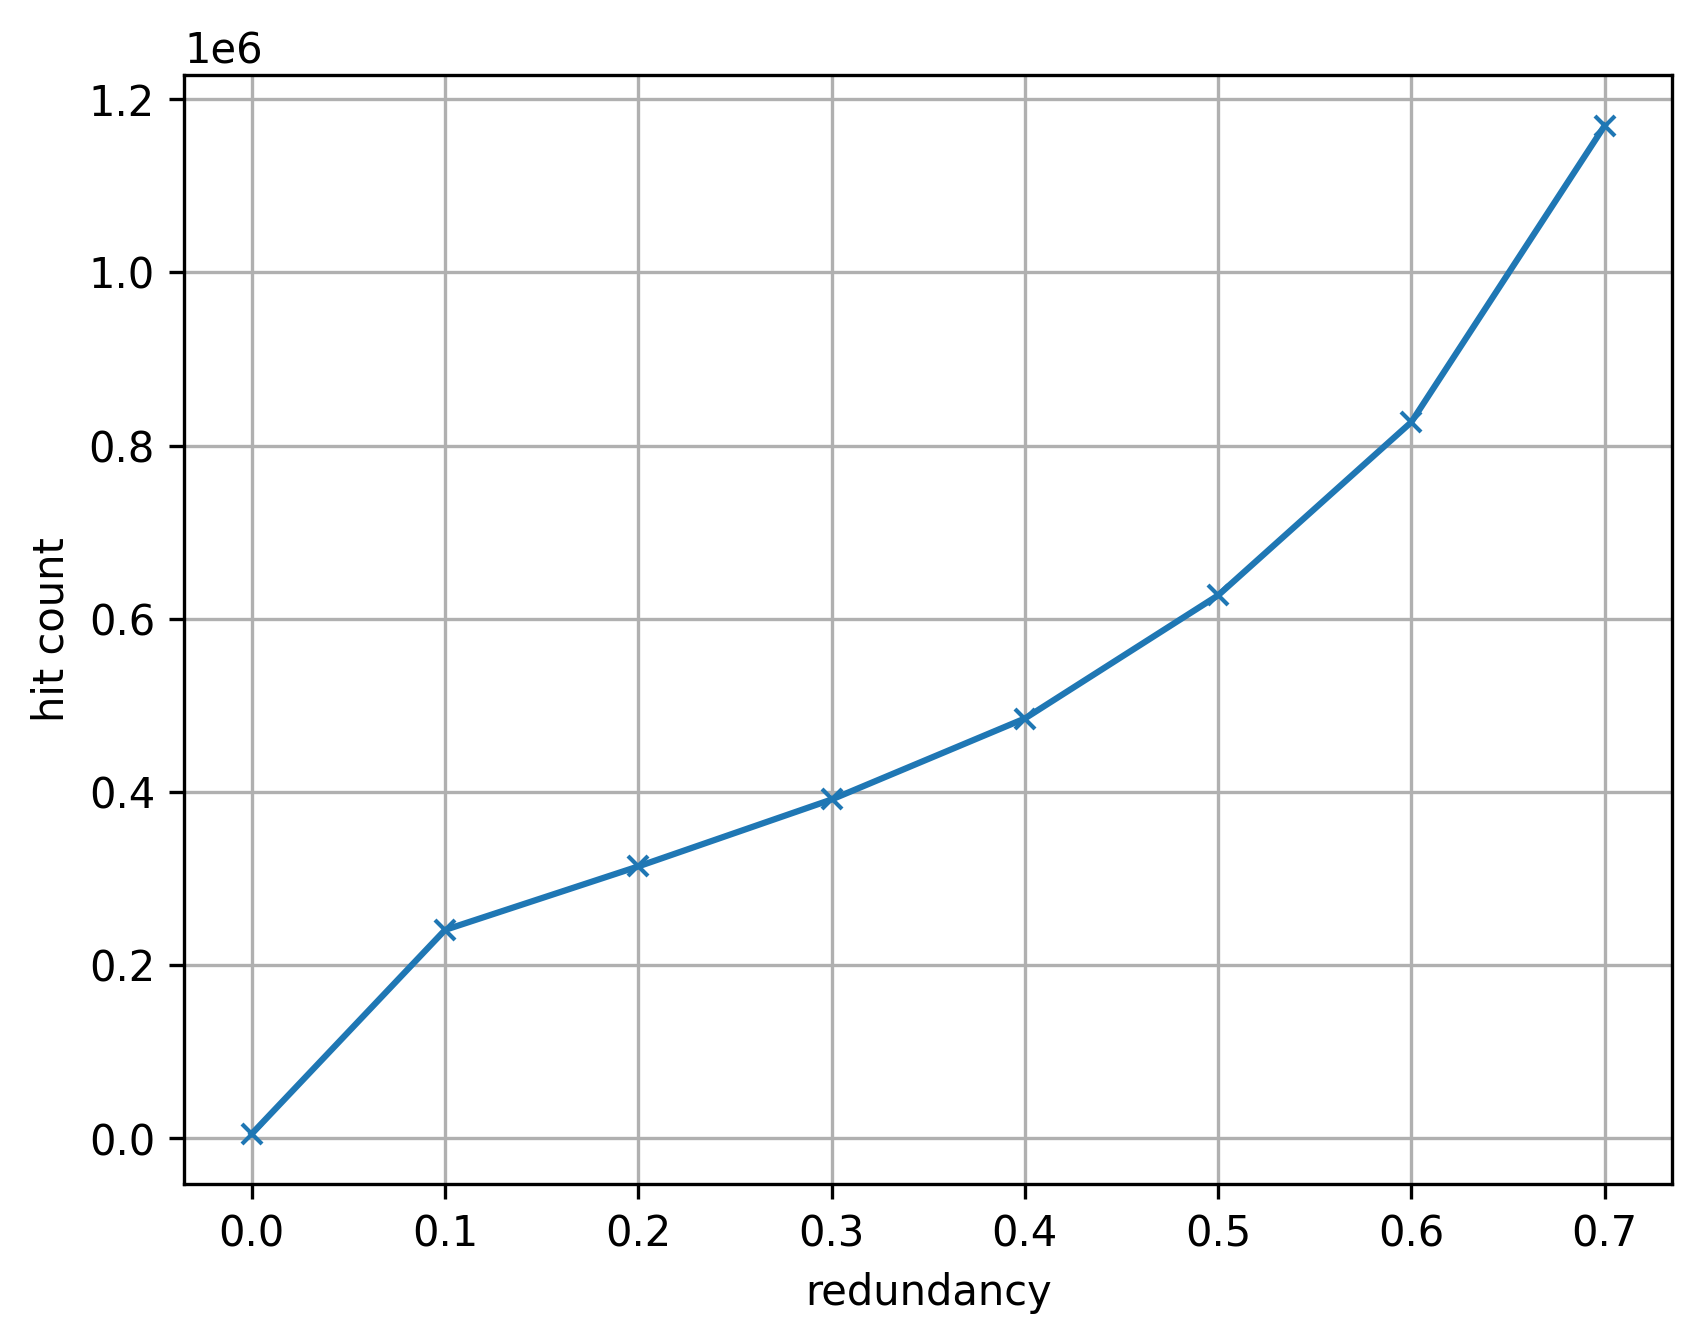

In [26]:
printb("Total hit count:")
ax = plt.subplot()
ax.plot(redundancies, hits, marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
ax.set_xlabel("redundancy")
ax.set_ylabel("hit count")

plt.grid()
plt.show()

Share of len2 ngrams:


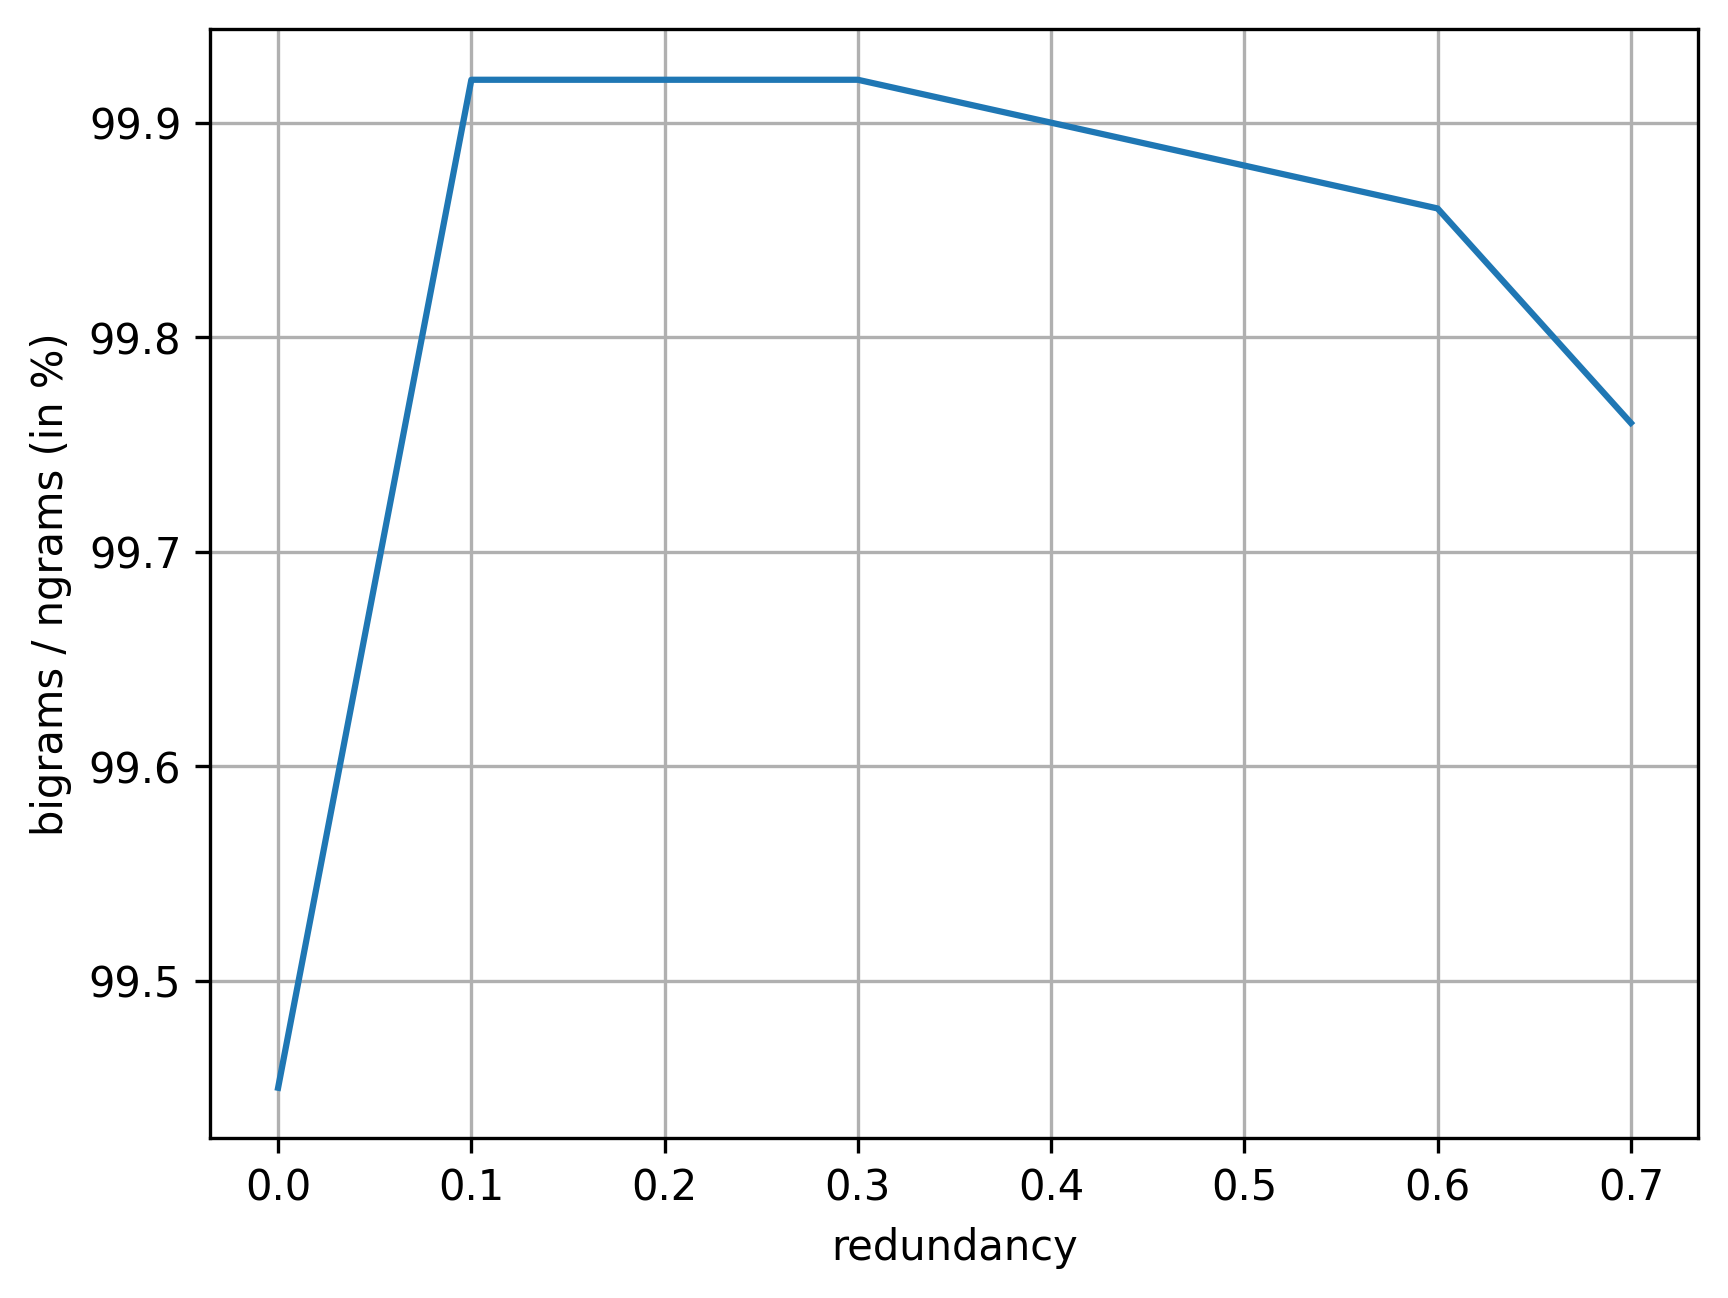

In [27]:
printb("Share of len2 ngrams:")
ax = plt.subplot()
ax.plot(redundancies, len2_shares)
ax.set_xlabel("redundancy")
ax.set_ylabel("bigrams / ngrams (in %)")

plt.grid()
plt.show()

## RQ2.1: How does the amount of qubits in the population influence simulation speed?

In [28]:
# Filter out and format experiment results with the varying_qubits tag

vq_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_qubits"]
print(f"Total amount of varying_qubits experiments: {len(vq_experiments)}")

Total amount of varying_qubits experiments: 600


In [29]:
qubit_nums = [experiment["params"]["qubit_num"] for experiment in vq_experiments]
qubit_nums = list(set(qubit_nums))
qubit_nums.sort()

print("Qubit counts:", qubit_nums)

Qubit counts: [5, 6, 7, 8, 9]


In [30]:
redundancies = [experiment["params"]["redundancy"] for experiment in vq_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.1, 0.3, 0.5, 0.7]


Total simulation time with 0.1 redundancy, averaged across seeds:


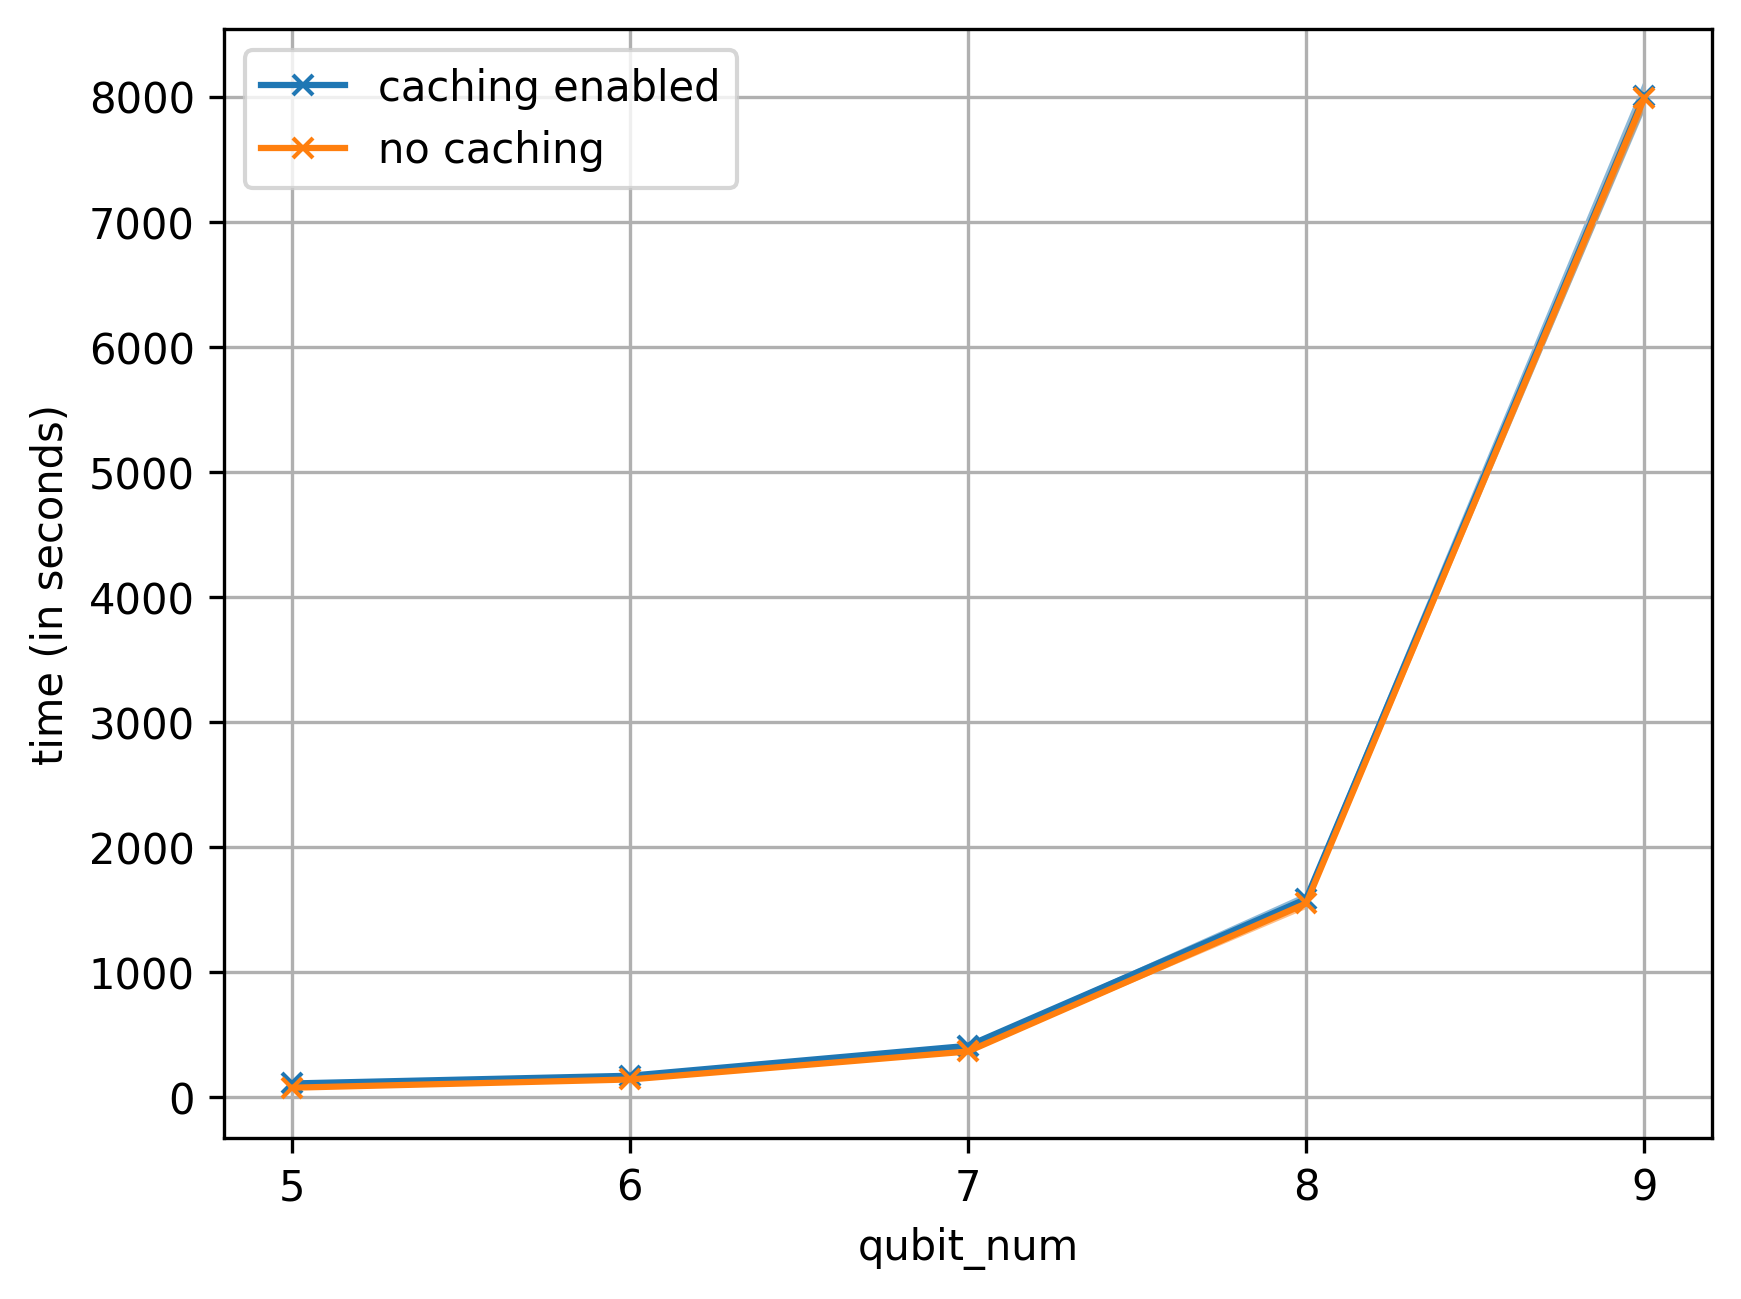

Total simulation time with 0.3 redundancy, averaged across seeds:


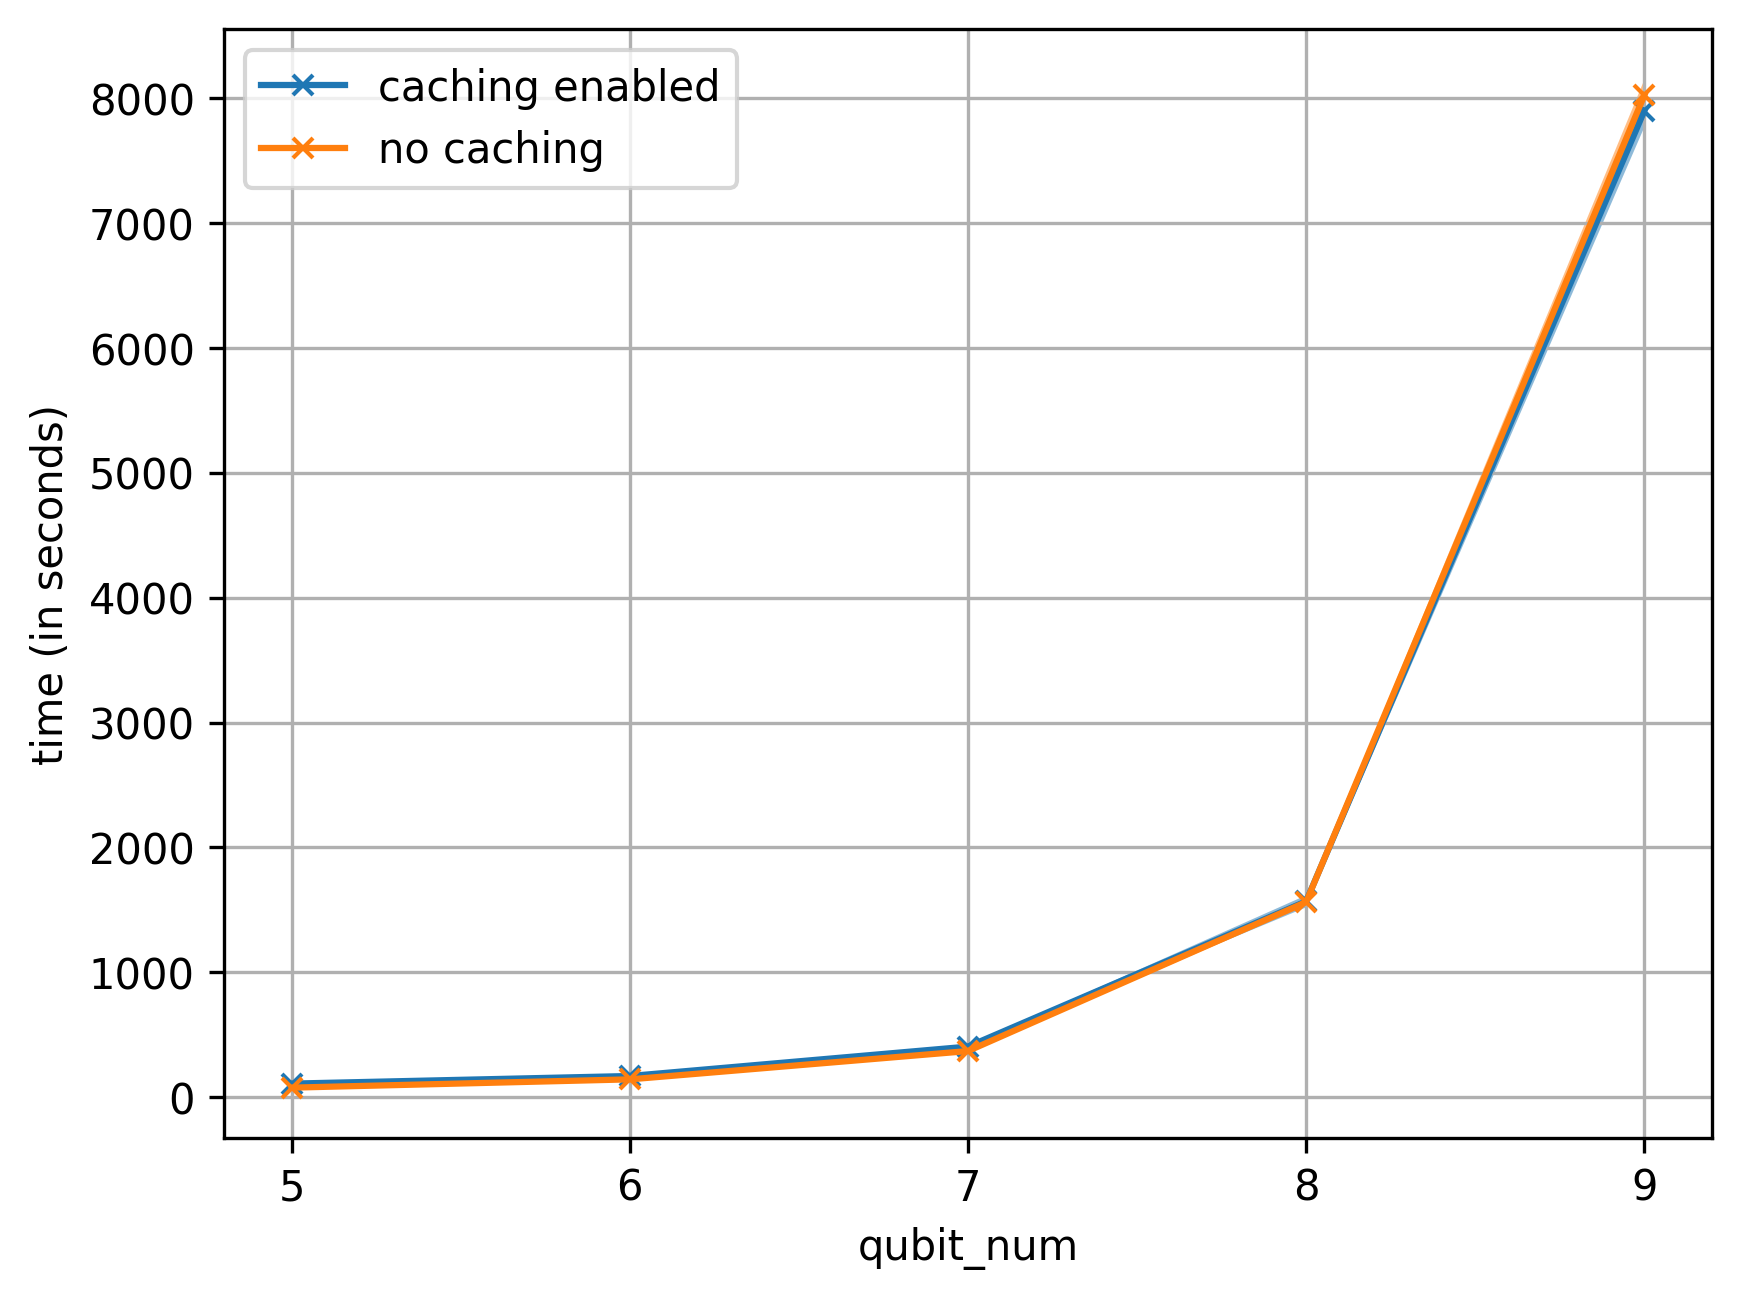

Total simulation time with 0.5 redundancy, averaged across seeds:


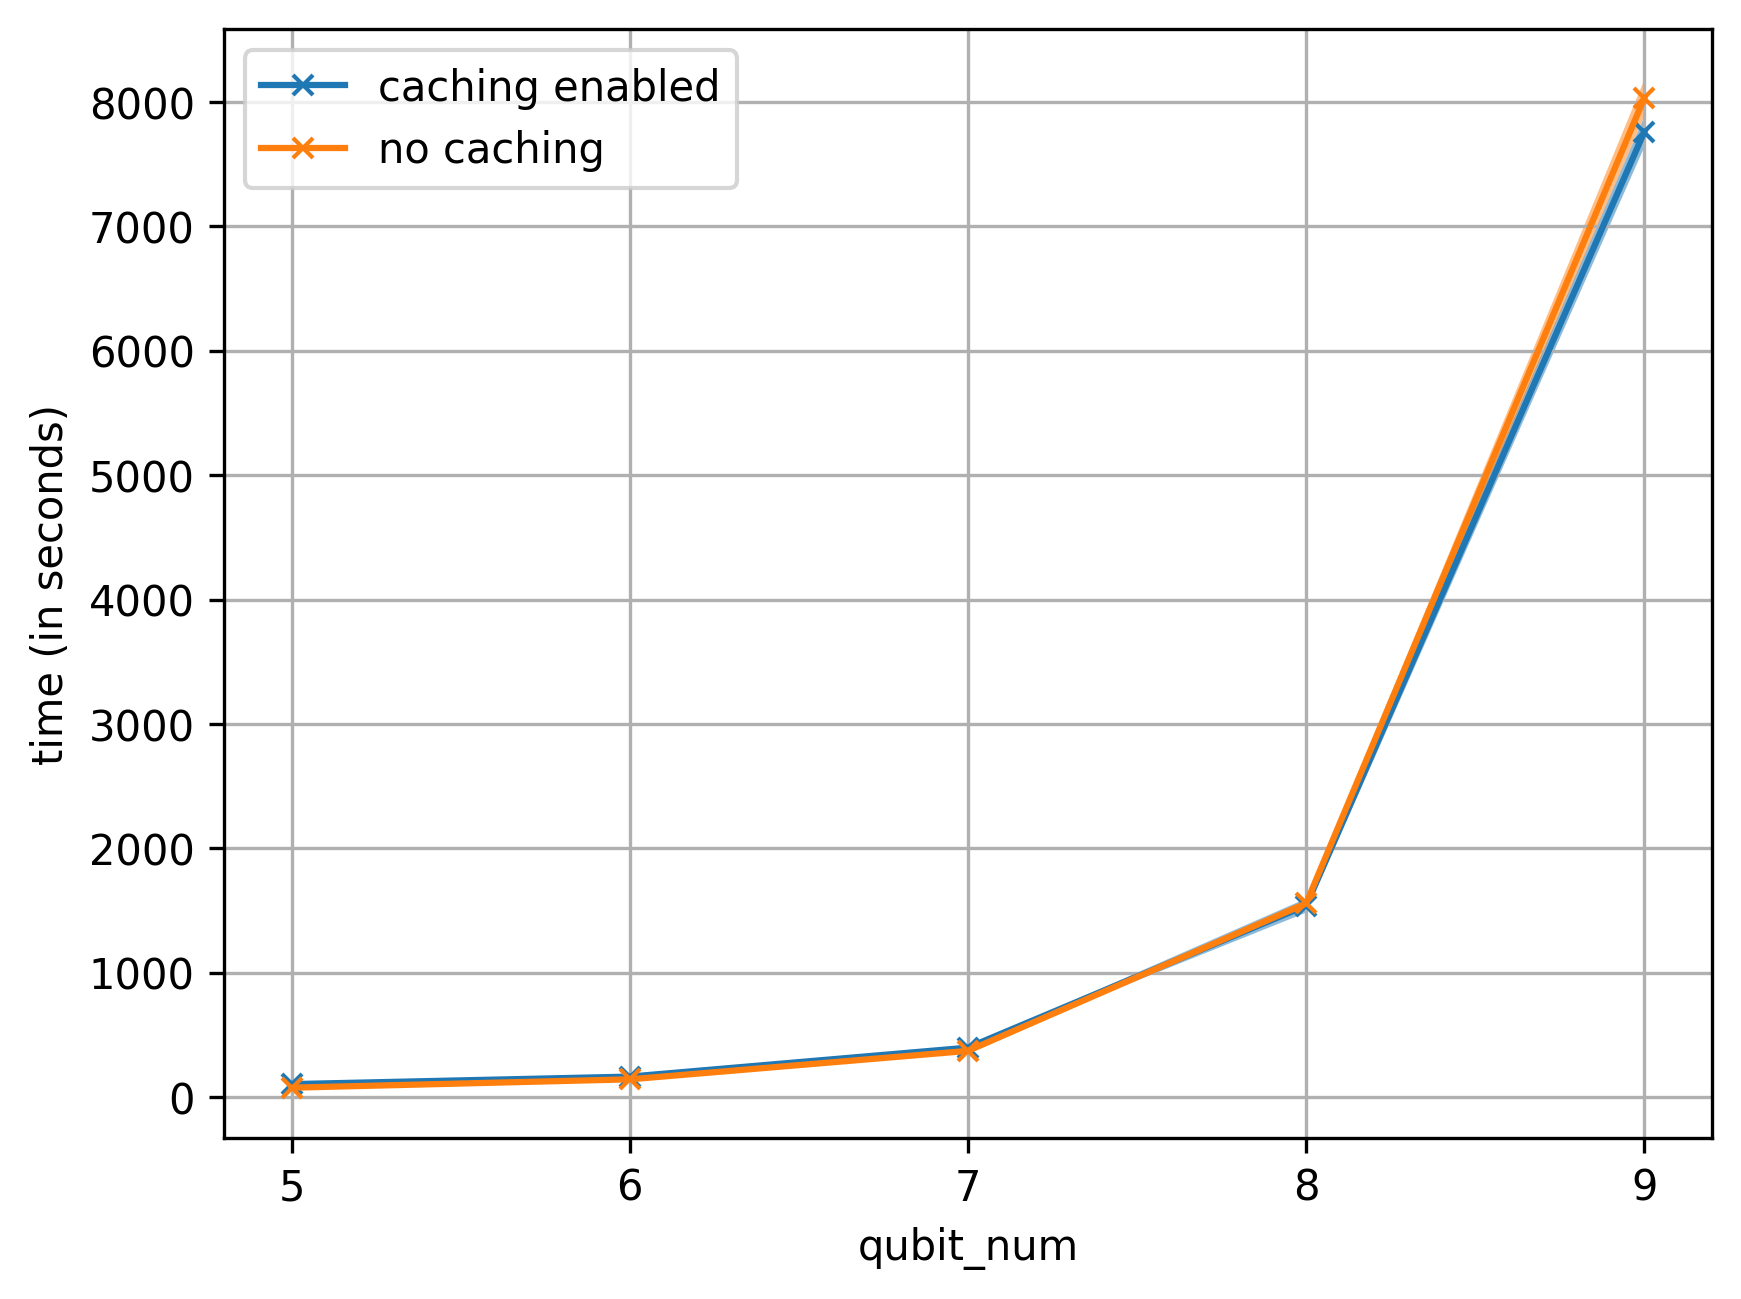

Total simulation time with 0.7 redundancy, averaged across seeds:


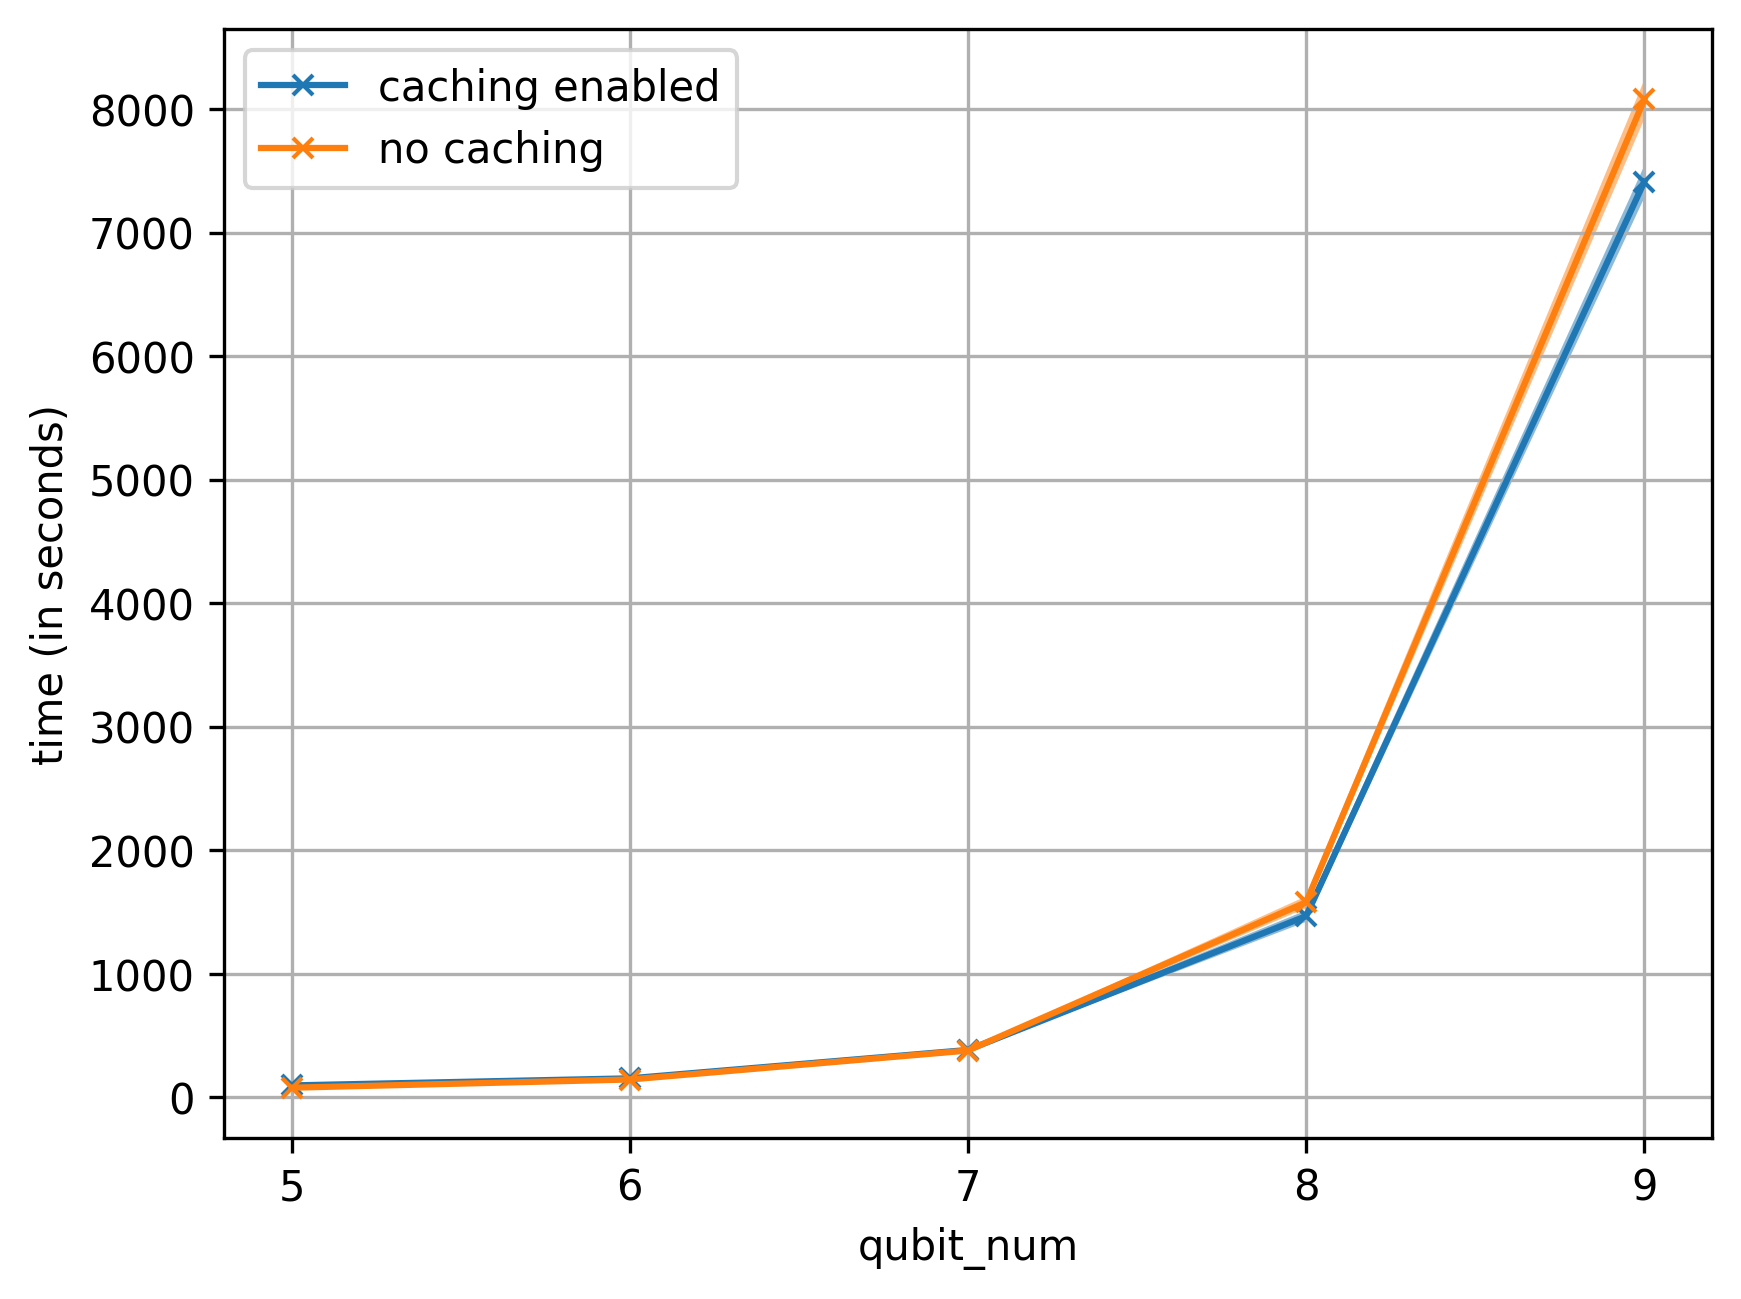

In [31]:
# Create a line chart with simulation time on y and qubit count 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

for redundancy in redundancies:

    durations_no_cache = []
    stdevs_no_cache = []
    durations_with_cache = []
    stdevs_with_cache = []

    for qubit_num in qubit_nums:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]
        durations_no_cache.append(mean(sel_durations_no_cache))
        stdevs_no_cache.append(stdev(sel_durations_no_cache))

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]
        durations_with_cache.append(mean(sel_durations_with_cache))
        stdevs_with_cache.append(stdev(sel_durations_with_cache))

    ax = plt.subplot()
    
    ax.plot(qubit_nums, durations_with_cache, label="caching enabled", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    lower_bounds_with_cache = [
        duration - sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
    ]
    upper_bounds_with_cache = [
        duration + sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
    ]
    ax.fill_between(
        qubit_nums, lower_bounds_with_cache, upper_bounds_with_cache, alpha=0.5
    )
    
    ax.plot(qubit_nums, durations_no_cache, label="no caching", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    lower_bounds_no_cache = [
        duration - sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
    ]
    upper_bounds_no_cache = [
        duration + sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
    ]
    ax.fill_between(
        qubit_nums, lower_bounds_no_cache, upper_bounds_no_cache, alpha=0.5
    )
    
    ax.set_xlabel("qubit_num")
    ax.set_ylabel("time (in seconds)")
    # ax.set_ylim(8000, 8500)

    ax.set_xticks(qubit_nums)

    printb(f"Total simulation time with {redundancy} redundancy, averaged across seeds:")
    plt.legend()
    plt.grid()

    plt.savefig(f"{target_dir}/total_time_over_qubit_num_{redundancy}r.png")
    plt.show()


In [32]:
from bisect import bisect_left
from scipy.stats import rankdata

def compute_a12(y1, y2):
    # Taken from https://gist.github.com/jacksonpradolima/f9b19d65b7f16603c837024d5f8c8a65

    l1 = len(y1)
    l2 = len(y2)

    r = rankdata(y1 + y2)
    r1 = sum(r[0:l1]) 

    # Compute the measure
    A = (r1/l1 - (l1+1)/2)/l2 # formula (14) in Vargha and Delaney, 2000
    # A = (2 * r1 - l1 * (l1 + 1)) / (2 * l1 * l2)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    # levels = [0.056*2, 0.138*2, 0.214*2]
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude

In [33]:
# Compute Mann Whitney U test statistics between with and without caching.

from scipy.stats import mannwhitneyu

printb("Mann-Whitney U test p-values")

for redundancy in redundancies:

    for qubit_num in qubit_nums:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]

        U, p = mannwhitneyu(sel_durations_with_cache, sel_durations_no_cache)

        print(f"P-value for redundancy of {redundancy} and {qubit_num} qubits: {p:.6f}")

        effect_size, interpretation = compute_a12(sel_durations_with_cache, sel_durations_no_cache)
        print(f"Effect size: {effect_size} ({interpretation})")

    print("")


Mann-Whitney U test p-values
P-value for redundancy of 0.1 and 5 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.1 and 6 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.1 and 7 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.1 and 8 qubits: 0.097091
Effect size: 0.6799999999999999 (medium)
P-value for redundancy of 0.1 and 9 qubits: 0.966915
Effect size: 0.5066666666666666 (negligible)

P-value for redundancy of 0.3 and 5 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.3 and 6 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.3 and 7 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.3 and 8 qubits: 0.803463
Effect size: 0.5288888888888889 (negligible)
P-value for redundancy of 0.3 and 9 qubits: 0.011401
Effect size: 0.22666666666666668 (large)

P-value for redundancy of 0.5 and 5 qubits: 0.000003
Effect size: 1.0 (large)
P-value for redundancy of 0.5 and 6 qub

Ratio of total simulation time no-caching over caching with 0.1 redundancy, averaged across seeds:


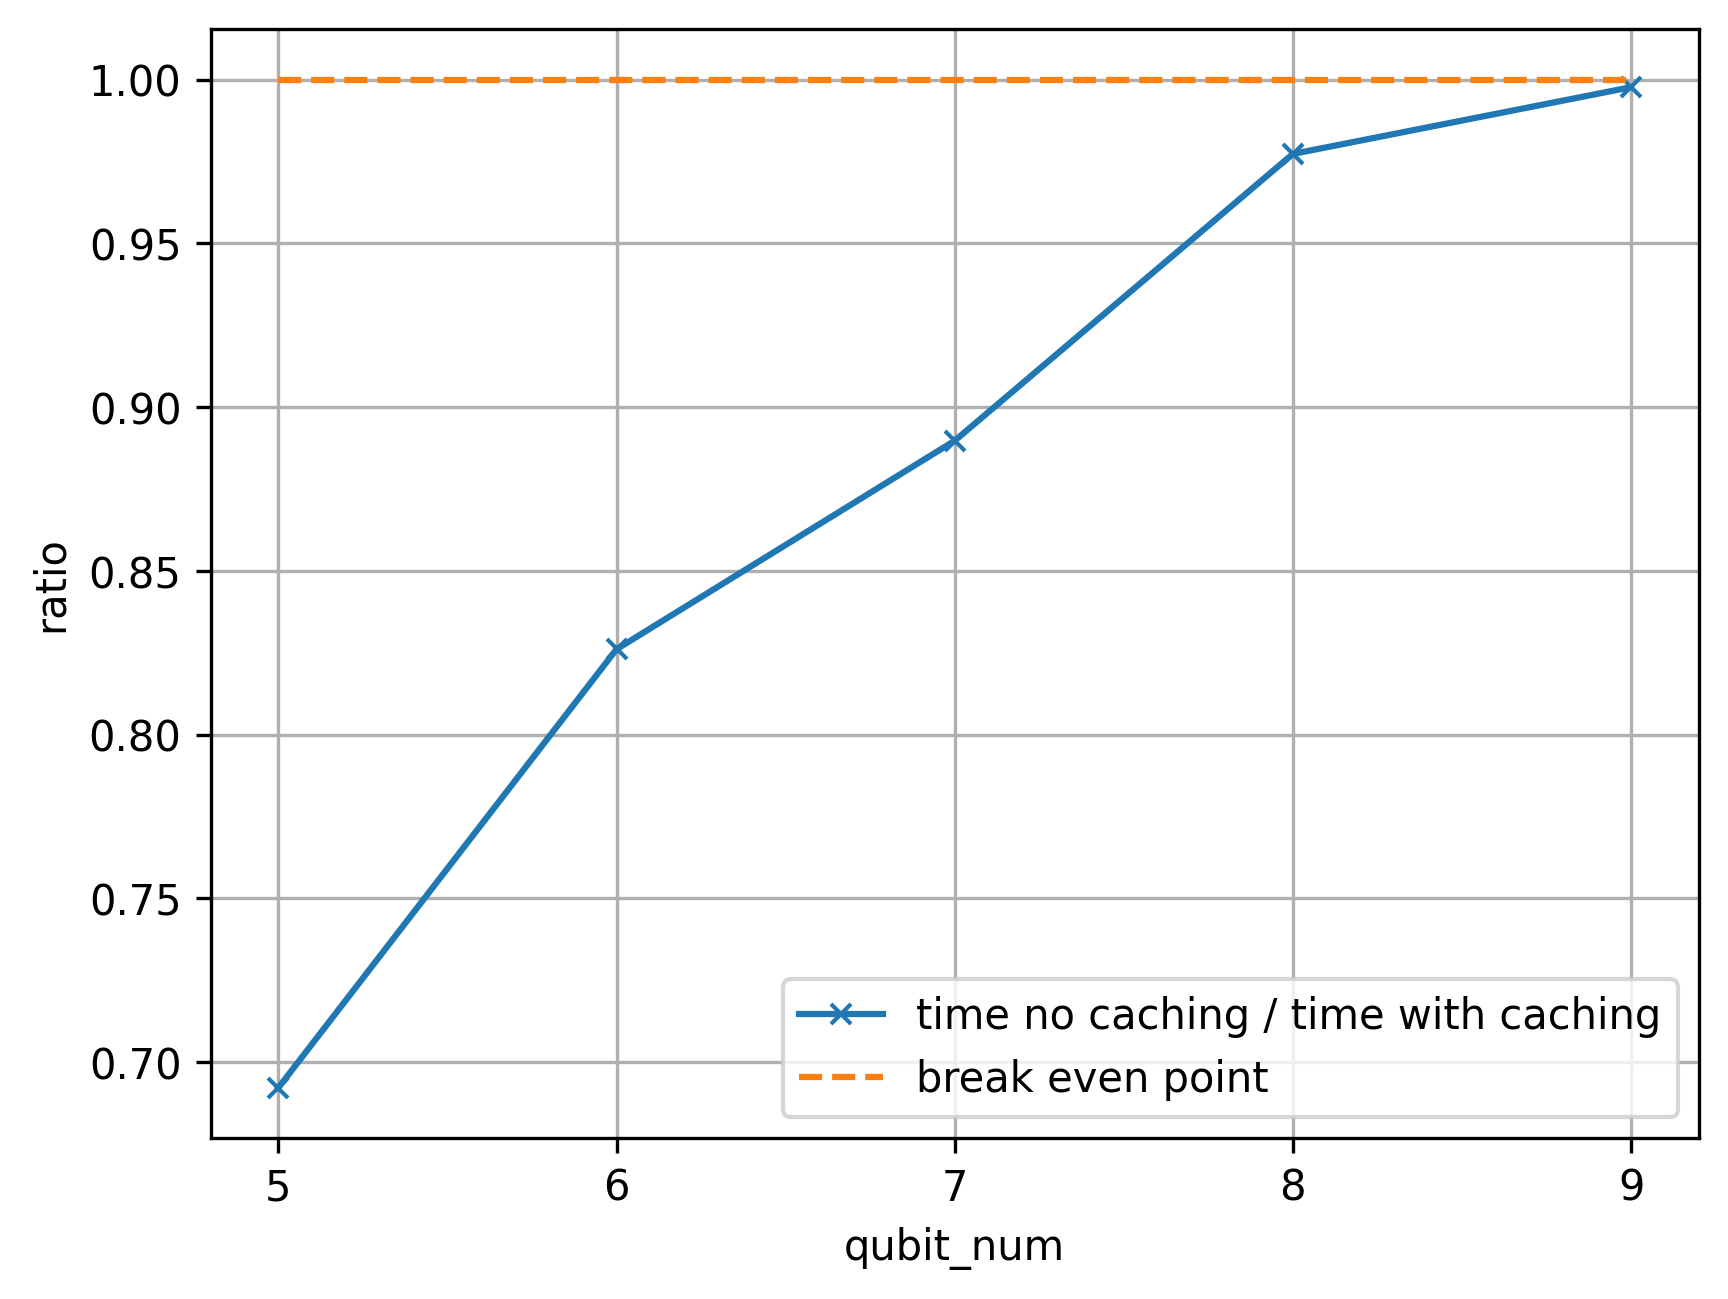

Ratio of total simulation time no-caching over caching with 0.3 redundancy, averaged across seeds:


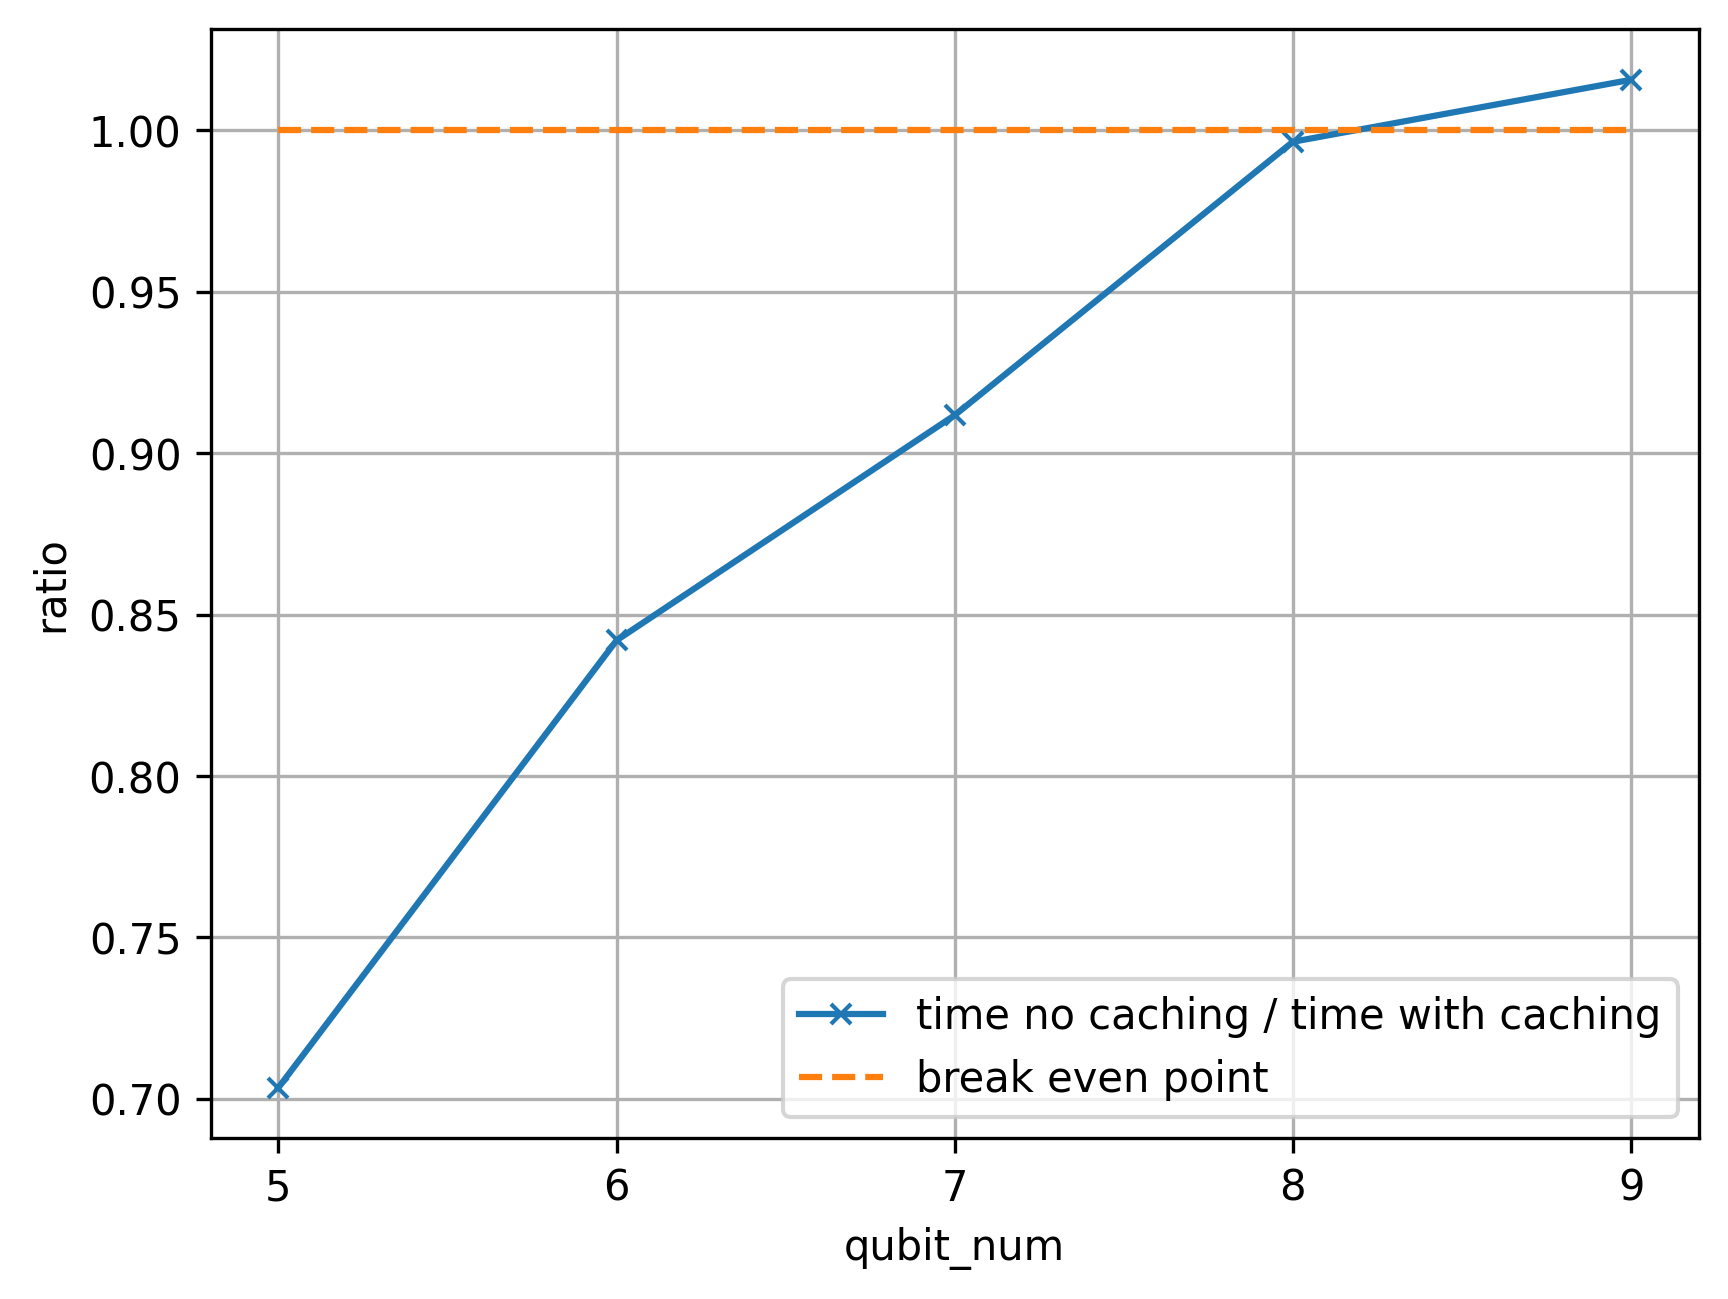

Ratio of total simulation time no-caching over caching with 0.5 redundancy, averaged across seeds:


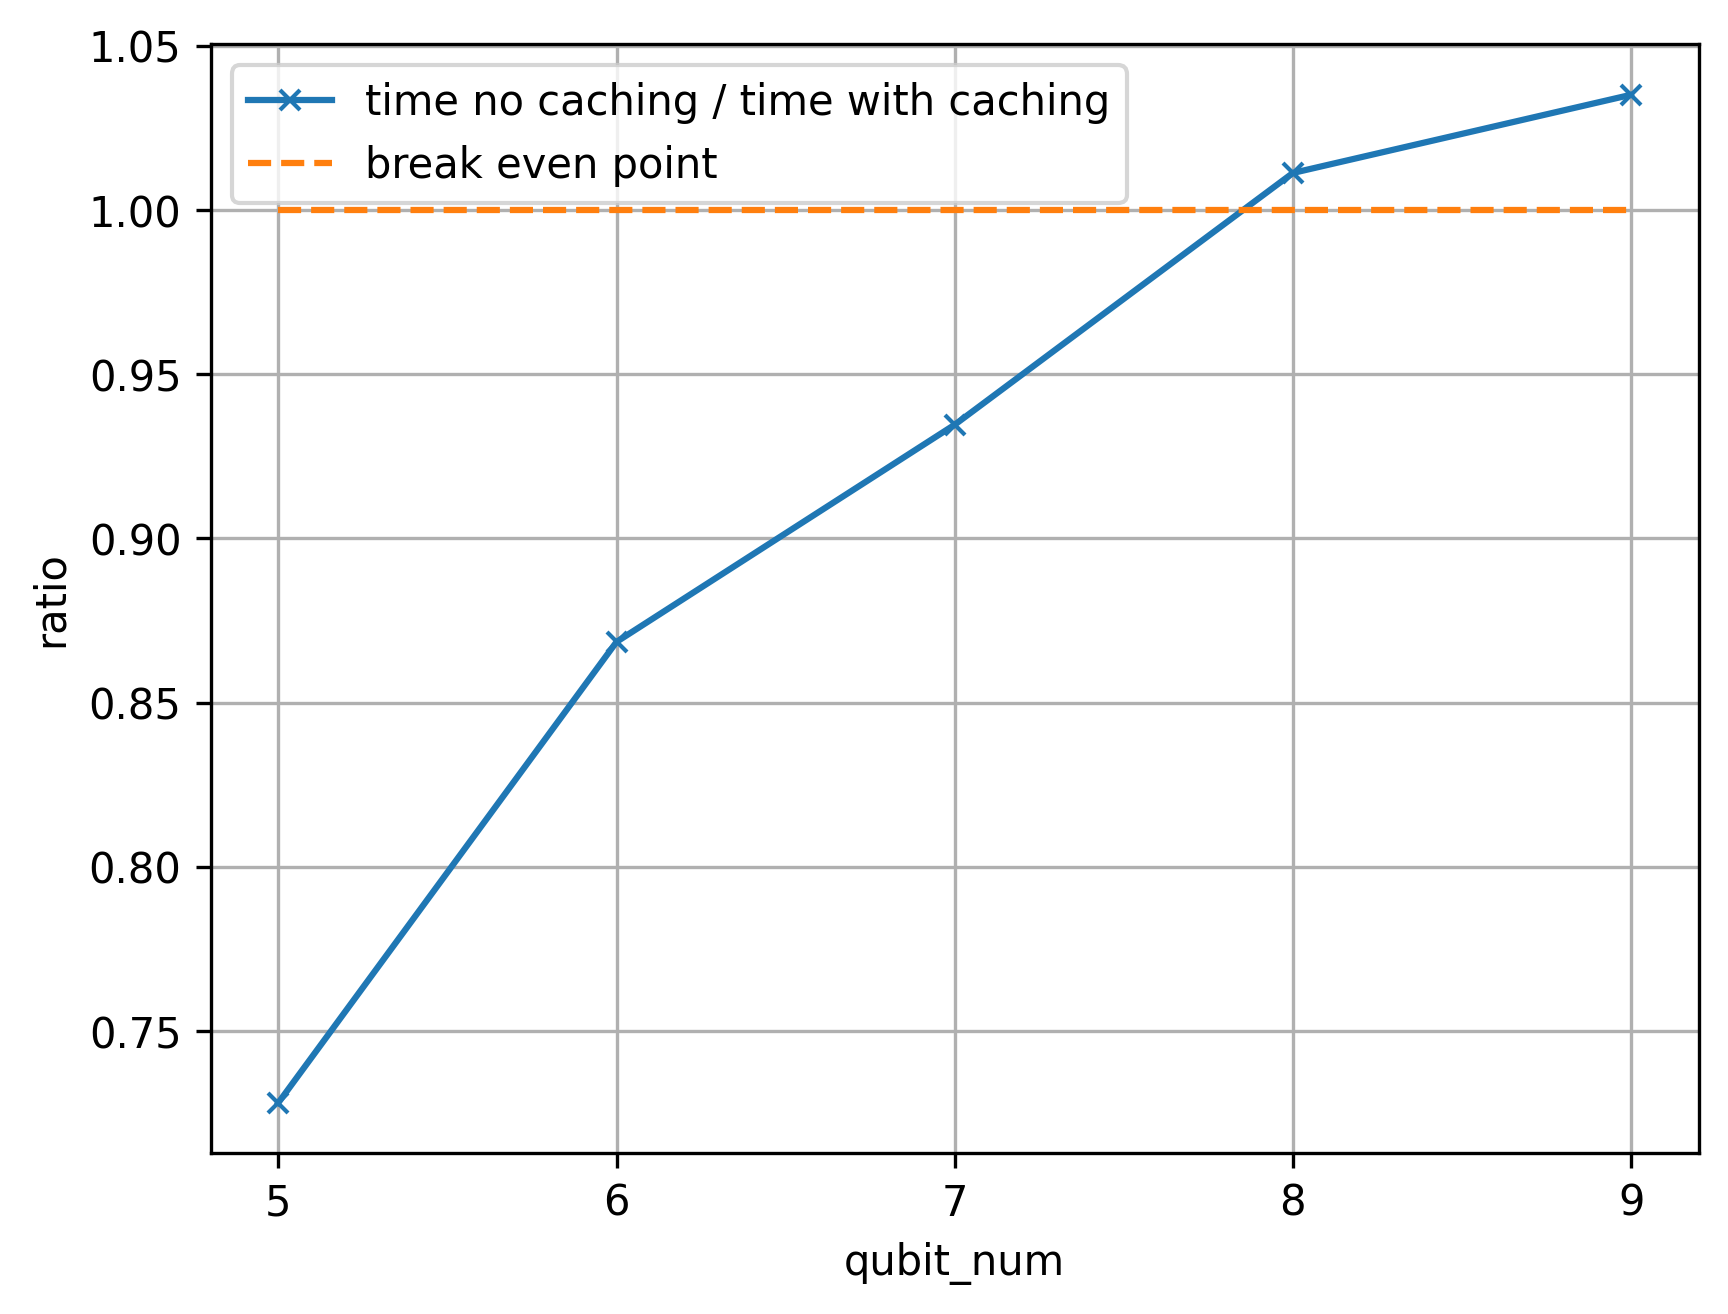

Ratio of total simulation time no-caching over caching with 0.7 redundancy, averaged across seeds:


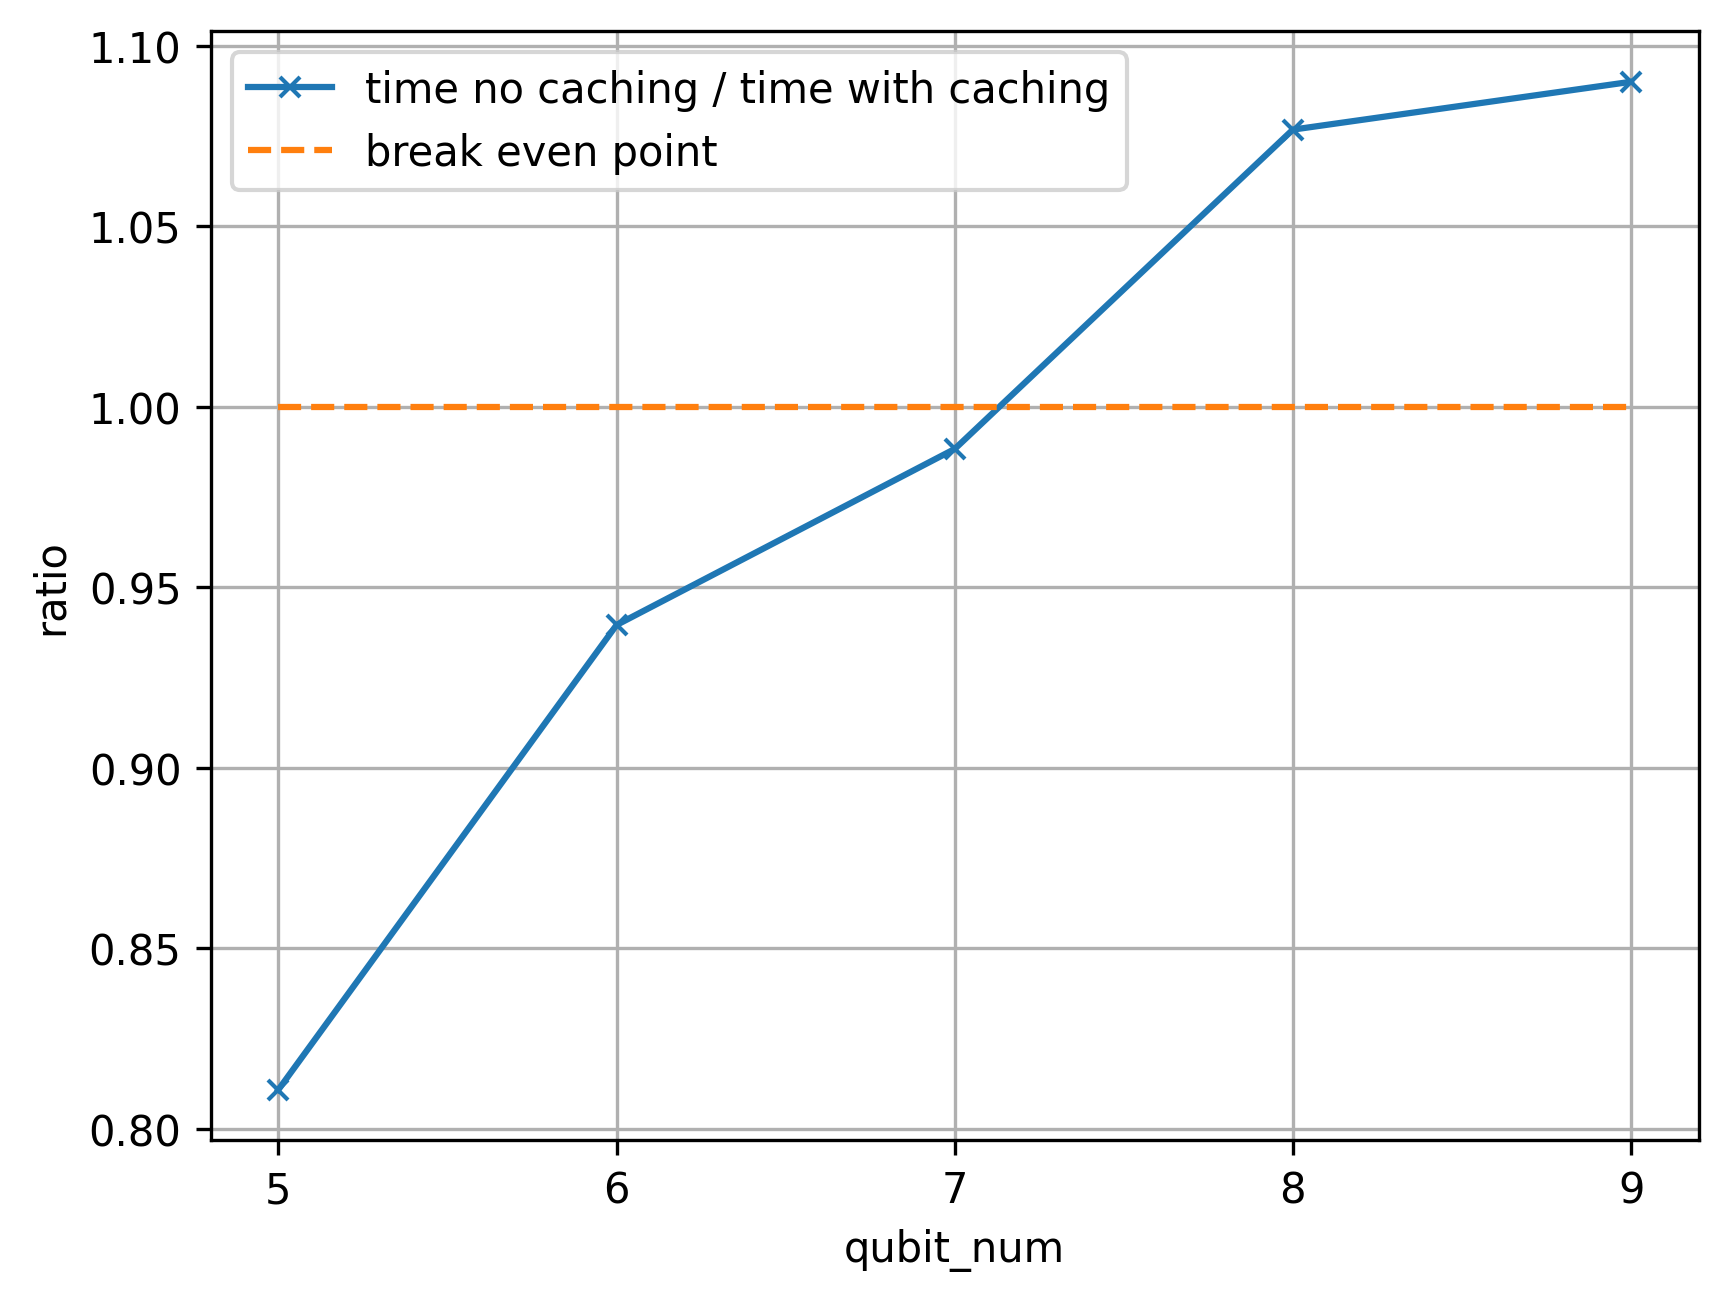

In [34]:
# Create a line chart with simulation time on y and qubit count 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.


for redundancy in redundancies:

    ratios = []

    for qubit_num in qubit_nums:

        durations_no_cache = [
            experiment["total_duration"]
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]

        durations_with_cache = [
            experiment["total_duration"]
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]

        ratio = mean(durations_no_cache) / mean(durations_with_cache)
        ratios.append(ratio)

    ax = plt.subplot()
    ax.plot(qubit_nums, ratios, label="time no caching / time with caching", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    ax.plot(qubit_nums, [1 for _ in qubit_nums], label="break even point", linestyle="dashed")
    ax.set_xlabel("qubit_num")
    ax.set_ylabel("ratio")

    ax.set_xticks(qubit_nums)

    printb(f"Ratio of total simulation time no-caching over caching with {redundancy} redundancy, averaged across seeds:")
    plt.legend()
    plt.grid()

    plt.savefig(f"{target_dir}/total_time_ratio_over_qubit_num_{redundancy}r.png")
    plt.show()


Components of total simulation time with 0.1 redundancy, averaged across seeds:


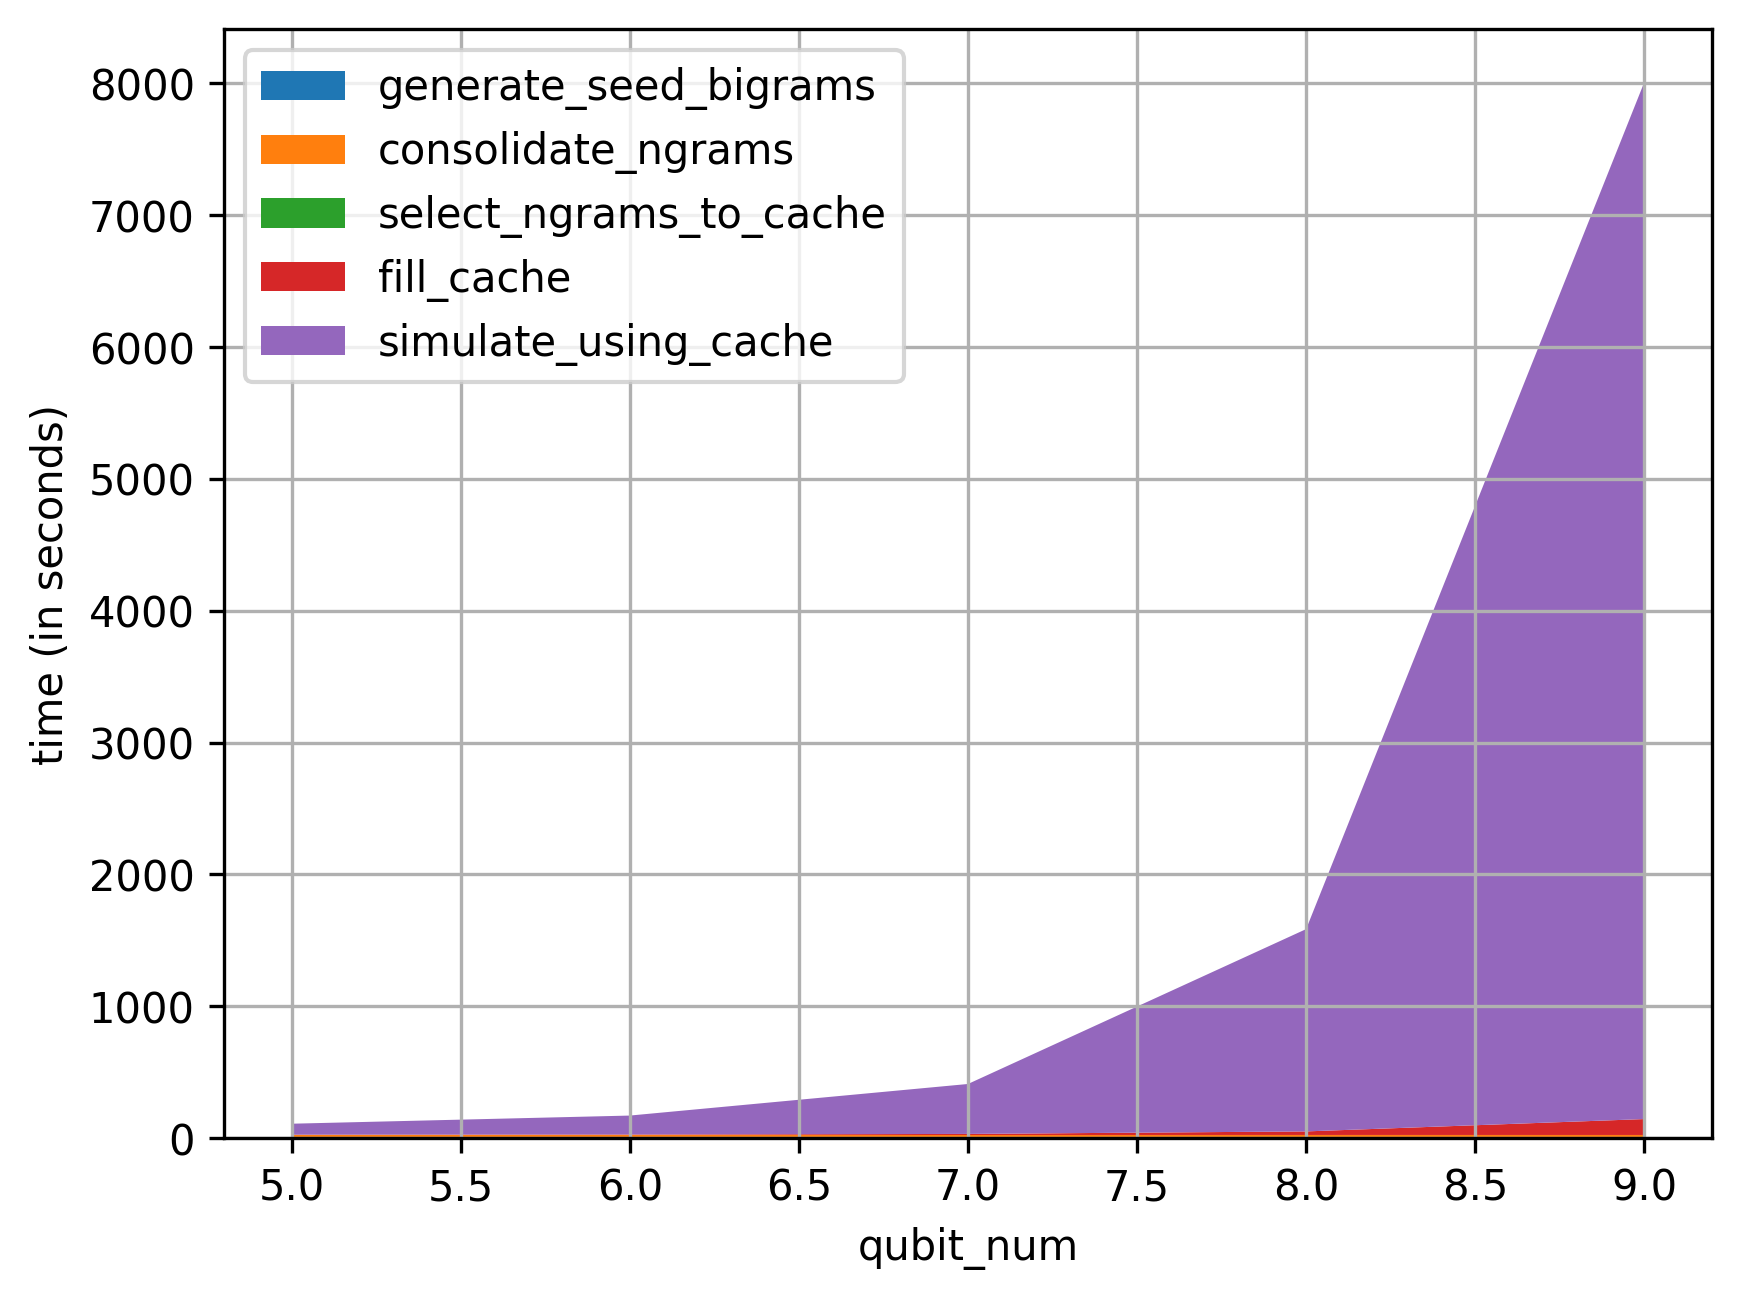

Components of total simulation time with 0.3 redundancy, averaged across seeds:


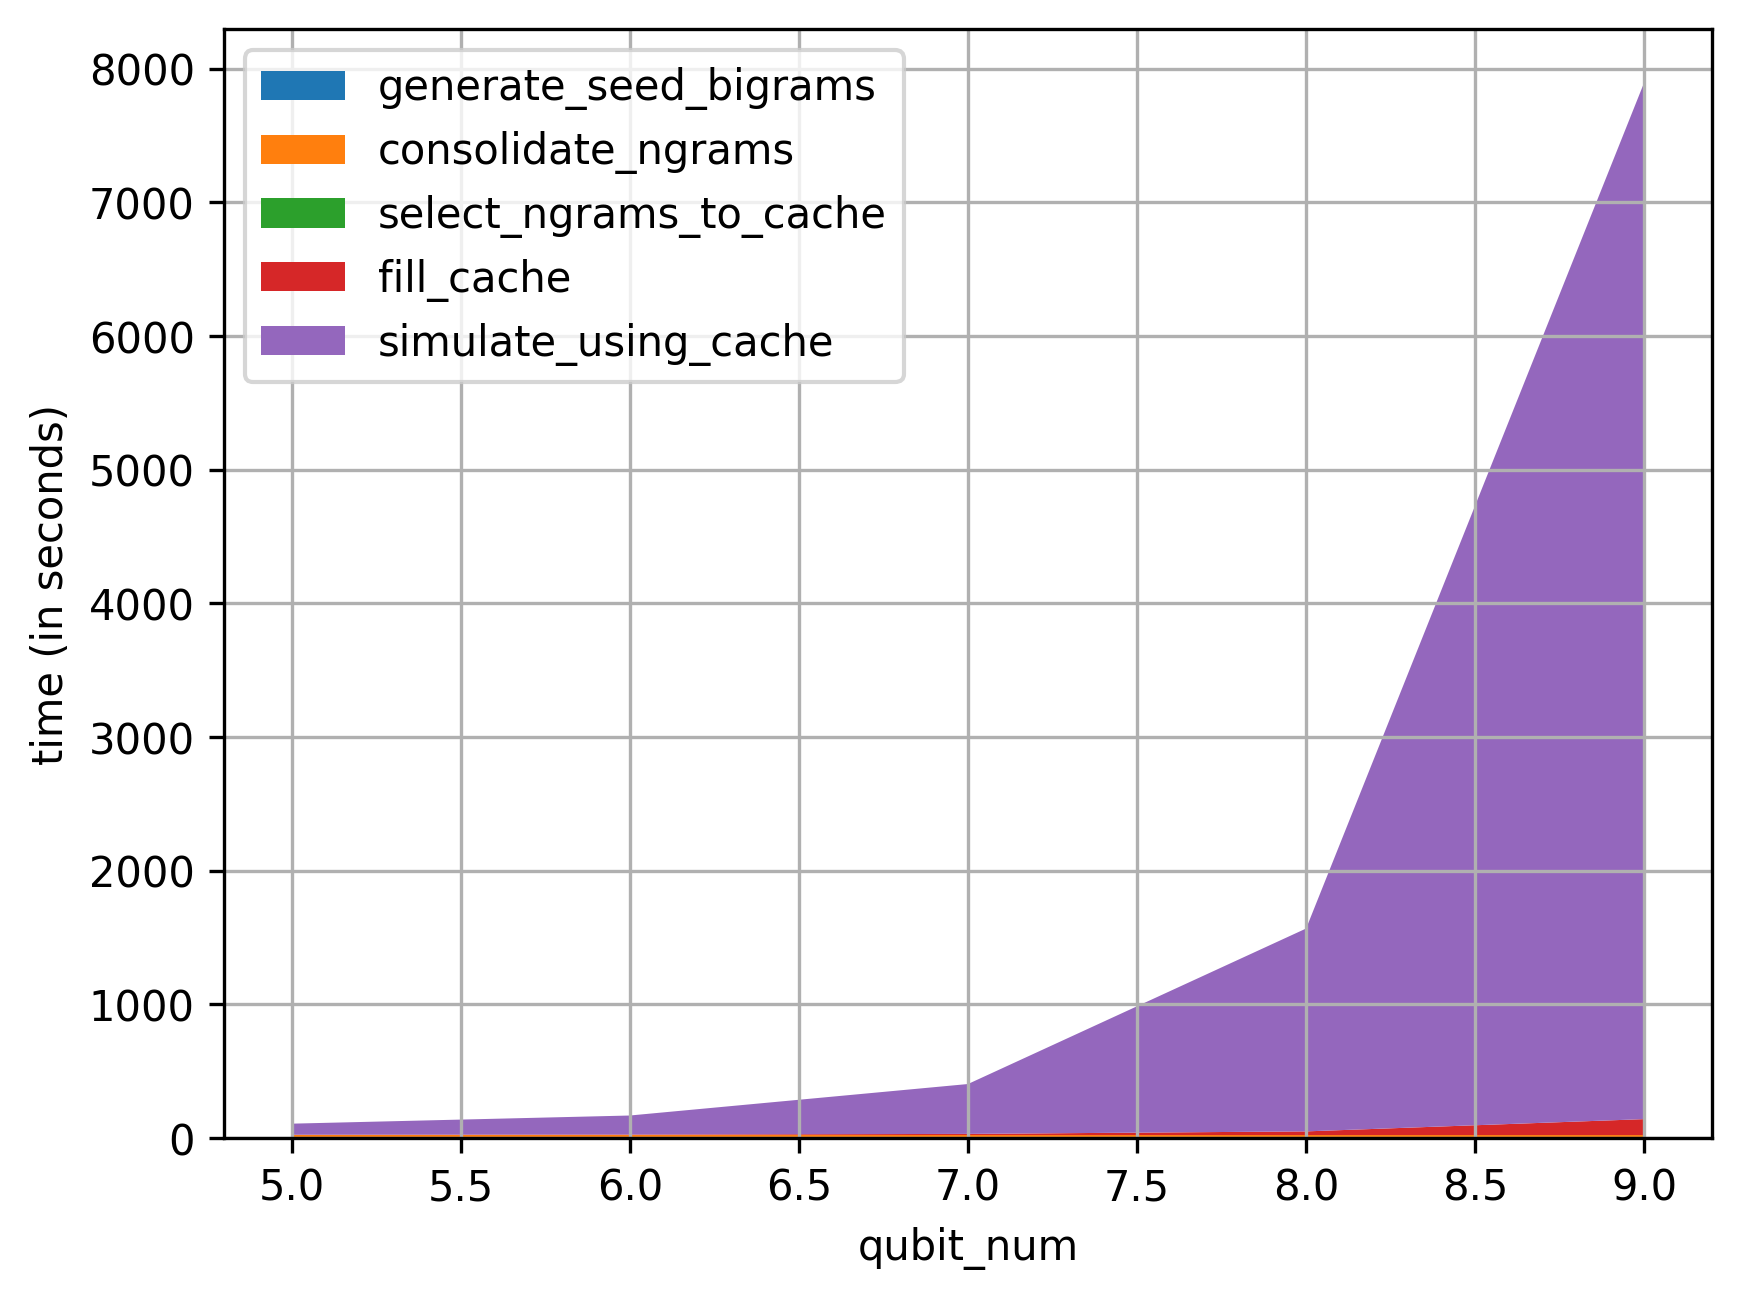

Components of total simulation time with 0.5 redundancy, averaged across seeds:


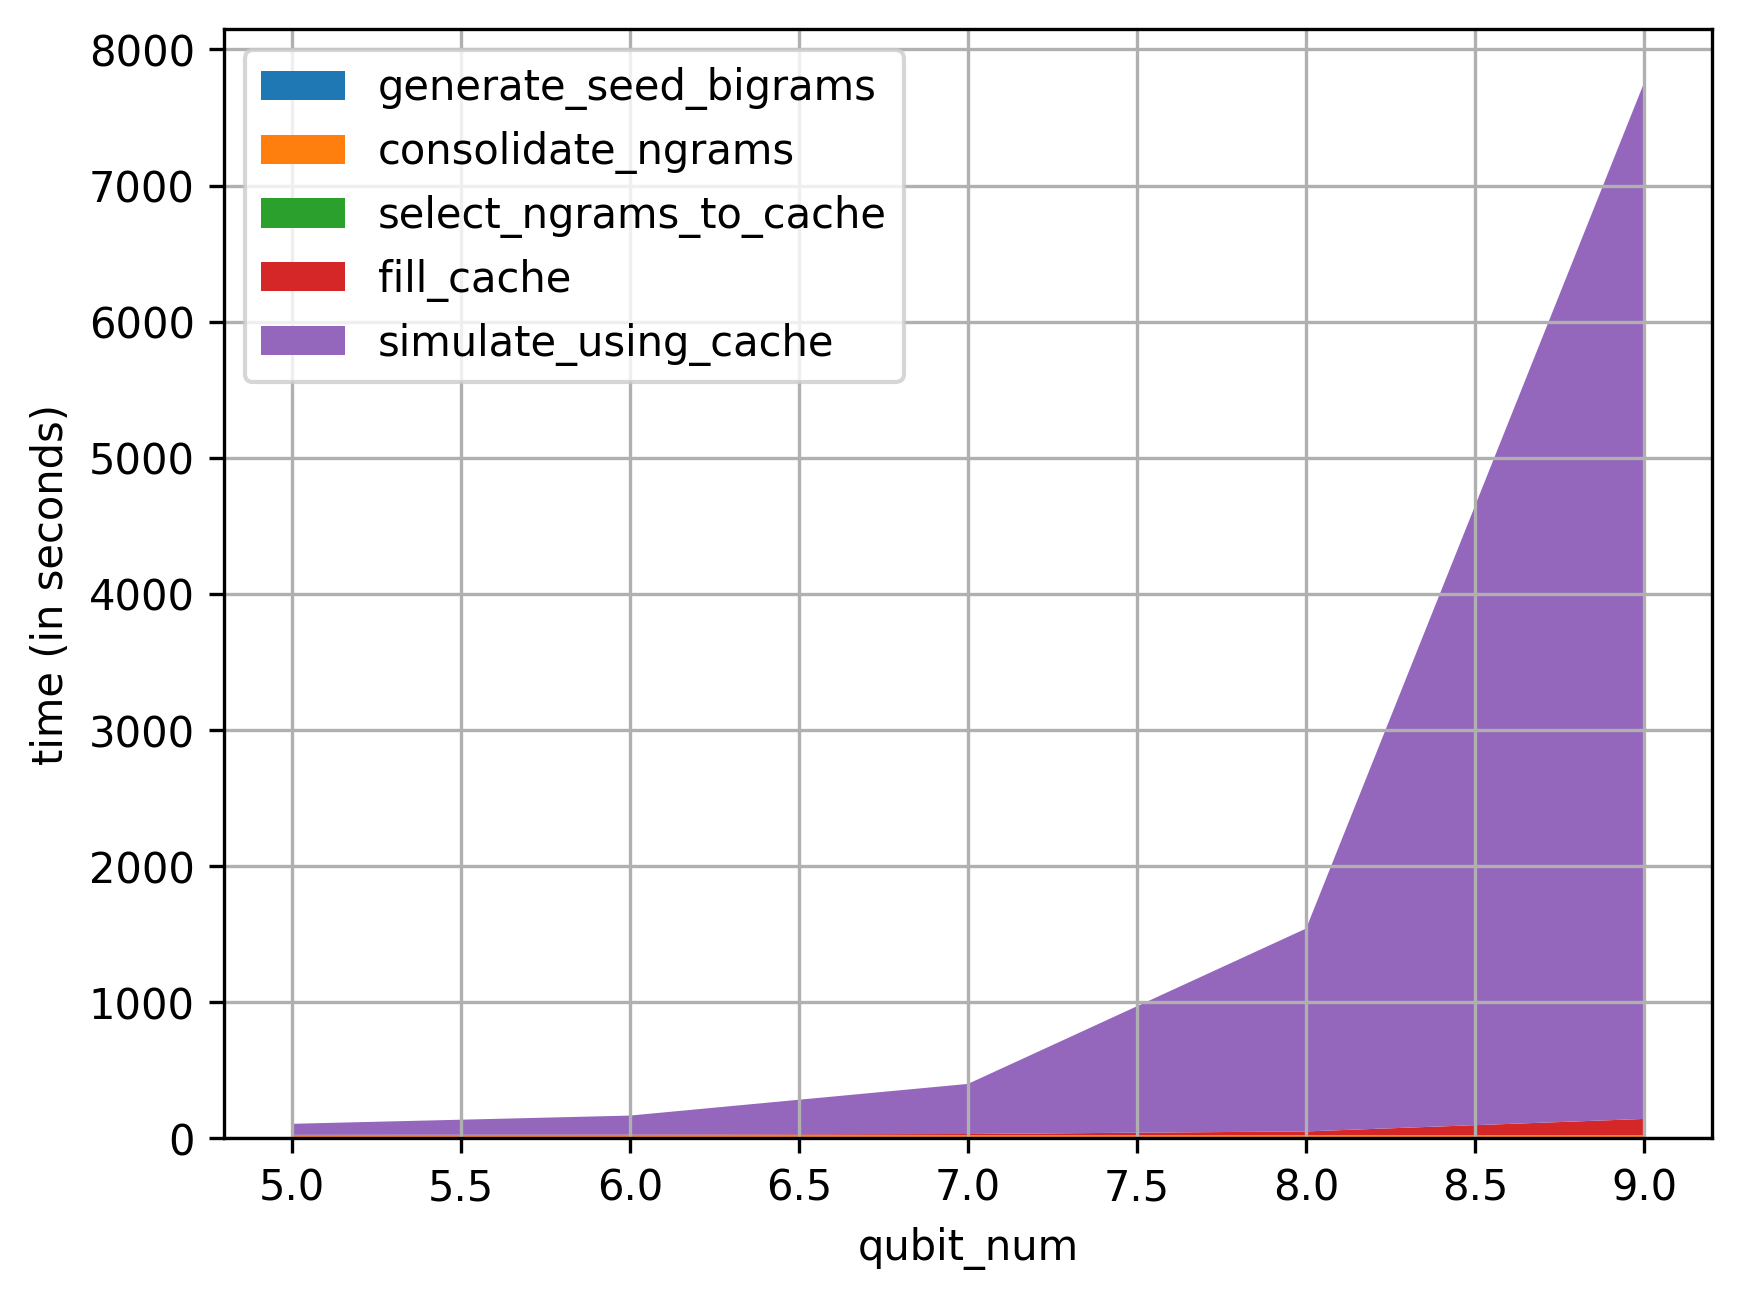

Components of total simulation time with 0.7 redundancy, averaged across seeds:


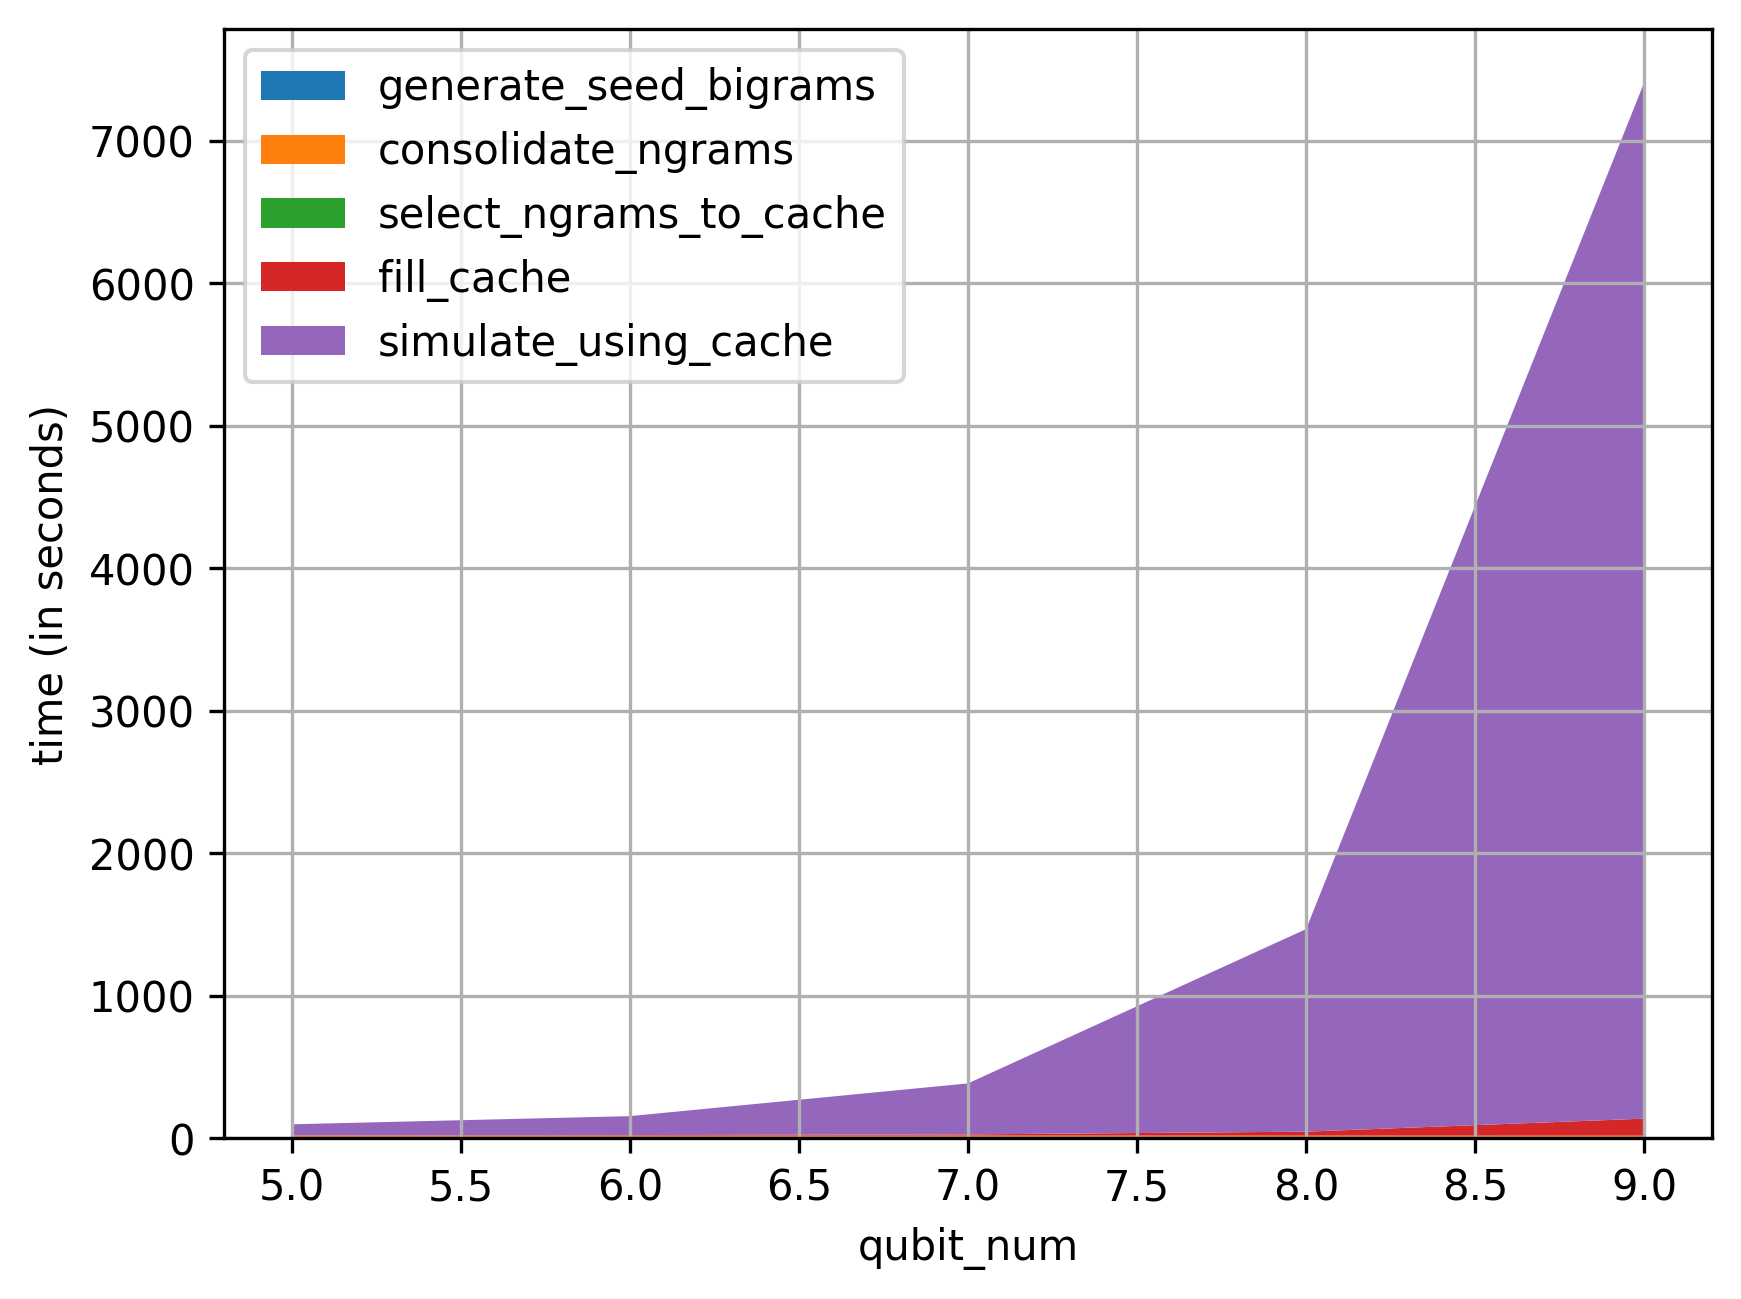

In [35]:
# Create a stack chart of the durations of different algorithm steps
# for all runs where cache size = 100.

for redundancy in redundancies:

    generate_seed_bigrams_durations = []
    consolidate_ngrams_durations = []
    select_ngrams_to_cache_durations = []
    fill_cache_durations = []
    simulate_using_cache_durations = []

    for qubit_num in qubit_nums:

        relevant_experiments = [
            experiment
            for experiment in vq_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["qubit_num"] == qubit_num
            and experiment["params"]["redundancy"] == redundancy
        ]

        generate_seed_bigrams_durations.append(
            mean(
                [
                    experiment["generate_seed_bigrams"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        consolidate_ngrams_durations.append(
            mean(
                [
                    experiment["consolidate_ngrams"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        select_ngrams_to_cache_durations.append(
            mean(
                [
                    experiment["select_ngrams_to_cache"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        fill_cache_durations.append(
            mean(
                [
                    experiment["fill_cache"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        simulate_using_cache_durations.append(
            mean(
                [
                    experiment["simulate_using_cache"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )

    x = qubit_nums
    y = np.vstack(
        [
            generate_seed_bigrams_durations,
            consolidate_ngrams_durations,
            select_ngrams_to_cache_durations,
            fill_cache_durations,
            simulate_using_cache_durations,
        ],
    )

    fig, ax = plt.subplots()

    ax.stackplot(x, y)
    ax.set_xlabel("qubit_num")
    ax.set_ylabel("time (in seconds)")

    printb(f"Components of total simulation time with {redundancy} redundancy, averaged across seeds:")

    plt.legend(
        [
            "generate_seed_bigrams",
            "consolidate_ngrams",
            "select_ngrams_to_cache",
            "fill_cache",
            "simulate_using_cache",
        ]
    )
    plt.grid()

    plt.savefig(f"{target_dir}/time_over_qubit_num_stacked_{redundancy}r.png")
    plt.show()

## RQ2.2: How does the amount of gates per circuit influence simulation speed?

In [36]:
# Filter out and format experiment results with the varying_gates tag

vg_experiments = [experiment for experiment in experiments if experiment["params"]["tag"] == "varying_gates"]
print(f"Total amount of varying_gates experiments: {len(vg_experiments)}")

Total amount of varying_gates experiments: 600


In [37]:
gate_counts = [experiment["params"]["gate_count"] for experiment in vg_experiments]
gate_counts = list(set(gate_counts))
gate_counts.sort()

print("Gate counts:", gate_counts)

Gate counts: [400, 800, 1200, 1600, 2000]


In [38]:
redundancies = [experiment["params"]["redundancy"] for experiment in vg_experiments]
redundancies = list(set(redundancies))
redundancies.sort()

print("Redundancies:", redundancies)

Redundancies: [0.1, 0.3, 0.5, 0.7]


Total simulation time with 0.1 redundancy, averaged across seeds:


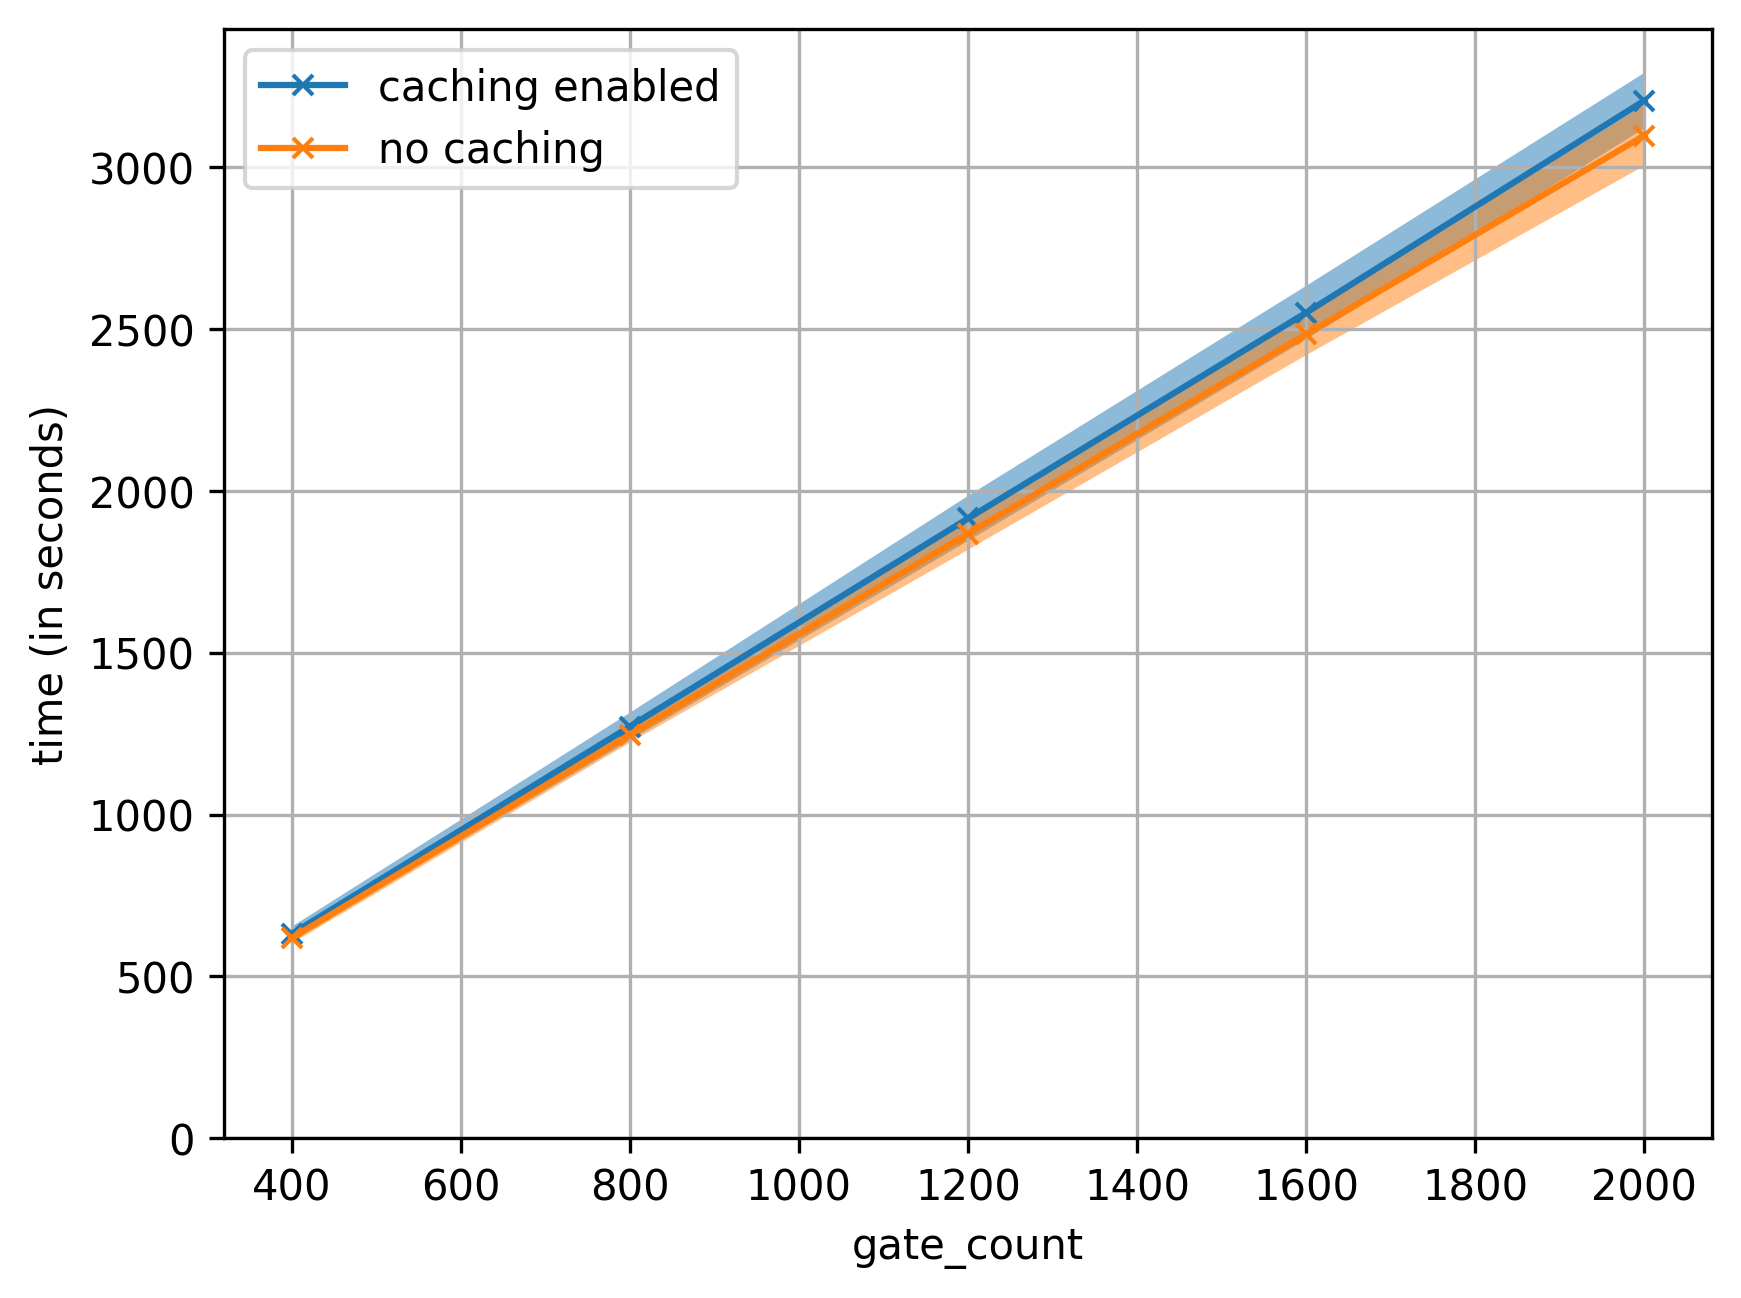

Total simulation time with 0.3 redundancy, averaged across seeds:


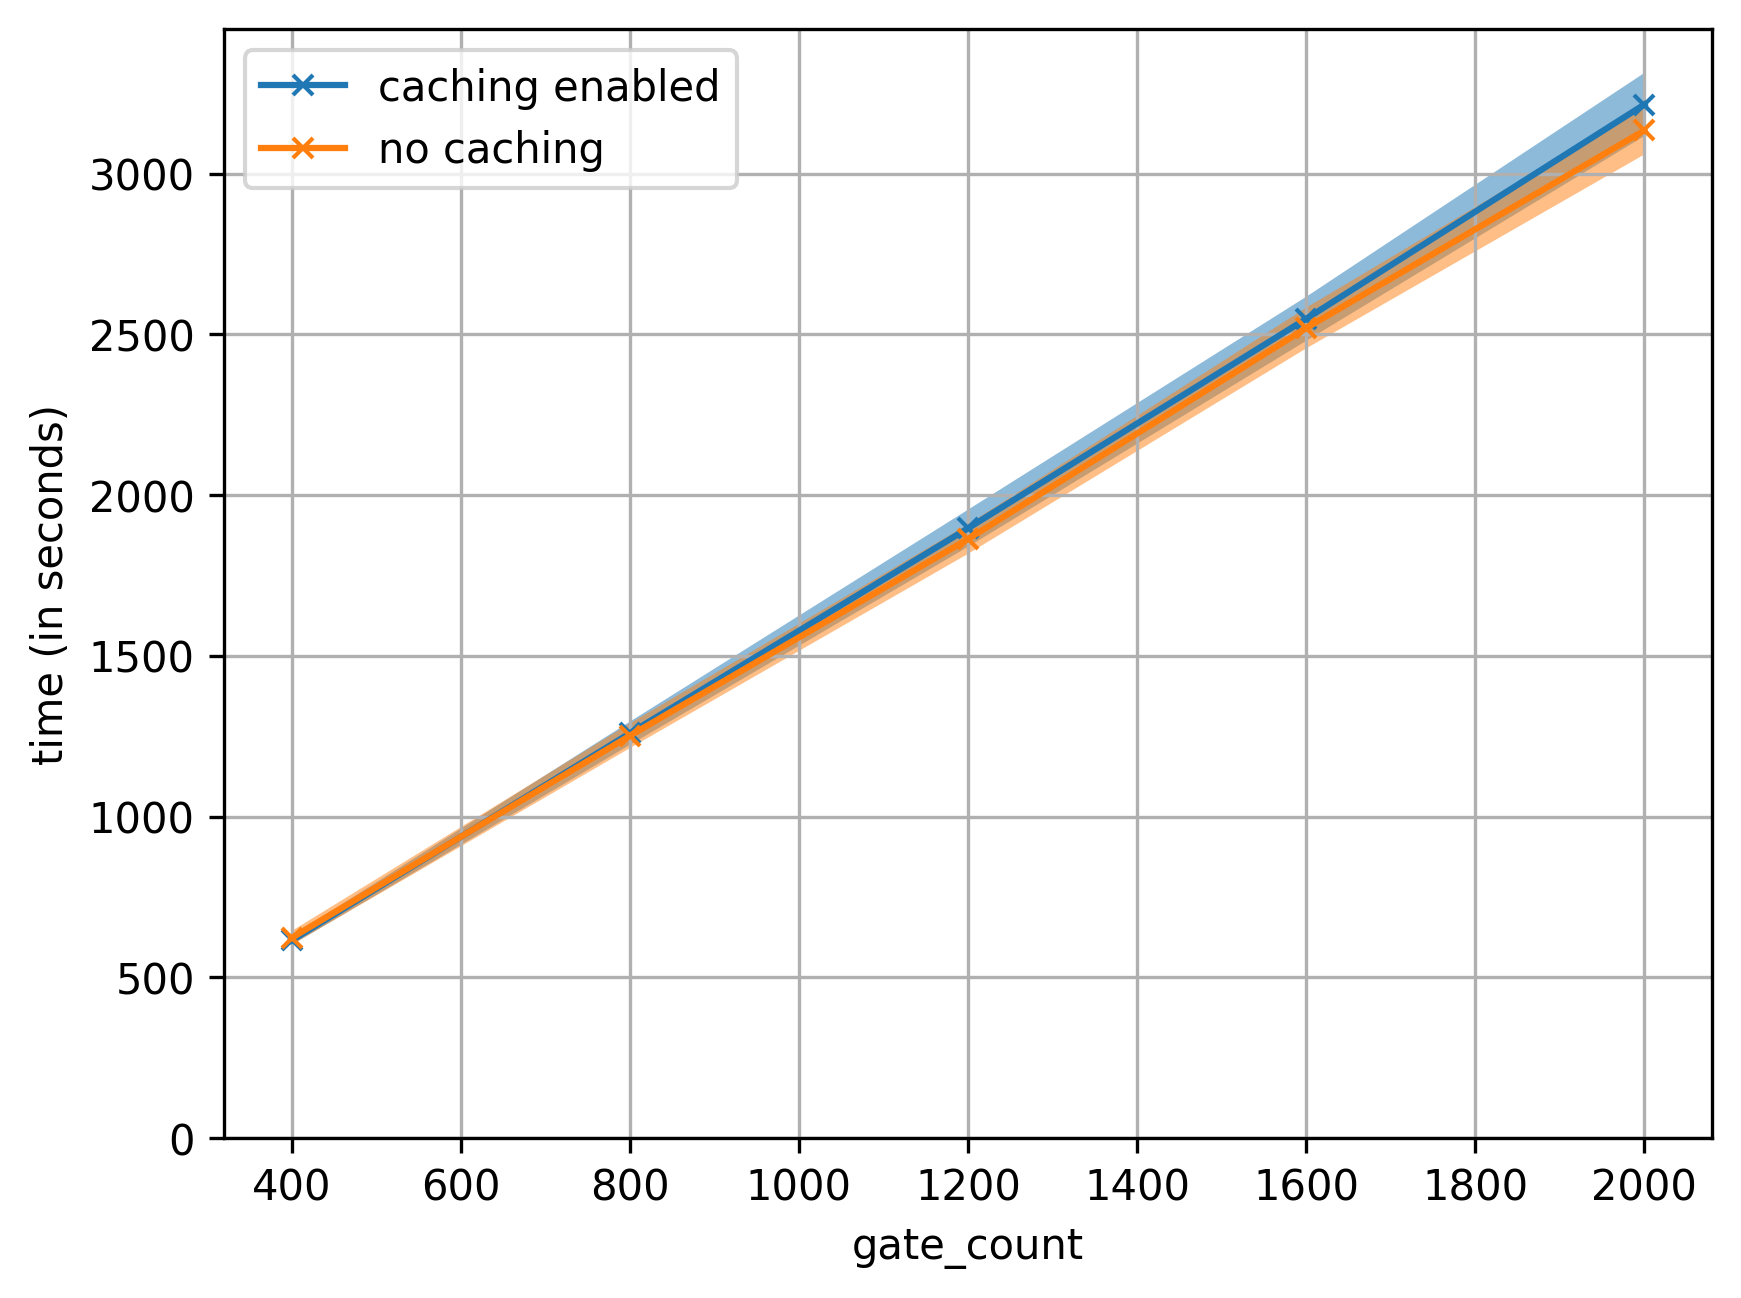

Total simulation time with 0.5 redundancy, averaged across seeds:


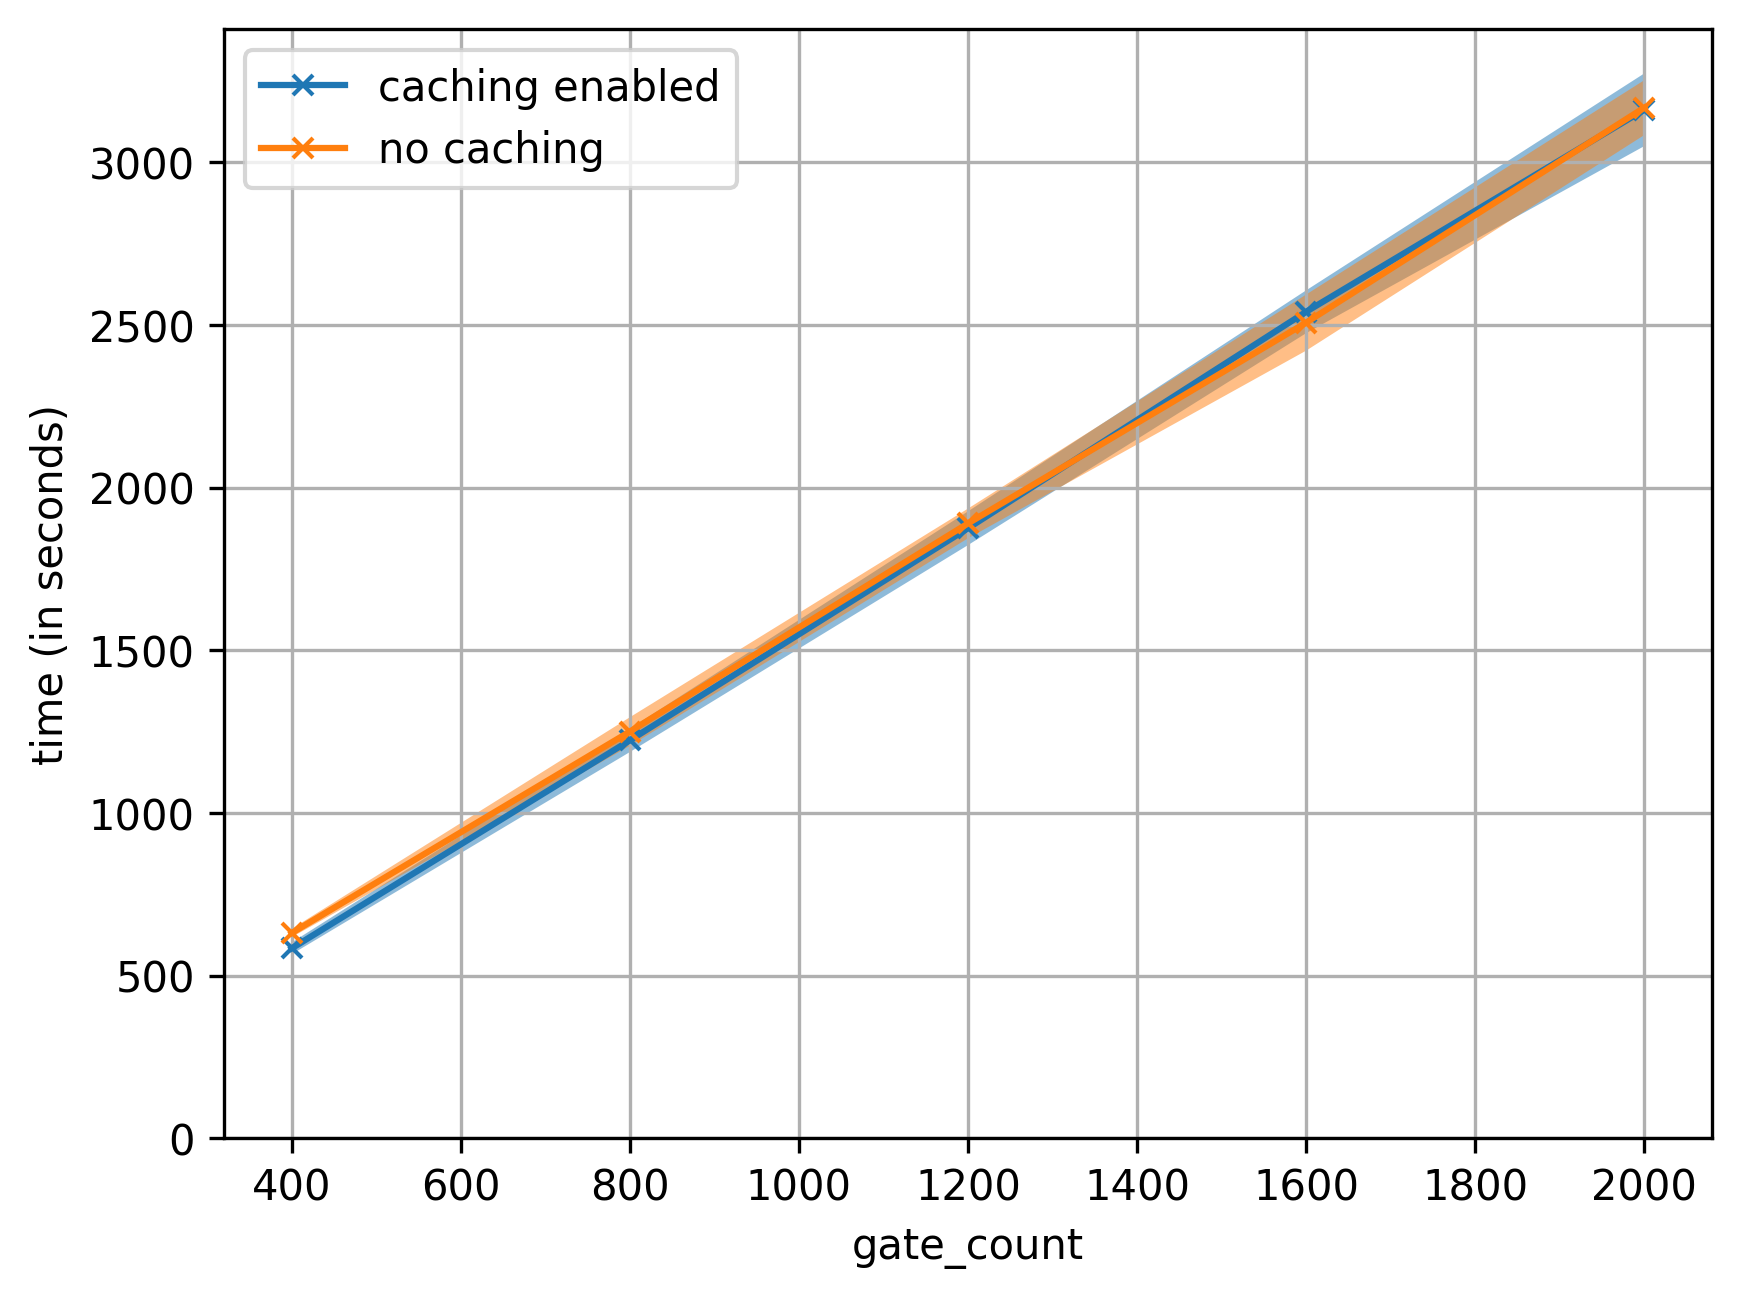

Total simulation time with 0.7 redundancy, averaged across seeds:


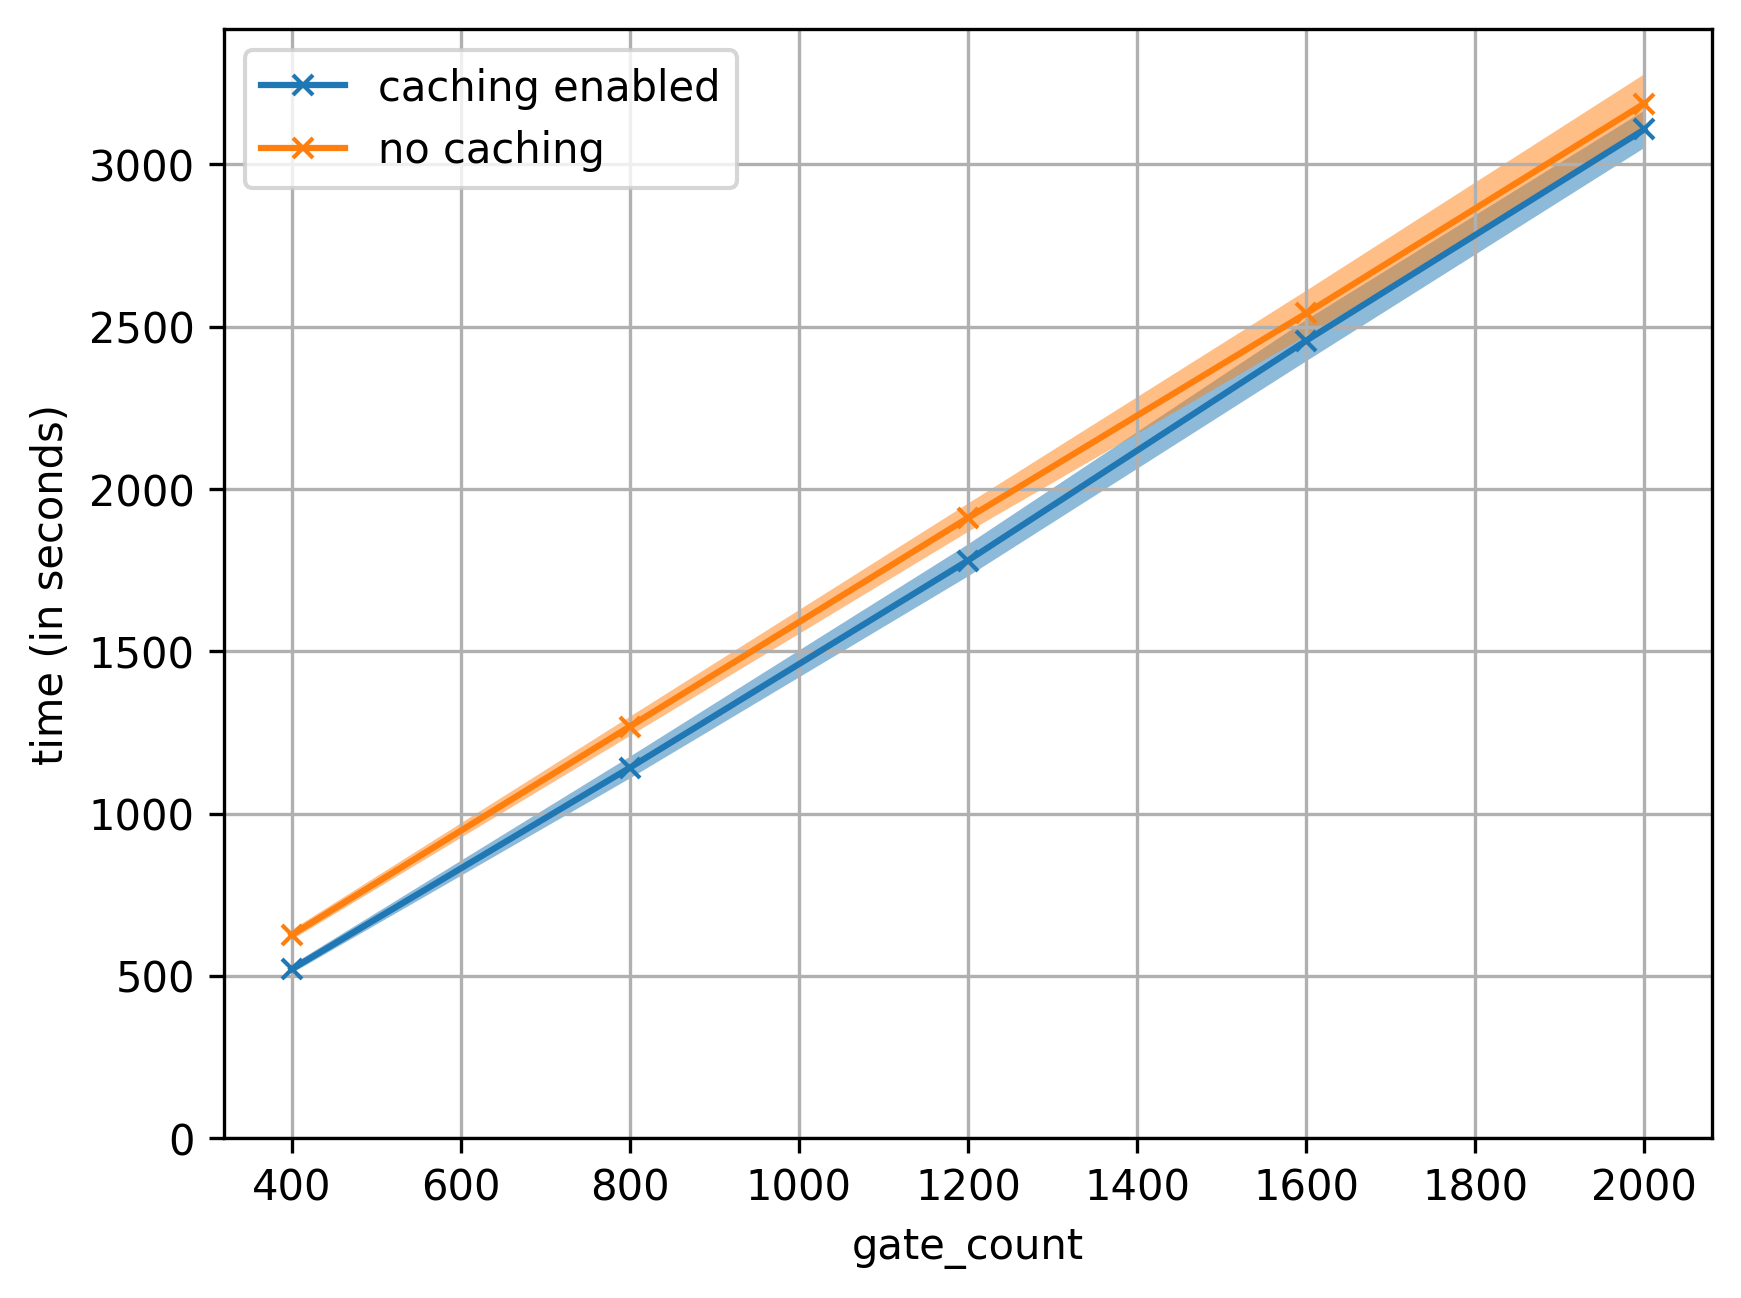

In [39]:
# Create a line chart with simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

for redundancy in redundancies:

    durations_no_cache = []
    stdevs_no_cache = []
    durations_with_cache = []
    stdevs_with_cache = []

    for gate_count in gate_counts:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]
        durations_no_cache.append(mean(sel_durations_no_cache))
        stdevs_no_cache.append(stdev(sel_durations_no_cache))

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]
        durations_with_cache.append(mean(sel_durations_with_cache))
        stdevs_with_cache.append(stdev(sel_durations_with_cache))

    ax = plt.subplot()
    
    ax.plot(gate_counts, durations_with_cache, label="caching enabled", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    lower_bounds_with_cache = [
        duration - sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
    ]
    upper_bounds_with_cache = [
        duration + sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
    ]
    ax.fill_between(
        gate_counts, lower_bounds_with_cache, upper_bounds_with_cache, alpha=0.5
    )

    ax.plot(gate_counts, durations_no_cache, label="no caching", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    lower_bounds_no_cache = [
        duration - sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
    ]
    upper_bounds_no_cache = [
        duration + sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
    ]
    ax.fill_between(
        gate_counts, lower_bounds_no_cache, upper_bounds_no_cache, alpha=0.5
    )

    ax.set_xlabel("gate_count")
    ax.set_ylabel("time (in seconds)")
    ax.set_ylim(0)

    printb(f"Total simulation time with {redundancy} redundancy, averaged across seeds:")

    plt.legend()
    plt.grid()
    plt.savefig(f"{target_dir}/total_time_over_gate_count_{redundancy}r.png")
    plt.show()


In [40]:
# Compute Mann Whitney U test statistics between with and without caching.

from scipy.stats import mannwhitneyu

printb("Mann-Whitney U test p-values")

for redundancy in redundancies:

    for gate_count in gate_counts:

        sel_durations_no_cache = [
            experiment["total_duration"]
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]

        sel_durations_with_cache = [
            experiment["total_duration"]
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]

        U, p = mannwhitneyu(sel_durations_with_cache, sel_durations_no_cache)

        print(f"P-value for redundancy of {redundancy} and {gate_count} gates: {p:.6f}")

        effect_size, interpretation = compute_a12(sel_durations_with_cache, sel_durations_no_cache)
        print(f"Effect size: {effect_size} ({interpretation})")

    print("")


Mann-Whitney U test p-values
P-value for redundancy of 0.1 and 400 gates: 0.114987
Effect size: 0.6711111111111111 (medium)
P-value for redundancy of 0.1 and 800 gates: 0.074496
Effect size: 0.6933333333333332 (medium)
P-value for redundancy of 0.1 and 1200 gates: 0.089018
Effect size: 0.6844444444444444 (medium)
P-value for redundancy of 0.1 and 1600 gates: 0.042111
Effect size: 0.7200000000000001 (medium)
P-value for redundancy of 0.1 and 2000 gates: 0.003230
Effect size: 0.8177777777777777 (large)

P-value for redundancy of 0.3 and 400 gates: 0.455302
Effect size: 0.41777777777777786 (small)
P-value for redundancy of 0.3 and 800 gates: 0.480731
Effect size: 0.5777777777777778 (small)
P-value for redundancy of 0.3 and 1200 gates: 0.097091
Effect size: 0.6799999999999999 (medium)
P-value for redundancy of 0.3 and 1600 gates: 0.361496
Effect size: 0.6 (small)
P-value for redundancy of 0.3 and 2000 gates: 0.012822
Effect size: 0.768888888888889 (large)

P-value for redundancy of 0.5 and

Net simulation time with 0.1 redundancy, averaged across seeds:


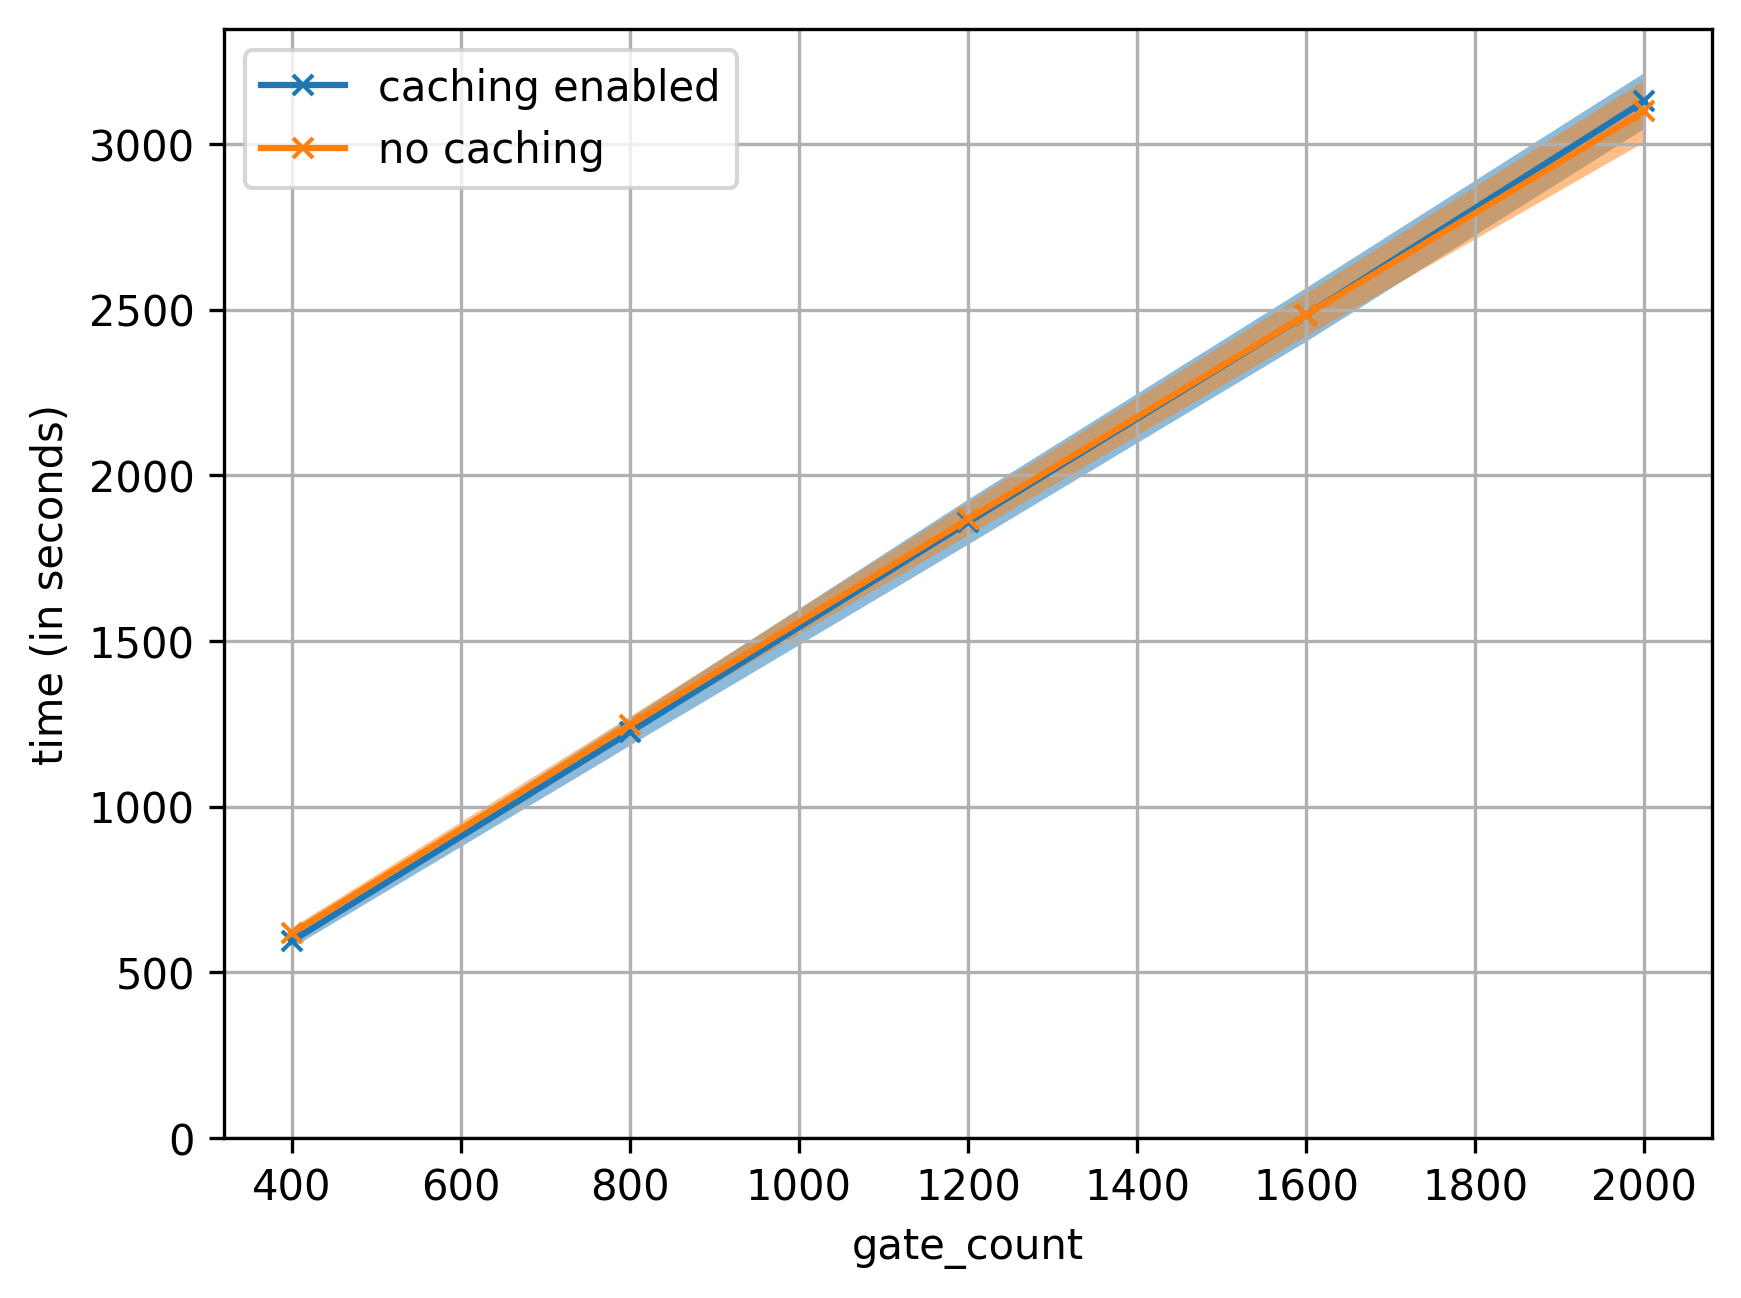

Net simulation time with 0.3 redundancy, averaged across seeds:


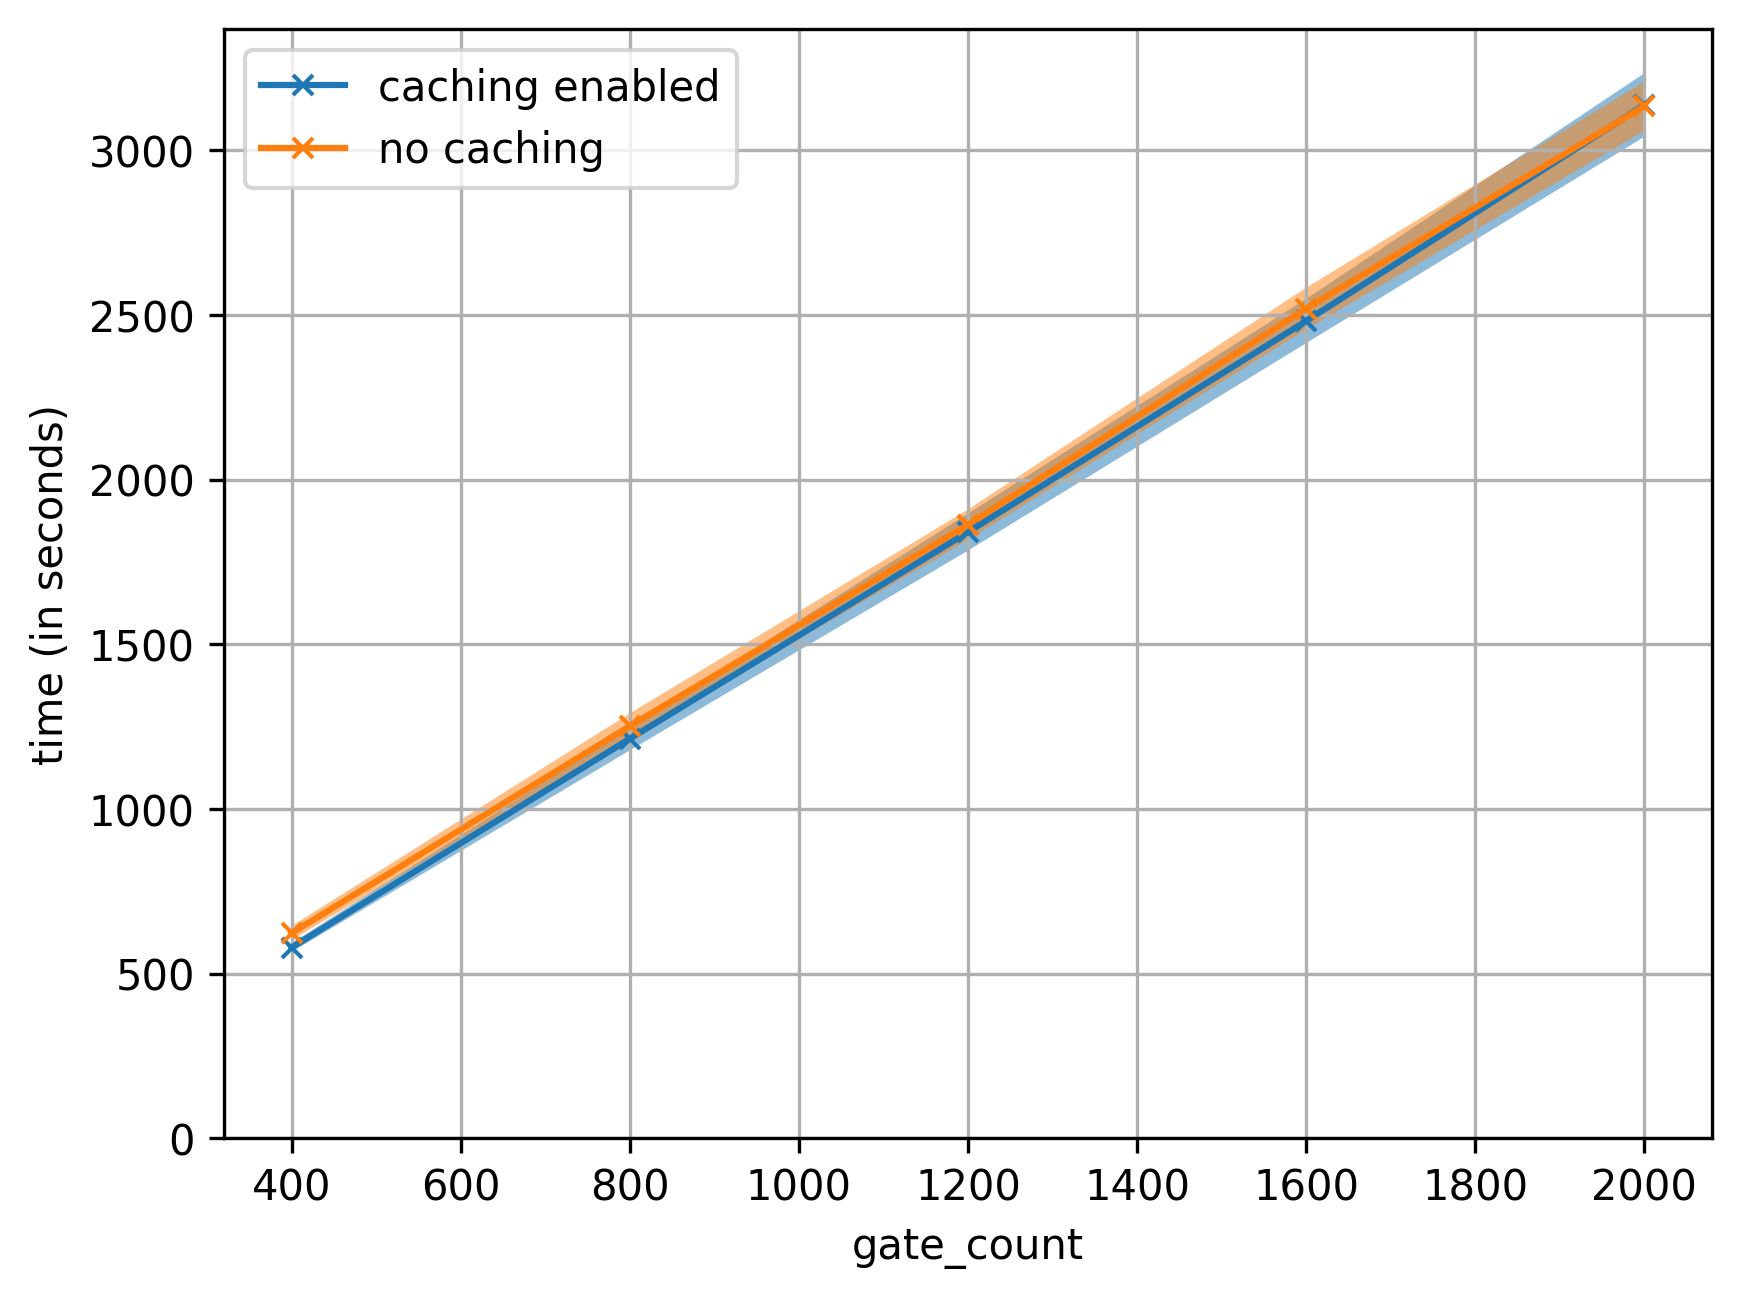

Net simulation time with 0.5 redundancy, averaged across seeds:


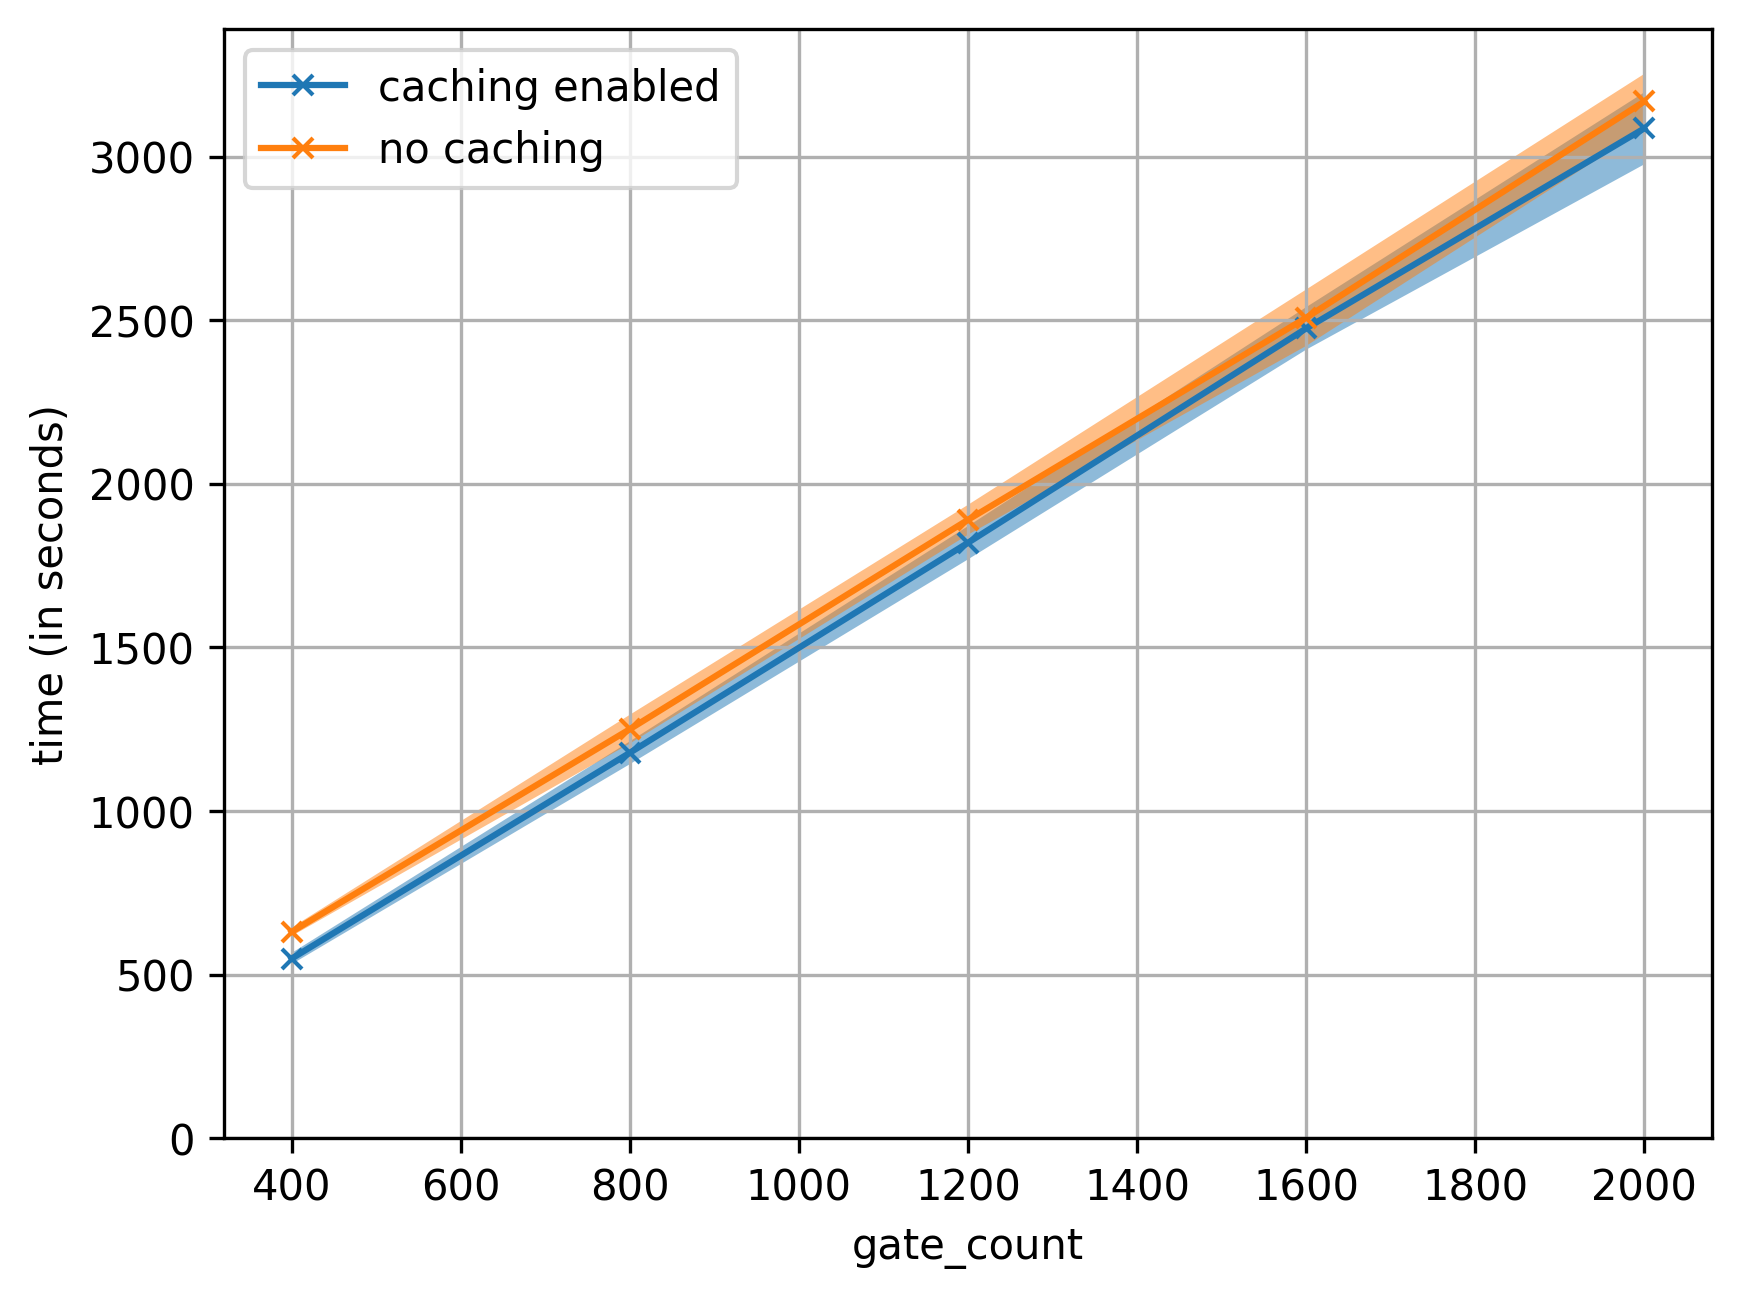

Net simulation time with 0.7 redundancy, averaged across seeds:


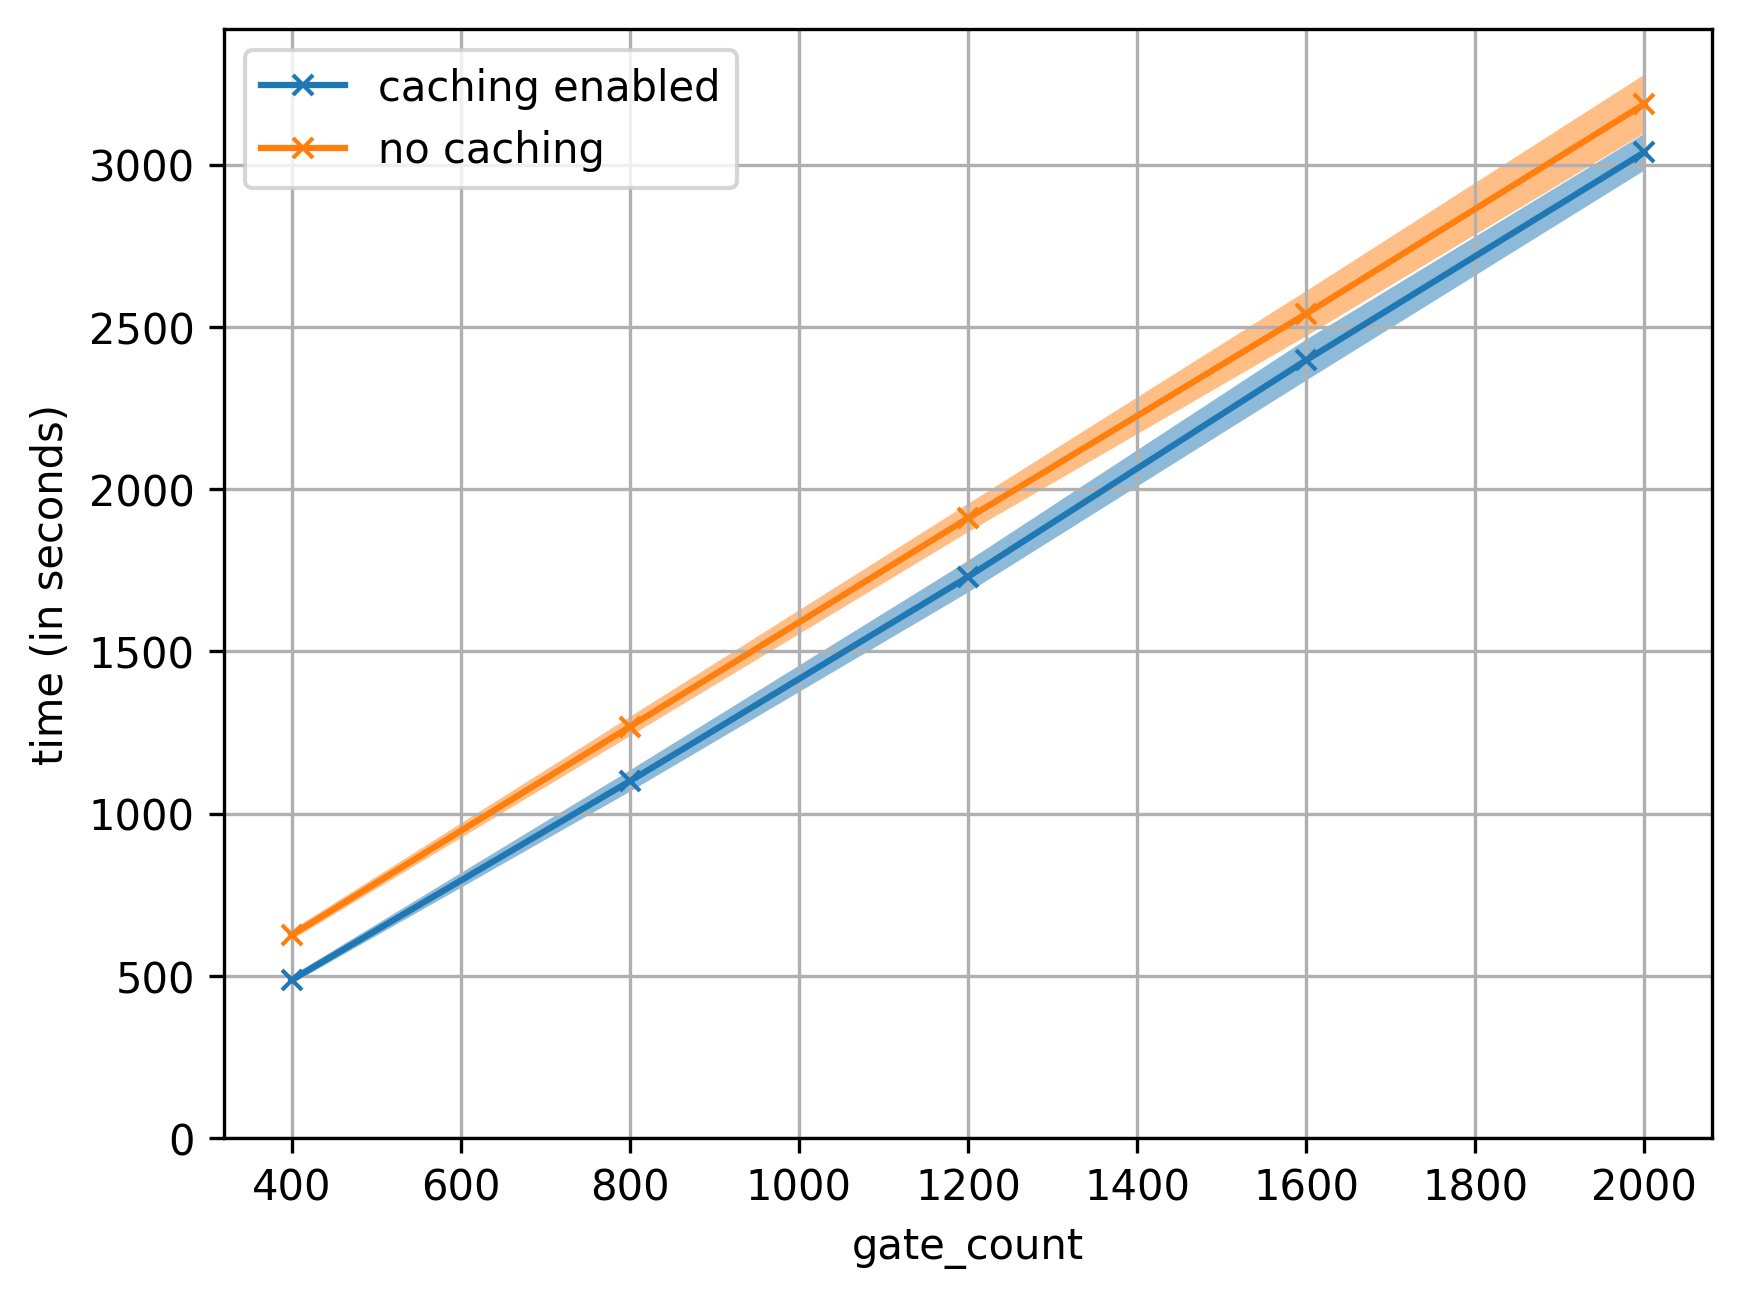

In [41]:
# Create a line chart with net simulation time on y and gate count per circuit 
# on x. One line for the runs with caching enabled, one line for the 
# runs with cache size 0.

for redundancy in redundancies:

    durations_no_cache = []
    stdevs_no_cache = []
    durations_with_cache = []
    stdevs_with_cache = []

    for gate_count in gate_counts:

        sel_durations_no_cache = [
            experiment["simulate_without_cache"]["duration"]
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] == 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]
        durations_no_cache.append(mean(sel_durations_no_cache))
        stdevs_no_cache.append(stdev(sel_durations_no_cache))

        sel_durations_with_cache = [
            experiment["simulate_using_cache"]["duration"]
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]
        durations_with_cache.append(mean(sel_durations_with_cache))
        stdevs_with_cache.append(stdev(sel_durations_with_cache))

    ax = plt.subplot()

    ax.plot(gate_counts, durations_with_cache, label="caching enabled", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    lower_bounds_with_cache = [
        duration - sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
    ]
    upper_bounds_with_cache = [
        duration + sigma for (duration, sigma) in zip(durations_with_cache, stdevs_with_cache)
    ]
    ax.fill_between(
        gate_counts, lower_bounds_with_cache, upper_bounds_with_cache, alpha=0.5
    )

    ax.plot(gate_counts, durations_no_cache, label="no caching", marker=LINECHART_MARKER, markersize=LINECHART_MARKER_SIZE)
    lower_bounds_no_cache = [
        duration - sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
    ]
    upper_bounds_no_cache = [
        duration + sigma for (duration, sigma) in zip(durations_no_cache, stdevs_no_cache)
    ]
    ax.fill_between(
        gate_counts, lower_bounds_no_cache, upper_bounds_no_cache, alpha=0.5
    )

    ax.set_xlabel("gate_count")
    ax.set_ylabel("time (in seconds)")
    ax.set_ylim(0)


    printb(f"Net simulation time with {redundancy} redundancy, averaged across seeds:")
    plt.legend()
    plt.grid()
    plt.savefig(f"{target_dir}/net_time_over_gate_count_{redundancy}r.png")
    plt.show()


Components of total simulation time with 0.1 redundancy, averaged across seeds:
generate_seed_bigrams_durations: [1.9591247999999999, 4.342139933333334, 6.127730266666667, 8.663000533333333, 10.769043733333334]
consolidate_ngrams_durations: [7.429954666666666, 15.194995266666666, 23.1037296, 30.852967266666667, 38.6750428]
select_ngrams_to_cache_durations: [0.0173536, 0.0326764, 0.04983833333333333, 0.06661306666666666, 0.0833812]
fill_cache_durations: [27.262774066666665, 27.23723933333333, 27.2442326, 27.289460866666666, 27.28054746666667]
simulate_using_cache_durations: [594.3150448666667, 1225.0224454, 1858.3788098, 2483.9815461333333, 3129.4137078666668]
gate_counts: [400, 800, 1200, 1600, 2000]


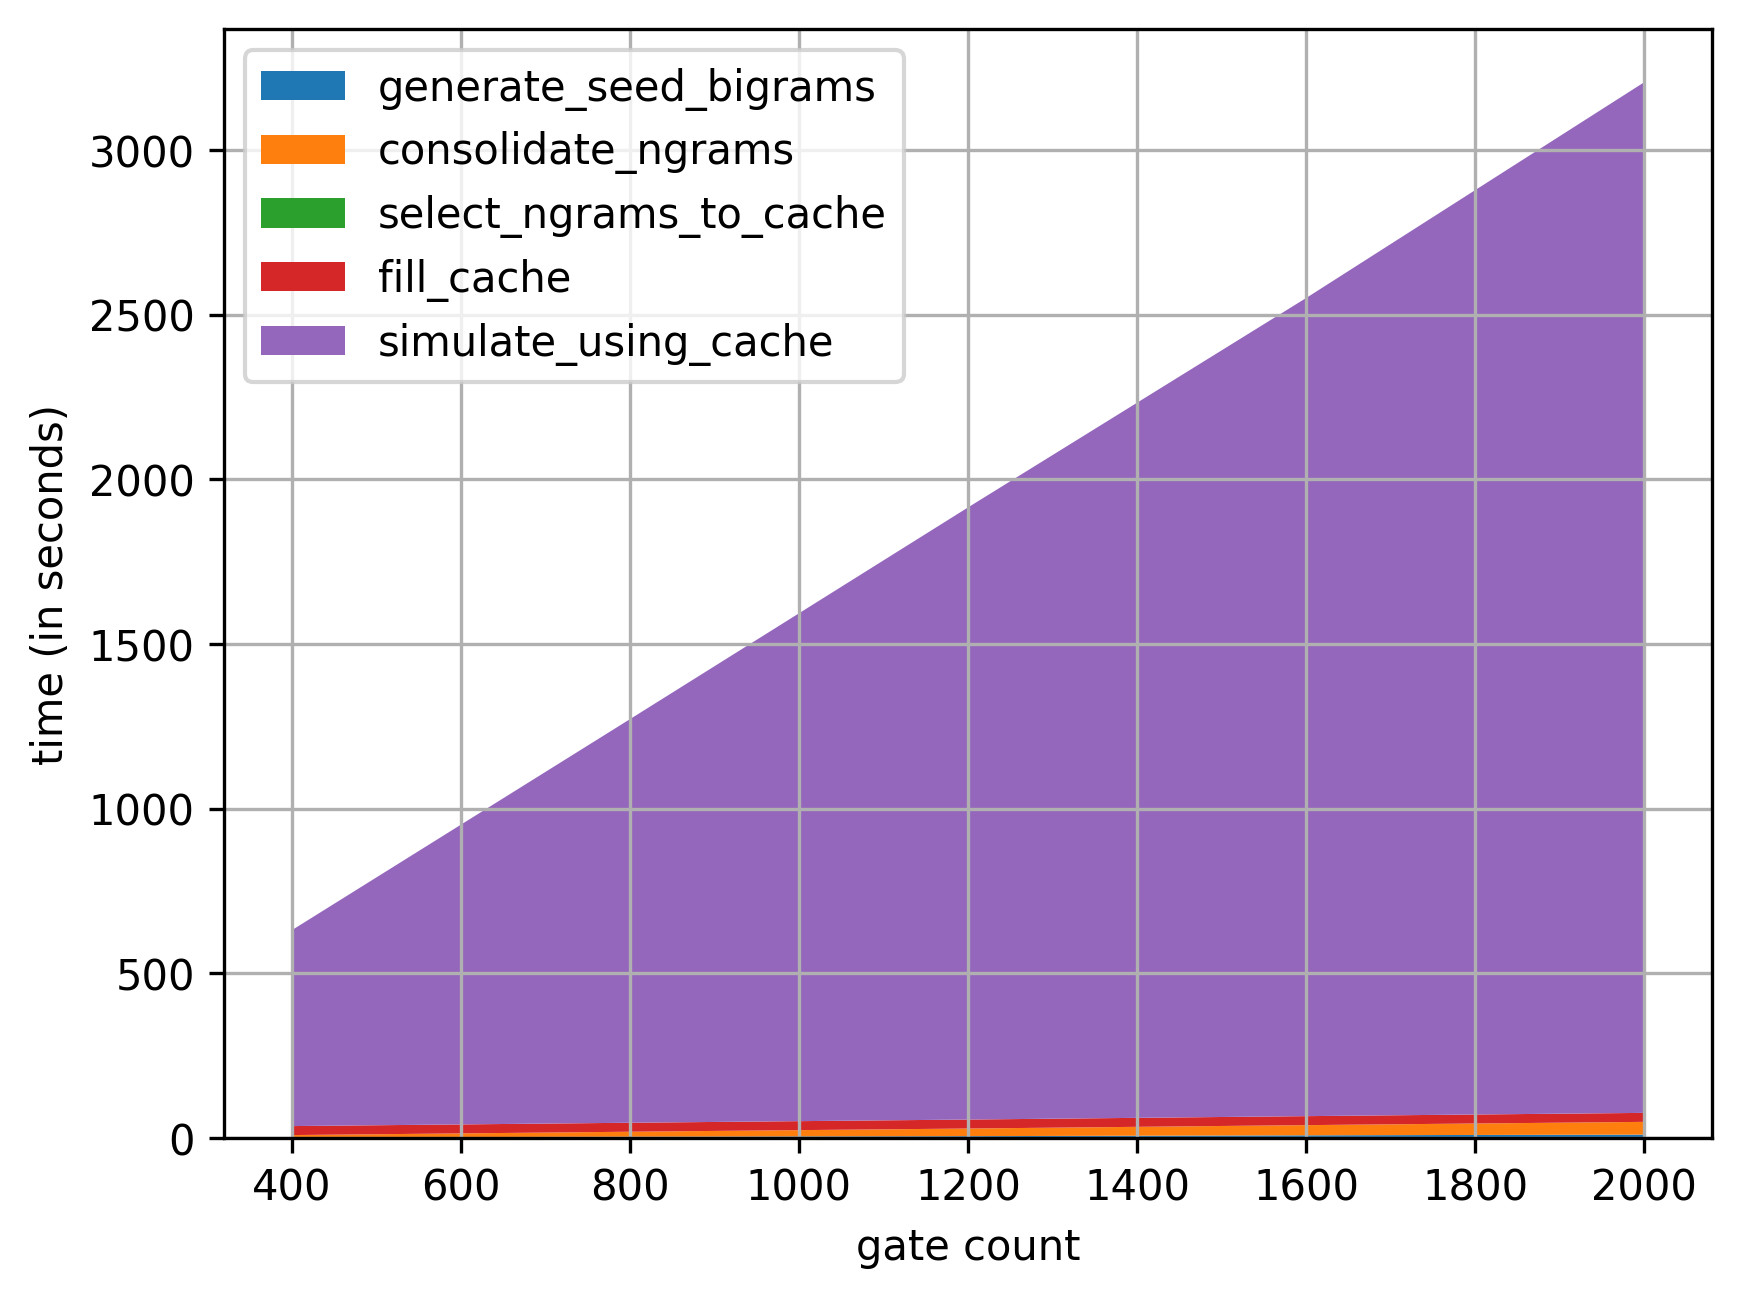

Components of total simulation time with 0.3 redundancy, averaged across seeds:
generate_seed_bigrams_durations: [1.8140973333333335, 3.7032448, 6.157995866666667, 8.078145533333334, 10.1489158]
consolidate_ngrams_durations: [6.746910066666667, 15.075462133333334, 22.4945172, 30.939066933333333, 39.2420168]
select_ngrams_to_cache_durations: [0.020664066666666668, 0.04383953333333333, 0.06682026666666667, 0.0897394, 0.11452986666666666]
fill_cache_durations: [27.3610658, 27.243787266666665, 27.256129066666666, 27.1617308, 27.42396653333333]
simulate_using_cache_durations: [578.8257656666667, 1212.8215158666667, 1840.5499425333333, 2481.5358316, 3137.3950560666667]
gate_counts: [400, 800, 1200, 1600, 2000]


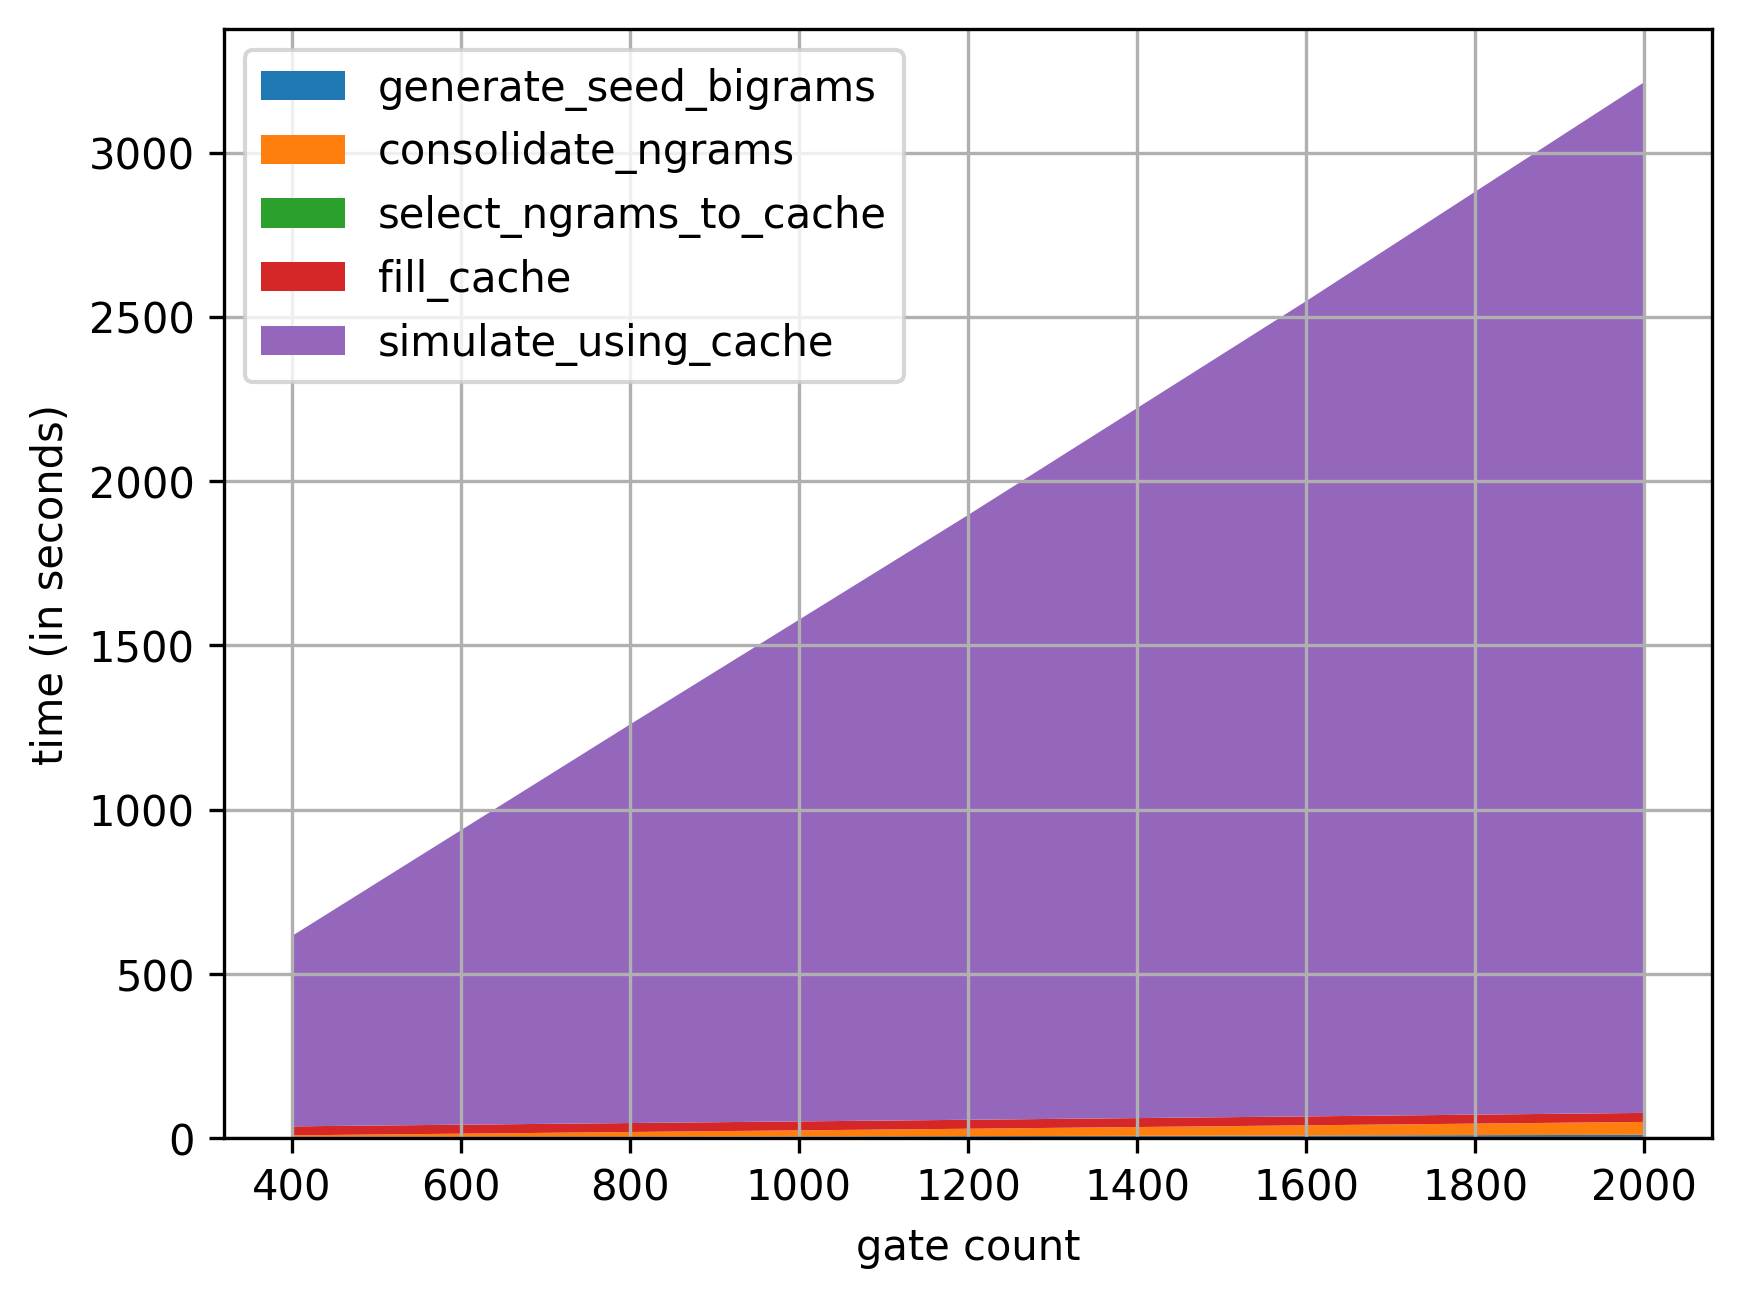

Components of total simulation time with 0.5 redundancy, averaged across seeds:
generate_seed_bigrams_durations: [1.7356608666666666, 3.5245352666666667, 5.740732666666667, 7.705536, 9.655013199999999]
consolidate_ngrams_durations: [5.3160810666666665, 14.014089066666667, 21.75297, 30.242711133333334, 37.9530744]
select_ngrams_to_cache_durations: [0.020964466666666667, 0.053595666666666666, 0.07794486666666667, 0.10491886666666667, 0.13780693333333333]
fill_cache_durations: [27.4797698, 27.378211333333333, 27.655234133333334, 27.651970666666667, 27.436935866666666]
simulate_using_cache_durations: [548.7551435333334, 1177.7690233333333, 1819.6943466, 2474.7576117999997, 3086.329082]
gate_counts: [400, 800, 1200, 1600, 2000]


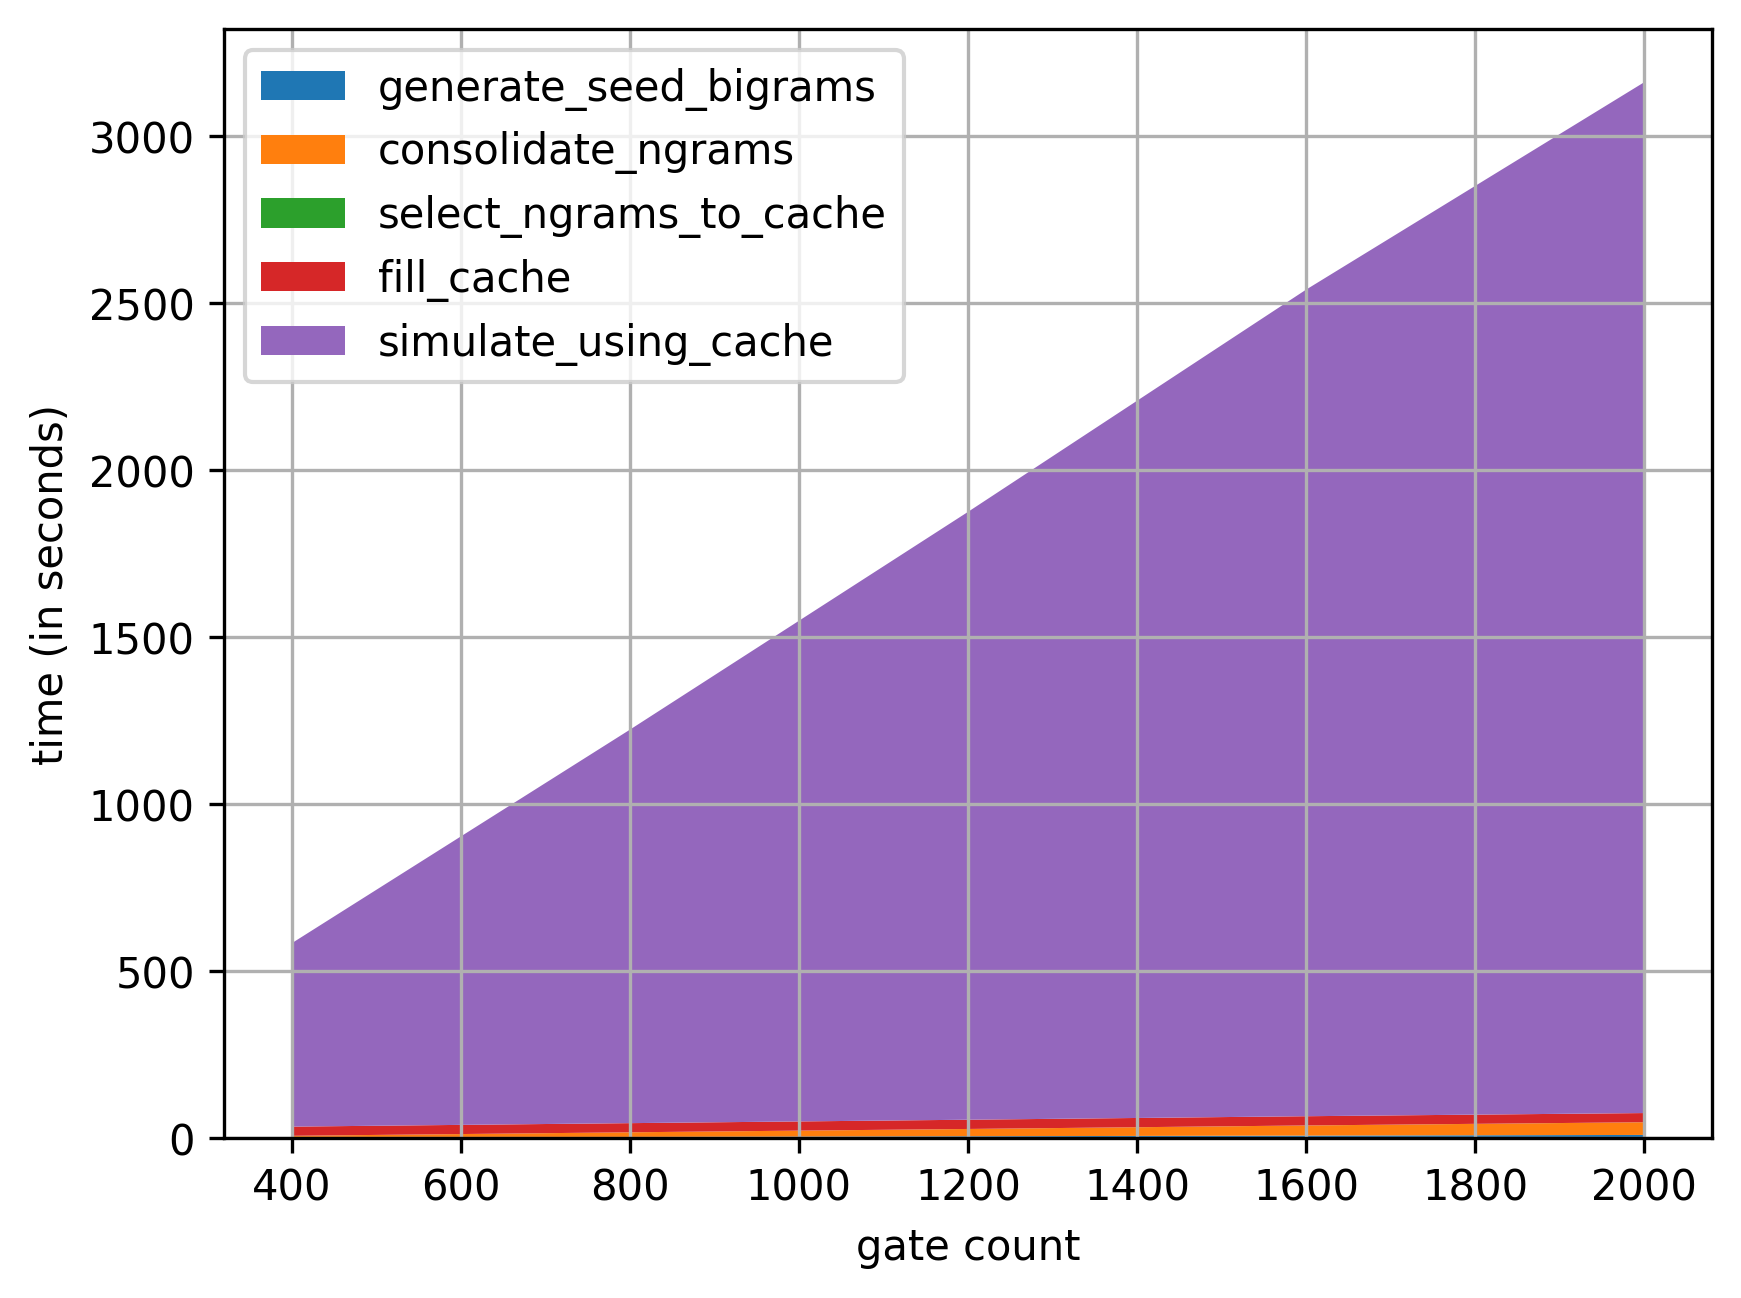

Components of total simulation time with 0.7 redundancy, averaged across seeds:
generate_seed_bigrams_durations: [1.6622382, 3.3471269333333336, 5.6249584666666665, 7.2920628, 9.253736333333332]
consolidate_ngrams_durations: [3.6492398666666666, 9.9629454, 16.10485346666667, 23.3946306, 31.1569462]
select_ngrams_to_cache_durations: [0.015196466666666667, 0.04211513333333333, 0.07056586666666667, 0.09819106666666666, 0.1283374]
fill_cache_durations: [27.461320733333334, 27.3548582, 27.431526466666668, 27.830995466666668, 27.886531066666667]
simulate_using_cache_durations: [487.4064752666667, 1100.1380330666666, 1729.7990652666667, 2397.5088920666667, 3038.3661420666667]
gate_counts: [400, 800, 1200, 1600, 2000]


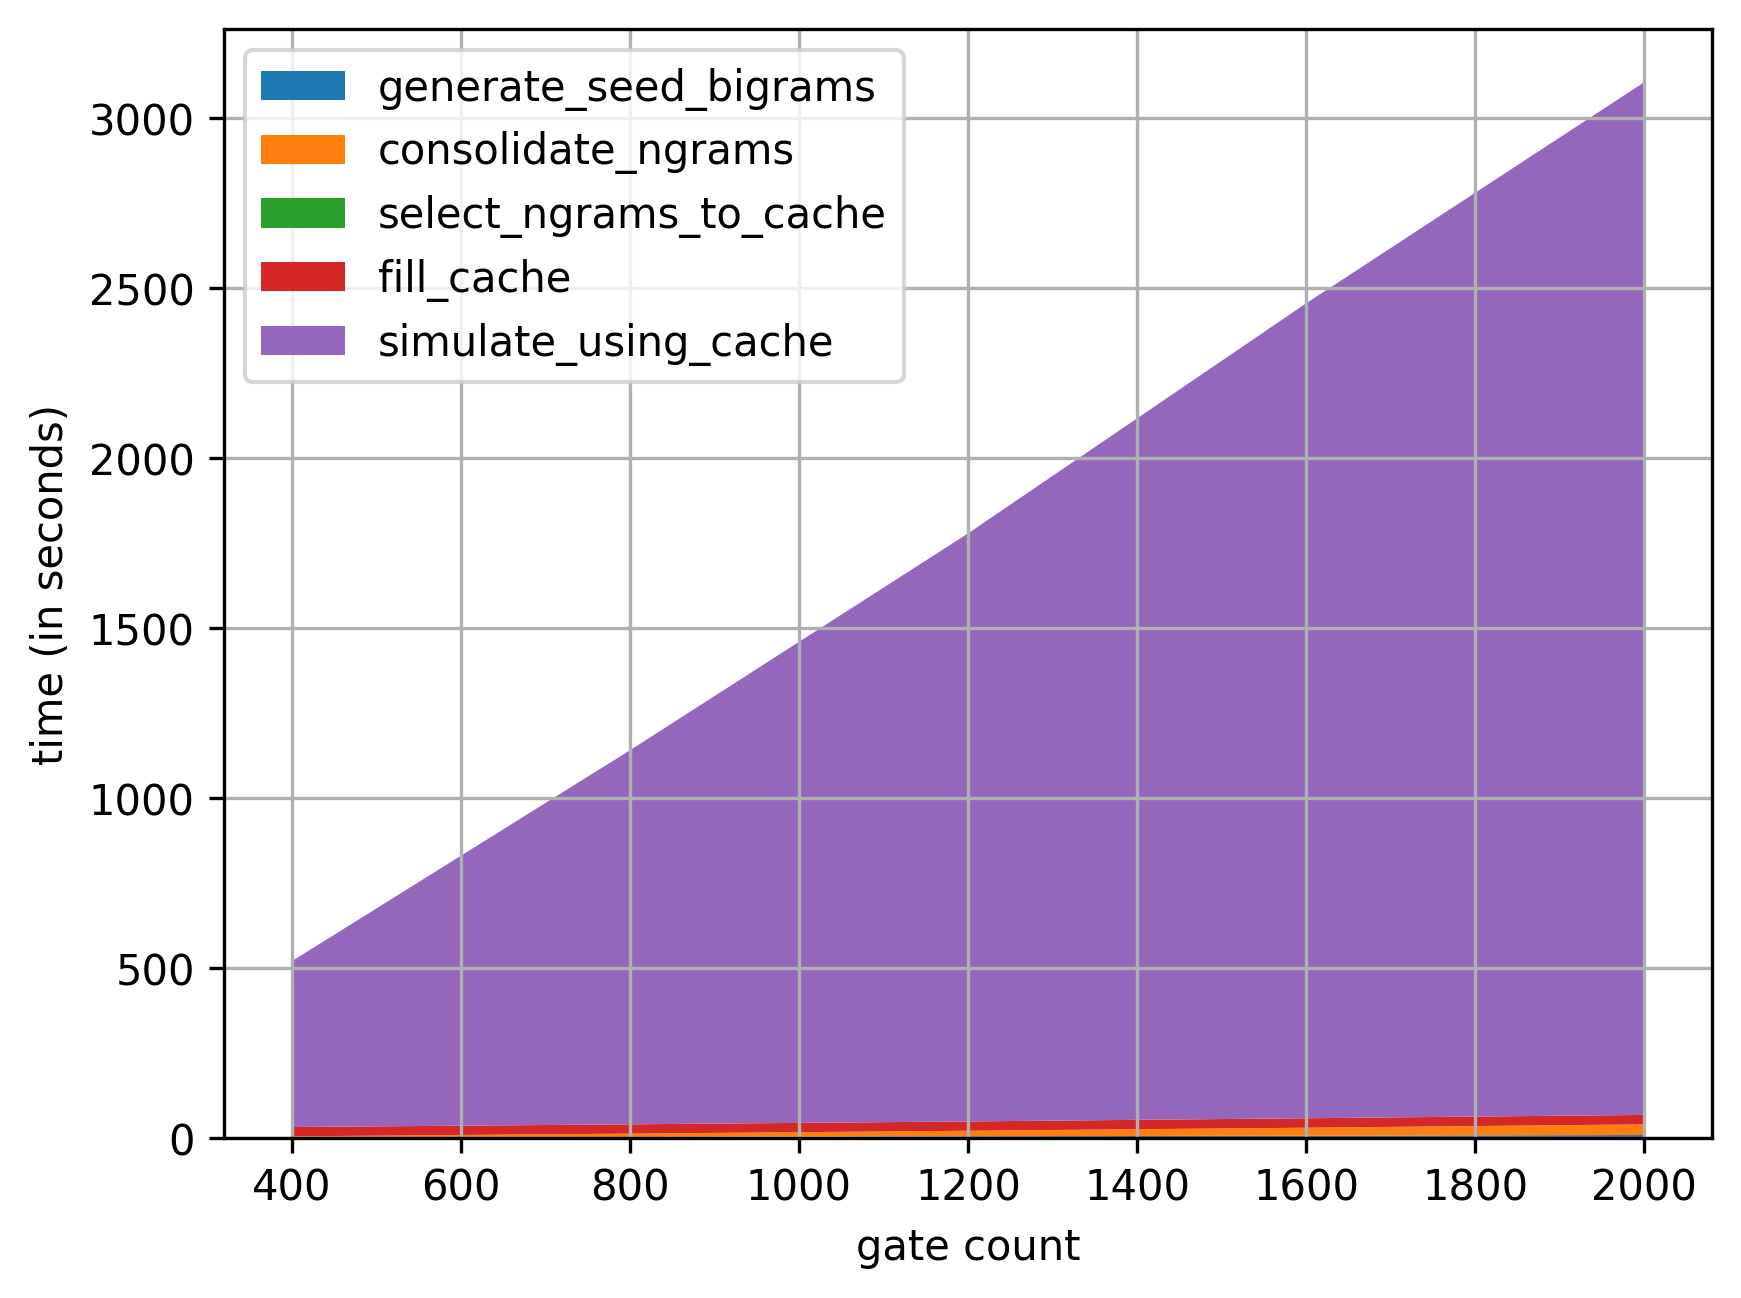

In [42]:

for redundancy in redundancies:

    generate_seed_bigrams_durations = []
    consolidate_ngrams_durations = []
    select_ngrams_to_cache_durations = []
    fill_cache_durations = []
    simulate_using_cache_durations = []

    for gate_count in gate_counts:

        relevant_experiments = [
            experiment
            for experiment in vg_experiments
            if experiment["params"]["cache_size"] > 0
            and experiment["params"]["gate_count"] == gate_count
            and experiment["params"]["redundancy"] == redundancy
        ]

        generate_seed_bigrams_durations.append(
            mean(
                [
                    experiment["generate_seed_bigrams"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        consolidate_ngrams_durations.append(
            mean(
                [
                    experiment["consolidate_ngrams"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        select_ngrams_to_cache_durations.append(
            mean(
                [
                    experiment["select_ngrams_to_cache"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        fill_cache_durations.append(
            mean(
                [
                    experiment["fill_cache"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )
        simulate_using_cache_durations.append(
            mean(
                [
                    experiment["simulate_using_cache"]["duration"]
                    for experiment in relevant_experiments
                ]
            )
        )

    x = gate_counts
    y = np.vstack(
        [
            generate_seed_bigrams_durations,
            consolidate_ngrams_durations,
            select_ngrams_to_cache_durations,
            fill_cache_durations,
            simulate_using_cache_durations,
        ],
    )

    fig, ax = plt.subplots()

    ax.stackplot(x, y)
    ax.set_xlabel("gate count")
    ax.set_ylabel("time (in seconds)")

    printb(f"Components of total simulation time with {redundancy} redundancy, averaged across seeds:")


    print("generate_seed_bigrams_durations:", generate_seed_bigrams_durations)
    print("consolidate_ngrams_durations:", consolidate_ngrams_durations)
    print("select_ngrams_to_cache_durations:", select_ngrams_to_cache_durations)
    print("fill_cache_durations:", fill_cache_durations)
    print("simulate_using_cache_durations:", simulate_using_cache_durations)
    print("gate_counts:", gate_counts)


    plt.legend(
        [
            "generate_seed_bigrams",
            "consolidate_ngrams",
            "select_ngrams_to_cache",
            "fill_cache",
            "simulate_using_cache",
        ]
    )
    plt.grid()

    plt.savefig(f"{target_dir}/time_over_gate_count_stacked_{redundancy}r.png")
    plt.show()